In [9]:
pip install "gymnasium[box2d]"

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379370 sha256=17d41454f9cbb01b4ad6a47645831a3425a236fd03efd6a989e0852bcdd1fae3
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [ ]:
pip install swig

In [11]:
import random
from collections import deque

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from gymnasium.core import Env
from torch import nn, optim
from tqdm import tqdm

In [12]:
class ReplayBuffer:
    def __init__(self, capacity=1000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size): #нередко нужно взять не весь буфер
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(np.array(states), dtype=torch.float32),
            torch.tensor(np.array(actions), dtype=torch.float32),
            torch.tensor(np.array(rewards), dtype=torch.float32),
            torch.tensor(np.array(next_states), dtype=torch.float32),
            torch.tensor(np.array(dones), dtype=torch.float32),
        )

    def __len__(self):
        return len(self.buffer)

In [13]:
class QNetwork(nn.Module):
    def __init__(self, obs_size, n_actions, layer_num ): #obs_size = 4, n_actions = 2 (или 0, или 1)
        super(QNetwork, self).__init__()
        if layer_num == 0:
            self.net = nn.Sequential(
                nn.Linear(obs_size, 128),
                nn.ReLU(),
                nn.Linear(128, n_actions)
            )
        elif layer_num == 1:
          self.net = nn.Sequential(
            nn.Linear(obs_size, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.Sigmoid(),
            nn.Linear(256, 128),
            nn.Sigmoid(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
        else:
          self.net = nn.Sequential(
             nn.Linear(obs_size, 32),
             nn.ReLU(),
             nn.Linear(32, n_actions)
        )

    def forward(self, x): #обязаткльный метод
        return self.net(x)

In [14]:
class DQNAgent:
    def __init__(self, obs_size, n_actions, layer = 0, gamma = 0.99, epsilon_decay = 0.955, epsilon = 1):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #важно, чтобы q_net и target в начале были одинаковые
        self.q_net = QNetwork(obs_size, n_actions, layer).to(self.device)
        self.target_net = QNetwork(obs_size, n_actions, layer).to(self.device)
        self.target_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=1e-3)

        self.gamma = gamma #как будущее зависит от прошлого 0.99
        self.batch_size = 64
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay #на какой коэффициент уменьшаем 0.955
        self.epsilon_min = 0.01

        self.replay_buffer = ReplayBuffer(1000)
        self.loss: float = 0.0 #FIX ME

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 1)

        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device)
            q_values = self.q_net(state_tensor)
            return torch.argmax(q_values).item()

    def train(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        self.replay_buffer.sample(self.batch_size)

        state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)

        states = torch.tensor(state, dtype=torch.float32, device=self.device)
        actions = torch.tensor(action, dtype=torch.long, device=self.device)
        reward = torch.tensor(reward, dtype=torch.float32, device=self.device)
        next_states = torch.tensor(next_state, dtype=torch.float32, device=self.device)
        done = torch.tensor(done, dtype=torch.float32, device=self.device)

        """ dqn update магия """

        q_values = self.q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_net(next_states).max(1)[0]
        target_q_values = reward + self.gamma * next_q_values * (1 - done)

        loss = nn.MSELoss()(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.loss = loss.item()

    def update_target(self):
        self.target_net.load_state_dict(self.q_net.state_dict())


In [28]:
def calc(lay, gamma, eps_decay, eps_start):
  agent = DQNAgent(4, 2, layer = lay, gamma = gamma, epsilon_decay = eps_decay, epsilon = eps_start)
  num_episodes = 250
  env = gym.make("CartPole-v1", render_mode="rgb_array")
  done = False
  reward_history = []
  loss_history = []
  num_steps = 200
  key = f"gamma: {gamma}, eps_decay: {eps_decay}, eps_start: {eps_start}"
  for episode in tqdm(range(num_episodes), desc=key):
      state, _ = env.reset()
      episode_reward = 0.0
      episode_loss = 0.0

      for step in range(num_steps):
          action = agent.select_action(state)
          next_state, reward, done, truncated, info = env.step(action)
          agent.replay_buffer.push(state, action, reward, next_state, done)

          state = next_state
          episode_reward += reward

          agent.train()
          episode_loss += float(agent.loss)

          if done:
              break
      agent.update_target()
      agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
      reward_history.append(episode_reward)
      loss_history.append(episode_loss)
      if episode % 10 == 0:
          print(f"Episode: {episode}, Reward: {episode_reward}, Loss: {episode_loss}")
  return reward_history, loss_history, key


In [29]:
def run_experiment(lay, gammas, epsilon_decas, epsilons):
    reward_results = {}
    loss_results = {}
    for gamma in gammas:
        for eps_decay in epsilon_decas:
            for eps_start in epsilons:
                  reward_history, loss_history, key = calc(lay, gamma, eps_decay, eps_start)
                  reward_results[key] = reward_history
                  loss_results[key] = loss_history

    return reward_results, loss_results

def plot_results(results, name, smooth_window=10):
    plt.figure(figsize=(12, 8))
    for label, rewards in results.items():
        smoothed = np.convolve(rewards, np.ones(smooth_window)/smooth_window, mode='valid')
        plt.plot(smoothed, label=label)

    plt.xlabel('Episode')
    plt.ylabel(name)
    plt.title('Сравнение параметров DQN')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


gamma_values = [0.95, 0.99]
epsilon_decay_values = [0.955, 0.8, 0.5]
initial_epsilons = [1.0, 0.5, 0.2]



gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:   0%|          | 0/250 [00:00<?, ?it/s]<ipython-input-14-c5929f1a6a00>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.tensor(state, dtype=torch.float32, device=self.device)
<ipython-input-14-c5929f1a6a00>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actions = torch.tensor(action, dtype=torch.long, device=self.device)
<ipython-input-14-c5929f1a6a00>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reward = torch.tensor(reward, dtype=torch.float32, device=self.device)
<i

Episode: 0, Reward: 21.0, Loss: 0.0


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:   5%|▍         | 12/250 [00:00<00:19, 12.46it/s]

Episode: 10, Reward: 17.0, Loss: 28.70146483182907


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  11%|█         | 27/250 [00:01<00:09, 24.41it/s]

Episode: 20, Reward: 13.0, Loss: 43.98592126369476


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  14%|█▍        | 35/250 [00:01<00:07, 27.47it/s]

Episode: 30, Reward: 17.0, Loss: 54.751378297805786


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  17%|█▋        | 43/250 [00:01<00:07, 26.07it/s]

Episode: 40, Reward: 18.0, Loss: 95.96599847078323


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  21%|██        | 52/250 [00:02<00:12, 15.94it/s]

Episode: 50, Reward: 32.0, Loss: 98.8078598678112


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  25%|██▍       | 62/250 [00:03<00:20,  9.00it/s]

Episode: 60, Reward: 74.0, Loss: 236.48475529253483


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  28%|██▊       | 71/250 [00:05<00:30,  5.80it/s]

Episode: 70, Reward: 60.0, Loss: 106.31427385658026


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  33%|███▎      | 82/250 [00:08<00:50,  3.30it/s]

Episode: 80, Reward: 78.0, Loss: 59.383961245417595


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  36%|███▋      | 91/250 [00:13<01:16,  2.08it/s]

Episode: 90, Reward: 142.0, Loss: 4.633734942879528


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  40%|████      | 101/250 [00:18<01:18,  1.91it/s]

Episode: 100, Reward: 200.0, Loss: 0.43996631511254236


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  44%|████▍     | 111/250 [00:24<01:23,  1.66it/s]

Episode: 110, Reward: 200.0, Loss: 0.1471425125200767


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  48%|████▊     | 121/250 [00:29<00:59,  2.17it/s]

Episode: 120, Reward: 200.0, Loss: 0.06948827491578413


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  52%|█████▏    | 131/250 [00:33<00:46,  2.56it/s]

Episode: 130, Reward: 181.0, Loss: 133.32675714977086


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  56%|█████▋    | 141/250 [00:38<00:56,  1.94it/s]

Episode: 140, Reward: 200.0, Loss: 0.4146494376473129


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  60%|██████    | 151/250 [00:42<00:43,  2.29it/s]

Episode: 150, Reward: 200.0, Loss: 0.1769443213706836


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  64%|██████▍   | 161/250 [00:47<00:39,  2.27it/s]

Episode: 160, Reward: 200.0, Loss: 0.23887994070537388


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  68%|██████▊   | 171/250 [00:52<00:36,  2.16it/s]

Episode: 170, Reward: 200.0, Loss: 0.22392004381981678


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  72%|███████▏  | 181/250 [00:56<00:30,  2.30it/s]

Episode: 180, Reward: 200.0, Loss: 0.07880450817901874


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  76%|███████▋  | 191/250 [01:02<00:36,  1.61it/s]

Episode: 190, Reward: 200.0, Loss: 0.1784820637840312


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  80%|████████  | 201/250 [01:06<00:22,  2.16it/s]

Episode: 200, Reward: 200.0, Loss: 0.03179677754815202


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  84%|████████▍ | 211/250 [01:11<00:18,  2.10it/s]

Episode: 210, Reward: 200.0, Loss: 0.0900878306129016


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  88%|████████▊ | 221/250 [01:17<00:14,  2.03it/s]

Episode: 220, Reward: 200.0, Loss: 0.04088618926471099


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  92%|█████████▏| 231/250 [01:21<00:08,  2.19it/s]

Episode: 230, Reward: 200.0, Loss: 0.011812395150627708


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  96%|█████████▋| 241/250 [01:26<00:04,  1.86it/s]

Episode: 240, Reward: 200.0, Loss: 0.03558608975072275


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:   3%|▎         | 8/250 [00:00<00:03, 70.58it/s]

Episode: 0, Reward: 9.0, Loss: 0.0
Episode: 10, Reward: 13.0, Loss: 21.323694050312042


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  11%|█         | 27/250 [00:00<00:05, 38.82it/s]

Episode: 20, Reward: 12.0, Loss: 43.220332860946655


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  13%|█▎        | 32/250 [00:00<00:07, 30.54it/s]

Episode: 30, Reward: 13.0, Loss: 30.830530285835266


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  17%|█▋        | 43/250 [00:01<00:10, 19.25it/s]

Episode: 40, Reward: 42.0, Loss: 157.28079736232758


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  22%|██▏       | 54/250 [00:01<00:08, 22.33it/s]

Episode: 50, Reward: 15.0, Loss: 84.42943549156189


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  25%|██▍       | 62/250 [00:02<00:15, 12.02it/s]

Episode: 60, Reward: 56.0, Loss: 232.33312445878983


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  28%|██▊       | 71/250 [00:04<00:35,  5.02it/s]

Episode: 70, Reward: 132.0, Loss: 262.80407708883286


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  32%|███▏      | 81/250 [00:07<00:44,  3.81it/s]

Episode: 80, Reward: 56.0, Loss: 56.25425577536225


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  36%|███▋      | 91/250 [00:10<00:45,  3.51it/s]

Episode: 90, Reward: 101.0, Loss: 42.19675278291106


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  40%|████      | 101/250 [00:14<01:03,  2.35it/s]

Episode: 100, Reward: 200.0, Loss: 2.748131875297986


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  44%|████▍     | 111/250 [00:19<00:59,  2.33it/s]

Episode: 110, Reward: 200.0, Loss: 0.18449861783301458


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  48%|████▊     | 121/250 [00:24<00:59,  2.18it/s]

Episode: 120, Reward: 200.0, Loss: 0.0601085370144574


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  52%|█████▏    | 131/250 [00:28<00:50,  2.35it/s]

Episode: 130, Reward: 200.0, Loss: 0.06075278237403836


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  56%|█████▋    | 141/250 [00:34<01:10,  1.54it/s]

Episode: 140, Reward: 200.0, Loss: 0.017770031843610923


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  60%|██████    | 151/250 [00:38<00:46,  2.12it/s]

Episode: 150, Reward: 200.0, Loss: 0.018369314941082848


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  64%|██████▍   | 161/250 [00:43<00:39,  2.27it/s]

Episode: 160, Reward: 200.0, Loss: 0.0066759368928615


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  68%|██████▊   | 170/250 [00:47<00:41,  1.92it/s]

Episode: 170, Reward: 12.0, Loss: 0.013409081179815985


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  72%|███████▏  | 181/250 [00:52<00:30,  2.26it/s]

Episode: 180, Reward: 200.0, Loss: 0.05354856632766314


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  76%|███████▋  | 191/250 [00:56<00:25,  2.28it/s]

Episode: 190, Reward: 200.0, Loss: 0.022963216615607962


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  80%|████████  | 201/250 [01:02<00:23,  2.12it/s]

Episode: 200, Reward: 200.0, Loss: 0.008416034267611394


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  84%|████████▍ | 211/250 [01:06<00:17,  2.26it/s]

Episode: 210, Reward: 200.0, Loss: 0.026009559849626385


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  88%|████████▊ | 221/250 [01:12<00:17,  1.66it/s]

Episode: 220, Reward: 200.0, Loss: 0.010067369099488133


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  92%|█████████▏| 231/250 [01:16<00:08,  2.25it/s]

Episode: 230, Reward: 200.0, Loss: 0.016047786357376026


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  96%|█████████▋| 241/250 [01:21<00:03,  2.28it/s]

Episode: 240, Reward: 200.0, Loss: 0.0047878258778837335


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:   4%|▍         | 11/250 [00:00<00:02, 101.08it/s]

Episode: 0, Reward: 11.0, Loss: 0.0
Episode: 10, Reward: 8.0, Loss: 10.5624361038208


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  12%|█▏        | 29/250 [00:00<00:04, 54.37it/s]

Episode: 20, Reward: 12.0, Loss: 34.99529755115509


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  14%|█▍        | 35/250 [00:00<00:04, 47.06it/s]

Episode: 30, Reward: 10.0, Loss: 7.7221285700798035


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  18%|█▊        | 45/250 [00:01<00:05, 36.20it/s]

Episode: 40, Reward: 10.0, Loss: 19.679394900798798


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  21%|██        | 53/250 [00:01<00:06, 29.92it/s]

Episode: 50, Reward: 14.0, Loss: 32.55176770687103


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  26%|██▌       | 64/250 [00:02<00:11, 16.18it/s]

Episode: 60, Reward: 25.0, Loss: 75.75750052928925


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  29%|██▉       | 72/250 [00:02<00:14, 12.18it/s]

Episode: 70, Reward: 46.0, Loss: 188.6978992819786


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  33%|███▎      | 82/250 [00:05<00:31,  5.33it/s]

Episode: 80, Reward: 88.0, Loss: 111.62162250652909


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  36%|███▋      | 91/250 [00:08<01:00,  2.65it/s]

Episode: 90, Reward: 200.0, Loss: 63.491125392727554


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  40%|████      | 101/250 [00:13<01:14,  1.99it/s]

Episode: 100, Reward: 154.0, Loss: 38.122350450605154


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  44%|████▍     | 111/250 [00:17<00:55,  2.51it/s]

Episode: 110, Reward: 183.0, Loss: 93.33100995328277


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  48%|████▊     | 121/250 [00:21<00:47,  2.73it/s]

Episode: 120, Reward: 174.0, Loss: 84.72769929282367


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  52%|█████▏    | 131/250 [00:25<00:46,  2.55it/s]

Episode: 130, Reward: 190.0, Loss: 26.0717784287408


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  56%|█████▋    | 141/250 [00:30<00:48,  2.23it/s]

Episode: 140, Reward: 200.0, Loss: 0.17662960209418088


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  60%|██████    | 151/250 [00:35<00:52,  1.88it/s]

Episode: 150, Reward: 200.0, Loss: 0.049685404024785385


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  64%|██████▍   | 161/250 [00:40<00:40,  2.19it/s]

Episode: 160, Reward: 200.0, Loss: 0.02680899001643411


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  68%|██████▊   | 171/250 [00:44<00:34,  2.29it/s]

Episode: 170, Reward: 200.0, Loss: 0.013404391156655038


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  72%|███████▏  | 181/250 [00:50<00:37,  1.84it/s]

Episode: 180, Reward: 200.0, Loss: 0.026440660178195685


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  76%|███████▌  | 189/250 [00:53<00:26,  2.28it/s]

Episode: 190, Reward: 20.0, Loss: 12.4280347796157


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  80%|████████  | 201/250 [00:56<00:15,  3.10it/s]

Episode: 200, Reward: 151.0, Loss: 47.12362856976688


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  84%|████████▍ | 211/250 [01:01<00:20,  1.91it/s]

Episode: 210, Reward: 194.0, Loss: 36.290476405993104


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  88%|████████▊ | 221/250 [01:05<00:13,  2.17it/s]

Episode: 220, Reward: 200.0, Loss: 0.16569127241382375


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  92%|█████████▏| 231/250 [01:10<00:08,  2.23it/s]

Episode: 230, Reward: 200.0, Loss: 0.06382106791716069


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  96%|█████████▋| 241/250 [01:15<00:04,  2.01it/s]

Episode: 240, Reward: 200.0, Loss: 0.02505852308604517


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:   3%|▎         | 7/250 [00:00<00:03, 67.77it/s]

Episode: 0, Reward: 18.0, Loss: 0.0
Episode: 10, Reward: 8.0, Loss: 14.979080200195312


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  10%|█         | 26/250 [00:00<00:04, 51.69it/s]

Episode: 20, Reward: 8.0, Loss: 23.219826221466064


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  15%|█▌        | 38/250 [00:00<00:04, 46.69it/s]

Episode: 30, Reward: 10.0, Loss: 15.989834249019623


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  19%|█▉        | 48/250 [00:00<00:04, 46.46it/s]

Episode: 40, Reward: 10.0, Loss: 106.42381739616394


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  21%|██        | 53/250 [00:01<00:06, 29.07it/s]

Episode: 50, Reward: 27.0, Loss: 87.38796275854111


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  25%|██▌       | 63/250 [00:02<00:09, 19.49it/s]

Episode: 60, Reward: 17.0, Loss: 61.06060692667961


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  30%|██▉       | 74/250 [00:02<00:10, 17.07it/s]

Episode: 70, Reward: 20.0, Loss: 91.59347718954086


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  32%|███▏      | 81/250 [00:03<00:09, 17.63it/s]

Episode: 80, Reward: 21.0, Loss: 91.3698239326477


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  37%|███▋      | 93/250 [00:04<00:10, 14.46it/s]

Episode: 90, Reward: 16.0, Loss: 65.77491536736488


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  41%|████      | 102/250 [00:04<00:12, 12.19it/s]

Episode: 100, Reward: 34.0, Loss: 123.60538120567799


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  44%|████▍     | 111/250 [00:06<00:23,  5.91it/s]

Episode: 110, Reward: 75.0, Loss: 233.3000200688839


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  49%|████▉     | 122/250 [00:08<00:21,  5.97it/s]

Episode: 120, Reward: 97.0, Loss: 191.16299976408482


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  52%|█████▏    | 131/250 [00:11<00:44,  2.65it/s]

Episode: 130, Reward: 184.0, Loss: 8.281971467658877


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  56%|█████▋    | 141/250 [00:14<00:35,  3.03it/s]

Episode: 140, Reward: 137.0, Loss: 44.01285195723176


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  60%|██████    | 151/250 [00:18<00:46,  2.13it/s]

Episode: 150, Reward: 182.0, Loss: 65.2211733860895


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  64%|██████▍   | 161/250 [00:23<00:39,  2.26it/s]

Episode: 160, Reward: 200.0, Loss: 0.5273631382733583


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  68%|██████▊   | 171/250 [00:27<00:34,  2.29it/s]

Episode: 170, Reward: 200.0, Loss: 0.07296260434668511


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  72%|███████▏  | 181/250 [00:33<00:47,  1.46it/s]

Episode: 180, Reward: 200.0, Loss: 0.02824367781431647


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  76%|███████▋  | 191/250 [00:38<00:27,  2.15it/s]

Episode: 190, Reward: 200.0, Loss: 0.008505285124556394


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  80%|████████  | 201/250 [00:42<00:23,  2.08it/s]

Episode: 200, Reward: 200.0, Loss: 0.023044589655910386


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  84%|████████▍ | 211/250 [00:48<00:18,  2.09it/s]

Episode: 210, Reward: 200.0, Loss: 0.01508689699221577


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  88%|████████▊ | 221/250 [00:52<00:12,  2.23it/s]

Episode: 220, Reward: 200.0, Loss: 12.32612372143194


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  92%|█████████▏| 231/250 [00:57<00:10,  1.74it/s]

Episode: 230, Reward: 200.0, Loss: 0.07974166955682449


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  96%|█████████▋| 241/250 [01:02<00:04,  2.14it/s]

Episode: 240, Reward: 200.0, Loss: 0.01908399693274987


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:   1%|          | 3/250 [00:00<00:10, 24.25it/s]

Episode: 0, Reward: 19.0, Loss: 0.0


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:   6%|▋         | 16/250 [00:00<00:06, 37.55it/s]

Episode: 10, Reward: 10.0, Loss: 26.84788429737091


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  10%|▉         | 24/250 [00:00<00:07, 30.82it/s]

Episode: 20, Reward: 9.0, Loss: 51.966291427612305


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  14%|█▍        | 36/250 [00:01<00:06, 30.57it/s]

Episode: 30, Reward: 9.0, Loss: 196.70149040222168


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  18%|█▊        | 44/250 [00:01<00:08, 24.38it/s]

Episode: 40, Reward: 33.0, Loss: 580.8833451271057


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  23%|██▎       | 57/250 [00:02<00:07, 26.76it/s]

Episode: 50, Reward: 9.0, Loss: 79.32744836807251


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  25%|██▌       | 63/250 [00:02<00:07, 25.36it/s]

Episode: 60, Reward: 12.0, Loss: 48.224929451942444


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  28%|██▊       | 71/250 [00:03<00:16, 10.62it/s]

Episode: 70, Reward: 43.0, Loss: 104.40710535645485


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  34%|███▎      | 84/250 [00:04<00:11, 14.13it/s]

Episode: 80, Reward: 27.0, Loss: 85.18867039680481


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  37%|███▋      | 93/250 [00:04<00:08, 19.41it/s]

Episode: 90, Reward: 23.0, Loss: 122.559823513031


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  41%|████      | 102/250 [00:05<00:07, 19.92it/s]

Episode: 100, Reward: 30.0, Loss: 135.37284070253372


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  45%|████▌     | 113/250 [00:05<00:09, 14.01it/s]

Episode: 110, Reward: 30.0, Loss: 116.94940945506096


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  48%|████▊     | 121/250 [00:07<00:24,  5.32it/s]

Episode: 120, Reward: 100.0, Loss: 223.55148205161095


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  52%|█████▏    | 131/250 [00:11<00:51,  2.30it/s]

Episode: 130, Reward: 200.0, Loss: 27.365039074793458


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  56%|█████▋    | 141/250 [00:17<00:54,  2.00it/s]

Episode: 140, Reward: 200.0, Loss: 84.26325872959569


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  60%|██████    | 151/250 [00:21<00:44,  2.21it/s]

Episode: 150, Reward: 200.0, Loss: 0.10205693381431047


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  64%|██████▍   | 161/250 [00:26<00:46,  1.90it/s]

Episode: 160, Reward: 200.0, Loss: 0.07195932389731752


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  68%|██████▊   | 171/250 [00:31<00:35,  2.20it/s]

Episode: 170, Reward: 200.0, Loss: 0.13806258083786815


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  72%|███████▏  | 181/250 [00:36<00:30,  2.28it/s]

Episode: 180, Reward: 200.0, Loss: 107.2555471182277


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  76%|███████▋  | 191/250 [00:40<00:25,  2.34it/s]

Episode: 190, Reward: 200.0, Loss: 6.176799282198772


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  80%|████████  | 201/250 [00:45<00:23,  2.07it/s]

Episode: 200, Reward: 200.0, Loss: 0.030070031694776844


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  84%|████████▍ | 211/250 [00:50<00:17,  2.25it/s]

Episode: 210, Reward: 200.0, Loss: 0.031188524946628604


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  88%|████████▊ | 221/250 [00:55<00:13,  2.17it/s]

Episode: 220, Reward: 200.0, Loss: 0.008647492757518194


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  92%|█████████▏| 231/250 [01:00<00:08,  2.25it/s]

Episode: 230, Reward: 200.0, Loss: 0.011892964124854188


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  96%|█████████▋| 241/250 [01:05<00:05,  1.69it/s]

Episode: 240, Reward: 200.0, Loss: 0.009045280640748388


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:   4%|▍         | 11/250 [00:00<00:02, 105.78it/s]

Episode: 0, Reward: 9.0, Loss: 0.0
Episode: 10, Reward: 10.0, Loss: 12.79387503862381


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  12%|█▏        | 30/250 [00:00<00:03, 56.52it/s]

Episode: 20, Reward: 11.0, Loss: 37.15342307090759


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  15%|█▍        | 37/250 [00:00<00:04, 51.27it/s]

Episode: 30, Reward: 10.0, Loss: 12.281086266040802


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  19%|█▉        | 48/250 [00:00<00:04, 44.29it/s]

Episode: 40, Reward: 13.0, Loss: 8.204997807741165


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  23%|██▎       | 57/250 [00:01<00:04, 38.64it/s]

Episode: 50, Reward: 17.0, Loss: 32.1682870388031


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  26%|██▌       | 65/250 [00:01<00:05, 32.12it/s]

Episode: 60, Reward: 13.0, Loss: 38.06485363841057


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  29%|██▉       | 72/250 [00:01<00:07, 23.71it/s]

Episode: 70, Reward: 18.0, Loss: 50.071481347084045


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  33%|███▎      | 82/250 [00:02<00:11, 15.10it/s]

Episode: 80, Reward: 48.0, Loss: 190.3819718360901


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  37%|███▋      | 92/250 [00:04<00:22,  6.96it/s]

Episode: 90, Reward: 73.0, Loss: 150.18770311772823


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  40%|████      | 101/250 [00:06<00:37,  4.01it/s]

Episode: 100, Reward: 93.0, Loss: 57.122928040102124


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  44%|████▍     | 111/250 [00:10<00:58,  2.38it/s]

Episode: 110, Reward: 200.0, Loss: 16.036216082051396


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  48%|████▊     | 121/250 [00:14<00:57,  2.23it/s]

Episode: 120, Reward: 200.0, Loss: 0.1913850576383993


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  52%|█████▏    | 131/250 [00:19<01:02,  1.91it/s]

Episode: 130, Reward: 200.0, Loss: 0.09246113302651793


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  56%|█████▋    | 141/250 [00:24<00:50,  2.14it/s]

Episode: 140, Reward: 200.0, Loss: 0.06849308308301261


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  60%|██████    | 151/250 [00:29<00:46,  2.11it/s]

Episode: 150, Reward: 200.0, Loss: 0.021351913434045855


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  64%|██████▍   | 161/250 [00:35<00:46,  1.92it/s]

Episode: 160, Reward: 200.0, Loss: 0.009046440092788544


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  68%|██████▊   | 171/250 [00:39<00:35,  2.20it/s]

Episode: 170, Reward: 200.0, Loss: 0.012470458534153295


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  72%|███████▏  | 181/250 [00:44<00:37,  1.86it/s]

Episode: 180, Reward: 200.0, Loss: 0.00890795076793438


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  76%|███████▋  | 191/250 [00:49<00:26,  2.22it/s]

Episode: 190, Reward: 200.0, Loss: 0.003842458716917463


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  80%|████████  | 201/250 [00:54<00:21,  2.29it/s]

Episode: 200, Reward: 200.0, Loss: 0.0037293737518666603


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  84%|████████▍ | 211/250 [00:59<00:22,  1.74it/s]

Episode: 210, Reward: 200.0, Loss: 0.0021712355337513145


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  88%|████████▊ | 221/250 [01:04<00:14,  2.04it/s]

Episode: 220, Reward: 200.0, Loss: 0.05507487215072615


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  92%|█████████▏| 231/250 [01:08<00:08,  2.22it/s]

Episode: 230, Reward: 200.0, Loss: 0.002441198230826558


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  96%|█████████▋| 241/250 [01:13<00:04,  2.12it/s]

Episode: 240, Reward: 200.0, Loss: 0.02163804605606856


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:   4%|▎         | 9/250 [00:00<00:03, 76.44it/s]

Episode: 0, Reward: 14.0, Loss: 0.0
Episode: 10, Reward: 8.0, Loss: 11.710532188415527


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  12%|█▏        | 29/250 [00:00<00:04, 51.88it/s]

Episode: 20, Reward: 10.0, Loss: 41.526875495910645
Episode: 30, Reward: 9.0, Loss: 22.26398777961731


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  18%|█▊        | 45/250 [00:00<00:04, 44.95it/s]

Episode: 40, Reward: 9.0, Loss: 8.460246473550797


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  22%|██▏       | 55/250 [00:01<00:04, 42.48it/s]

Episode: 50, Reward: 9.0, Loss: 14.404830932617188


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  26%|██▌       | 64/250 [00:01<00:05, 33.74it/s]

Episode: 60, Reward: 9.0, Loss: 32.82363271713257


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  29%|██▉       | 72/250 [00:01<00:06, 27.07it/s]

Episode: 70, Reward: 20.0, Loss: 52.150446355342865


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  34%|███▎      | 84/250 [00:02<00:10, 15.36it/s]

Episode: 80, Reward: 47.0, Loss: 140.39577674865723


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  37%|███▋      | 92/250 [00:03<00:12, 12.63it/s]

Episode: 90, Reward: 38.0, Loss: 111.99366109073162


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  40%|████      | 101/250 [00:05<00:21,  6.98it/s]

Episode: 100, Reward: 41.0, Loss: 100.92319928854704


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  44%|████▍     | 111/250 [00:08<00:53,  2.61it/s]

Episode: 110, Reward: 200.0, Loss: 74.30761921498924


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  48%|████▊     | 121/250 [00:11<00:49,  2.62it/s]

Episode: 120, Reward: 176.0, Loss: 85.02539194375277


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  52%|█████▏    | 131/250 [00:15<00:36,  3.26it/s]

Episode: 130, Reward: 134.0, Loss: 48.769471008330584


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  56%|█████▋    | 141/250 [00:19<00:47,  2.27it/s]

Episode: 140, Reward: 188.0, Loss: 66.77178178261966


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  60%|██████    | 151/250 [00:23<00:40,  2.45it/s]

Episode: 150, Reward: 200.0, Loss: 55.305456483736634


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  64%|██████▍   | 161/250 [00:27<00:36,  2.44it/s]

Episode: 160, Reward: 200.0, Loss: 17.904726318083704


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  68%|██████▊   | 171/250 [00:32<00:39,  2.01it/s]

Episode: 170, Reward: 200.0, Loss: 0.1293767663592007


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  72%|███████▏  | 181/250 [00:36<00:31,  2.17it/s]

Episode: 180, Reward: 200.0, Loss: 0.06150112664909102


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  76%|███████▋  | 191/250 [00:41<00:29,  1.98it/s]

Episode: 190, Reward: 200.0, Loss: 0.06172438015346415


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  80%|████████  | 201/250 [00:46<00:22,  2.22it/s]

Episode: 200, Reward: 200.0, Loss: 0.013765950599918142


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  84%|████████▍ | 211/250 [00:51<00:17,  2.25it/s]

Episode: 210, Reward: 200.0, Loss: 0.008269266265415354


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  88%|████████▊ | 221/250 [00:56<00:16,  1.74it/s]

Episode: 220, Reward: 200.0, Loss: 0.019691452043844038


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  92%|█████████▏| 231/250 [01:01<00:08,  2.27it/s]

Episode: 230, Reward: 200.0, Loss: 0.03189780455431901


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  96%|█████████▋| 241/250 [01:05<00:03,  2.32it/s]

Episode: 240, Reward: 200.0, Loss: 0.0040636909052409464


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:   4%|▎         | 9/250 [00:00<00:02, 83.26it/s]

Episode: 0, Reward: 11.0, Loss: 0.0
Episode: 10, Reward: 10.0, Loss: 9.67953509092331


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  10%|█         | 25/250 [00:00<00:04, 52.10it/s]

Episode: 20, Reward: 10.0, Loss: 41.906203746795654


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  14%|█▍        | 36/250 [00:00<00:04, 45.31it/s]

Episode: 30, Reward: 9.0, Loss: 20.40090250968933


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  18%|█▊        | 46/250 [00:00<00:04, 45.31it/s]

Episode: 40, Reward: 9.0, Loss: 11.555326759815216


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  22%|██▏       | 56/250 [00:01<00:04, 40.33it/s]

Episode: 50, Reward: 9.0, Loss: 8.794469058513641


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  26%|██▌       | 65/250 [00:01<00:05, 35.35it/s]

Episode: 60, Reward: 19.0, Loss: 19.086709648370743


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  29%|██▉       | 73/250 [00:01<00:05, 32.26it/s]

Episode: 70, Reward: 14.0, Loss: 15.348065465688705


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  34%|███▎      | 84/250 [00:02<00:06, 25.15it/s]

Episode: 80, Reward: 19.0, Loss: 43.09695369005203


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  37%|███▋      | 93/250 [00:02<00:07, 21.10it/s]

Episode: 90, Reward: 19.0, Loss: 37.657226115465164


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  40%|████      | 101/250 [00:03<00:10, 13.95it/s]

Episode: 100, Reward: 50.0, Loss: 217.59629046916962


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  44%|████▍     | 111/250 [00:05<00:22,  6.20it/s]

Episode: 110, Reward: 67.0, Loss: 135.85876588523388


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  48%|████▊     | 121/250 [00:08<00:52,  2.44it/s]

Episode: 120, Reward: 200.0, Loss: 7.2438633921556175


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  52%|█████▏    | 131/250 [00:13<00:53,  2.21it/s]

Episode: 130, Reward: 200.0, Loss: 73.73445035610348


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  56%|█████▋    | 141/250 [00:17<00:40,  2.69it/s]

Episode: 140, Reward: 159.0, Loss: 26.84401684300974


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  60%|██████    | 151/250 [00:22<00:44,  2.24it/s]

Episode: 150, Reward: 200.0, Loss: 0.34274879726581275


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  64%|██████▍   | 161/250 [00:27<00:41,  2.15it/s]

Episode: 160, Reward: 200.0, Loss: 0.09882751973054837


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  68%|██████▊   | 171/250 [00:31<00:34,  2.28it/s]

Episode: 170, Reward: 200.0, Loss: 0.044858196830318775


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  72%|███████▏  | 181/250 [00:36<00:36,  1.89it/s]

Episode: 180, Reward: 200.0, Loss: 0.01979492807367933


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  76%|███████▋  | 191/250 [00:41<00:26,  2.21it/s]

Episode: 190, Reward: 200.0, Loss: 0.012120354394937749


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  80%|████████  | 201/250 [00:45<00:21,  2.29it/s]

Episode: 200, Reward: 200.0, Loss: 0.011910545970749808


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  84%|████████▍ | 211/250 [00:50<00:20,  1.89it/s]

Episode: 210, Reward: 200.0, Loss: 0.004281464626728848


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  88%|████████▊ | 221/250 [00:55<00:12,  2.30it/s]

Episode: 220, Reward: 200.0, Loss: 0.011656497892545303


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  92%|█████████▏| 231/250 [00:59<00:08,  2.28it/s]

Episode: 230, Reward: 200.0, Loss: 0.0039347136639662494


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  96%|█████████▋| 241/250 [01:04<00:04,  2.22it/s]

Episode: 240, Reward: 200.0, Loss: 0.005370346157178574


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:   1%|          | 2/250 [00:00<00:24, 10.03it/s]

Episode: 0, Reward: 80.0, Loss: 11.387521803379059


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:   6%|▋         | 16/250 [00:00<00:09, 23.93it/s]

Episode: 10, Reward: 15.0, Loss: 30.26321542263031


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:   9%|▉         | 22/250 [00:01<00:12, 18.03it/s]

Episode: 20, Reward: 40.0, Loss: 115.39010047912598


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  13%|█▎        | 32/250 [00:02<00:18, 11.48it/s]

Episode: 30, Reward: 43.0, Loss: 131.98559372127056


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  17%|█▋        | 42/250 [00:03<00:25,  8.29it/s]

Episode: 40, Reward: 57.0, Loss: 140.73822209239006


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  21%|██        | 52/250 [00:04<00:36,  5.49it/s]

Episode: 50, Reward: 52.0, Loss: 57.48429421335459


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  24%|██▍       | 61/250 [00:08<01:08,  2.77it/s]

Episode: 60, Reward: 101.0, Loss: 35.05310628376901


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  28%|██▊       | 71/250 [00:13<01:20,  2.24it/s]

Episode: 70, Reward: 200.0, Loss: 13.267305221641436


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  32%|███▏      | 81/250 [00:19<01:58,  1.42it/s]

Episode: 80, Reward: 200.0, Loss: 0.4564379703369923


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  36%|███▋      | 91/250 [00:23<01:11,  2.23it/s]

Episode: 90, Reward: 192.0, Loss: 118.63596429396421


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  40%|████      | 101/250 [00:28<01:07,  2.22it/s]

Episode: 100, Reward: 200.0, Loss: 51.75520941801369


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  44%|████▍     | 111/250 [00:33<01:09,  2.01it/s]

Episode: 110, Reward: 200.0, Loss: 0.21941593359224498


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  48%|████▊     | 121/250 [00:37<00:56,  2.27it/s]

Episode: 120, Reward: 200.0, Loss: 0.03568460061433143


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  52%|█████▏    | 131/250 [00:43<01:10,  1.69it/s]

Episode: 130, Reward: 200.0, Loss: 0.01786327531954157


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  56%|█████▋    | 141/250 [00:48<00:52,  2.07it/s]

Episode: 140, Reward: 200.0, Loss: 0.01037863395686145


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  60%|██████    | 151/250 [00:53<00:50,  1.97it/s]

Episode: 150, Reward: 200.0, Loss: 0.00617764456274017


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  64%|██████▍   | 161/250 [00:59<00:45,  1.95it/s]

Episode: 160, Reward: 200.0, Loss: 0.005862258358320105


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  68%|██████▊   | 171/250 [01:03<00:37,  2.12it/s]

Episode: 170, Reward: 200.0, Loss: 0.020879942498140736


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  72%|███████▏  | 181/250 [01:09<00:40,  1.69it/s]

Episode: 180, Reward: 200.0, Loss: 0.012310422673181165


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  76%|███████▋  | 191/250 [01:14<00:27,  2.13it/s]

Episode: 190, Reward: 200.0, Loss: 0.00565877150529559


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  81%|████████  | 202/250 [01:18<00:14,  3.37it/s]

Episode: 200, Reward: 190.0, Loss: 88.05459544900805


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  84%|████████▍ | 211/250 [01:23<00:19,  1.99it/s]

Episode: 210, Reward: 200.0, Loss: 38.05748256808147


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  88%|████████▊ | 221/250 [01:28<00:13,  2.14it/s]

Episode: 220, Reward: 200.0, Loss: 0.07389547736238455


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  92%|█████████▏| 231/250 [01:34<00:11,  1.66it/s]

Episode: 230, Reward: 200.0, Loss: 0.038816608386696316


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  96%|█████████▋| 241/250 [01:38<00:04,  2.19it/s]

Episode: 240, Reward: 200.0, Loss: 0.013287406833114801


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:   3%|▎         | 8/250 [00:00<00:03, 61.13it/s]

Episode: 0, Reward: 16.0, Loss: 0.0


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:   6%|▌         | 15/250 [00:00<00:05, 43.64it/s]

Episode: 10, Reward: 13.0, Loss: 29.919570207595825


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  10%|█         | 25/250 [00:00<00:05, 40.89it/s]

Episode: 20, Reward: 15.0, Loss: 119.84922170639038


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  14%|█▎        | 34/250 [00:00<00:07, 29.78it/s]

Episode: 30, Reward: 40.0, Loss: 196.2170752286911


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  17%|█▋        | 42/250 [00:01<00:06, 29.84it/s]

Episode: 40, Reward: 9.0, Loss: 117.38680291175842


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  21%|██        | 52/250 [00:01<00:12, 16.10it/s]

Episode: 50, Reward: 22.0, Loss: 204.86701381206512


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  25%|██▍       | 62/250 [00:02<00:14, 12.64it/s]

Episode: 60, Reward: 23.0, Loss: 255.7460012435913


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  30%|██▉       | 74/250 [00:03<00:13, 12.71it/s]

Episode: 70, Reward: 37.0, Loss: 403.602659702301


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  32%|███▏      | 80/250 [00:04<00:14, 11.51it/s]

Episode: 80, Reward: 53.0, Loss: 787.1073626279831


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  36%|███▋      | 91/250 [00:05<00:21,  7.31it/s]

Episode: 90, Reward: 83.0, Loss: 1053.9502123594284


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  40%|████      | 101/250 [00:09<01:03,  2.34it/s]

Episode: 100, Reward: 200.0, Loss: 45.05618992820382


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  44%|████▍     | 111/250 [00:14<01:15,  1.85it/s]

Episode: 110, Reward: 200.0, Loss: 510.130817854777


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  48%|████▊     | 121/250 [00:18<00:55,  2.34it/s]

Episode: 120, Reward: 200.0, Loss: 1667.274051822722


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  52%|█████▏    | 131/250 [00:23<00:52,  2.27it/s]

Episode: 130, Reward: 200.0, Loss: 332.1561507564038


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  56%|█████▋    | 141/250 [00:28<01:05,  1.66it/s]

Episode: 140, Reward: 200.0, Loss: 1.5834319663699716


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  60%|██████    | 151/250 [00:33<00:41,  2.36it/s]

Episode: 150, Reward: 179.0, Loss: 425.2919781813398


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  64%|██████▍   | 161/250 [00:36<00:21,  4.19it/s]

Episode: 160, Reward: 52.0, Loss: 329.45386408269405


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  69%|██████▉   | 172/250 [00:39<00:17,  4.45it/s]

Episode: 170, Reward: 164.0, Loss: 3552.303594864905


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  73%|███████▎  | 182/250 [00:40<00:07,  8.82it/s]

Episode: 180, Reward: 18.0, Loss: 586.393476486206


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  76%|███████▋  | 191/250 [00:43<00:21,  2.71it/s]

Episode: 190, Reward: 200.0, Loss: 16.396380227059126


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  80%|████████  | 201/250 [00:48<00:21,  2.30it/s]

Episode: 200, Reward: 200.0, Loss: 3.115312051959336


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  84%|████████▍ | 211/250 [00:53<00:24,  1.62it/s]

Episode: 210, Reward: 200.0, Loss: 2.6745983520522714


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  88%|████████▊ | 221/250 [00:57<00:13,  2.20it/s]

Episode: 220, Reward: 200.0, Loss: 1.0916730831377208


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  92%|█████████▏| 231/250 [01:02<00:08,  2.29it/s]

Episode: 230, Reward: 200.0, Loss: 0.9145000665448606


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  96%|█████████▋| 241/250 [01:07<00:04,  2.05it/s]

Episode: 240, Reward: 200.0, Loss: 0.6722551338607445


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:   4%|▎         | 9/250 [00:00<00:02, 89.87it/s]

Episode: 0, Reward: 11.0, Loss: 0.0
Episode: 10, Reward: 11.0, Loss: 16.25943100452423


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  12%|█▏        | 31/250 [00:00<00:04, 49.93it/s]

Episode: 20, Reward: 10.0, Loss: 46.99282932281494
Episode: 30, Reward: 10.0, Loss: 40.938557863235474


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  17%|█▋        | 42/250 [00:00<00:06, 34.21it/s]

Episode: 40, Reward: 26.0, Loss: 88.23716247081757


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  22%|██▏       | 54/250 [00:01<00:06, 31.41it/s]

Episode: 50, Reward: 11.0, Loss: 88.97531151771545


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  25%|██▍       | 62/250 [00:02<00:10, 17.42it/s]

Episode: 60, Reward: 35.0, Loss: 294.66677367687225


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  29%|██▉       | 72/250 [00:03<00:17, 10.28it/s]

Episode: 70, Reward: 31.0, Loss: 373.0733713507652


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  32%|███▏      | 81/250 [00:05<00:52,  3.21it/s]

Episode: 80, Reward: 200.0, Loss: 1154.963422730565


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  36%|███▋      | 91/250 [00:10<01:08,  2.33it/s]

Episode: 90, Reward: 200.0, Loss: 27.47857237700373


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  40%|████      | 101/250 [00:15<01:09,  2.15it/s]

Episode: 100, Reward: 200.0, Loss: 2.9243830132763833


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  44%|████▍     | 111/250 [00:20<01:12,  1.91it/s]

Episode: 110, Reward: 200.0, Loss: 2.001405084563885


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  48%|████▊     | 121/250 [00:24<00:56,  2.28it/s]

Episode: 120, Reward: 200.0, Loss: 1.798060184228234


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  52%|█████▏    | 131/250 [00:29<00:53,  2.21it/s]

Episode: 130, Reward: 200.0, Loss: 648.9501335364766


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  56%|█████▋    | 141/250 [00:34<00:38,  2.86it/s]

Episode: 140, Reward: 118.0, Loss: 729.7023873105645


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  60%|██████    | 151/250 [00:37<00:42,  2.34it/s]

Episode: 150, Reward: 200.0, Loss: 14.006599796935916


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  64%|██████▍   | 161/250 [00:42<00:42,  2.09it/s]

Episode: 160, Reward: 200.0, Loss: 407.25228324811906


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  69%|██████▉   | 172/250 [00:45<00:11,  6.87it/s]

Episode: 170, Reward: 45.0, Loss: 1799.0168232917786


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  72%|███████▏  | 181/250 [00:47<00:24,  2.77it/s]

Episode: 180, Reward: 200.0, Loss: 1433.3515601456165


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  76%|███████▋  | 191/250 [00:52<00:25,  2.34it/s]

Episode: 190, Reward: 193.0, Loss: 10.732817944139242


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  80%|████████  | 201/250 [00:55<00:18,  2.69it/s]

Episode: 200, Reward: 149.0, Loss: 817.3096955865622


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  84%|████████▍ | 211/250 [01:00<00:17,  2.21it/s]

Episode: 210, Reward: 200.0, Loss: 3.7567140073515475


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  88%|████████▊ | 221/250 [01:04<00:12,  2.27it/s]

Episode: 220, Reward: 200.0, Loss: 2.135623973561451


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  92%|█████████▏| 231/250 [01:10<00:10,  1.74it/s]

Episode: 230, Reward: 200.0, Loss: 0.6414740235195495


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  96%|█████████▋| 241/250 [01:14<00:03,  2.28it/s]

Episode: 240, Reward: 200.0, Loss: 0.437444215582218


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:   4%|▍         | 11/250 [00:00<00:02, 96.26it/s]

Episode: 0, Reward: 10.0, Loss: 0.0
Episode: 10, Reward: 10.0, Loss: 10.566065192222595


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  11%|█         | 28/250 [00:00<00:04, 51.49it/s]

Episode: 20, Reward: 10.0, Loss: 60.4196093082428


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  16%|█▌        | 40/250 [00:00<00:04, 48.20it/s]

Episode: 30, Reward: 10.0, Loss: 41.00039267539978


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  18%|█▊        | 45/250 [00:01<00:05, 35.25it/s]

Episode: 40, Reward: 11.0, Loss: 3.8165225088596344


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  21%|██        | 53/250 [00:01<00:06, 32.24it/s]

Episode: 50, Reward: 8.0, Loss: 37.555248856544495


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  24%|██▍       | 61/250 [00:01<00:07, 24.44it/s]

Episode: 60, Reward: 14.0, Loss: 64.35006546974182


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  28%|██▊       | 71/250 [00:02<00:12, 14.14it/s]

Episode: 70, Reward: 34.0, Loss: 193.17669194936752


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  33%|███▎      | 83/250 [00:03<00:14, 11.74it/s]

Episode: 80, Reward: 20.0, Loss: 267.1201524734497


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  36%|███▋      | 91/250 [00:04<00:15, 10.40it/s]

Episode: 90, Reward: 31.0, Loss: 409.41432309150696


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  40%|████      | 101/250 [00:06<00:36,  4.10it/s]

Episode: 100, Reward: 148.0, Loss: 1054.3102012574673


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  44%|████▍     | 111/250 [00:09<00:47,  2.95it/s]

Episode: 110, Reward: 176.0, Loss: 263.6305304169655


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  48%|████▊     | 121/250 [00:13<01:02,  2.06it/s]

Episode: 120, Reward: 199.0, Loss: 40.36257930798456


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  52%|█████▏    | 131/250 [00:18<00:52,  2.26it/s]

Episode: 130, Reward: 182.0, Loss: 53.81949075870216


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  56%|█████▋    | 141/250 [00:23<00:45,  2.39it/s]

Episode: 140, Reward: 181.0, Loss: 131.1216989615932


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  60%|██████    | 151/250 [00:28<01:02,  1.59it/s]

Episode: 150, Reward: 200.0, Loss: 1.5613528493558988


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  64%|██████▍   | 161/250 [00:32<00:40,  2.22it/s]

Episode: 160, Reward: 200.0, Loss: 0.8887582522147568


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  68%|██████▊   | 171/250 [00:37<00:35,  2.22it/s]

Episode: 170, Reward: 200.0, Loss: 0.7299469407516881


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  72%|███████▏  | 181/250 [00:42<00:33,  2.05it/s]

Episode: 180, Reward: 200.0, Loss: 0.6368713439151179


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  76%|███████▋  | 191/250 [00:47<00:26,  2.20it/s]

Episode: 190, Reward: 200.0, Loss: 0.562726331561862


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  80%|████████  | 200/250 [00:49<00:09,  5.13it/s]

Episode: 200, Reward: 12.0, Loss: 264.3527500629425


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  84%|████████▍ | 211/250 [00:52<00:13,  2.82it/s]

Episode: 210, Reward: 79.0, Loss: 1412.3067689538002


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  88%|████████▊ | 221/250 [00:56<00:10,  2.82it/s]

Episode: 220, Reward: 200.0, Loss: 593.7179918661714


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  92%|█████████▏| 231/250 [01:00<00:08,  2.29it/s]

Episode: 230, Reward: 200.0, Loss: 38.904900304973125


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  96%|█████████▋| 241/250 [01:06<00:05,  1.79it/s]

Episode: 240, Reward: 200.0, Loss: 7.431972335092723


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:   3%|▎         | 7/250 [00:00<00:03, 62.05it/s]

Episode: 0, Reward: 25.0, Loss: 0.0


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:   8%|▊         | 19/250 [00:00<00:05, 43.30it/s]

Episode: 10, Reward: 10.0, Loss: 17.196553468704224


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  10%|▉         | 24/250 [00:00<00:05, 43.78it/s]

Episode: 20, Reward: 9.0, Loss: 54.25364398956299


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  16%|█▌        | 39/250 [00:00<00:05, 42.19it/s]

Episode: 30, Reward: 11.0, Loss: 17.40112680196762


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  19%|█▉        | 48/250 [00:01<00:06, 31.37it/s]

Episode: 40, Reward: 9.0, Loss: 74.76769018173218


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  23%|██▎       | 57/250 [00:01<00:05, 34.54it/s]

Episode: 50, Reward: 9.0, Loss: 90.19294118881226


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  24%|██▍       | 61/250 [00:01<00:06, 29.35it/s]

Episode: 60, Reward: 16.0, Loss: 93.85706448554993


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  29%|██▉       | 73/250 [00:02<00:12, 14.26it/s]

Episode: 70, Reward: 52.0, Loss: 299.07561326026917


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  33%|███▎      | 83/250 [00:03<00:13, 12.51it/s]

Episode: 80, Reward: 36.0, Loss: 385.74265521764755


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  36%|███▋      | 91/250 [00:04<00:15, 10.22it/s]

Episode: 90, Reward: 38.0, Loss: 333.81147184967995


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  40%|████      | 101/250 [00:08<01:14,  2.01it/s]

Episode: 100, Reward: 200.0, Loss: 73.16780326887965


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  44%|████▍     | 111/250 [00:13<01:02,  2.22it/s]

Episode: 110, Reward: 200.0, Loss: 3.3177774962969124


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  48%|████▊     | 121/250 [00:17<00:57,  2.22it/s]

Episode: 120, Reward: 200.0, Loss: 3.33814654359594


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  52%|█████▏    | 131/250 [00:22<00:57,  2.05it/s]

Episode: 130, Reward: 196.0, Loss: 2.814019658137113


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  56%|█████▋    | 141/250 [00:27<00:49,  2.22it/s]

Episode: 140, Reward: 200.0, Loss: 313.5291133634746


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  60%|██████    | 151/250 [00:32<00:56,  1.75it/s]

Episode: 150, Reward: 190.0, Loss: 3.5430487957783043


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  64%|██████▍   | 161/250 [00:36<00:34,  2.56it/s]

Episode: 160, Reward: 162.0, Loss: 3866.1159907877445


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  68%|██████▊   | 171/250 [00:41<00:36,  2.18it/s]

Episode: 170, Reward: 200.0, Loss: 653.8849594518542


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  72%|███████▏  | 181/250 [00:46<00:38,  1.81it/s]

Episode: 180, Reward: 200.0, Loss: 393.6750802639872


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  76%|███████▋  | 191/250 [00:50<00:25,  2.28it/s]

Episode: 190, Reward: 177.0, Loss: 255.25792956724763


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  80%|████████  | 201/250 [00:55<00:23,  2.13it/s]

Episode: 200, Reward: 200.0, Loss: 0.9124117150204256


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  84%|████████▍ | 211/250 [00:58<00:08,  4.38it/s]

Episode: 210, Reward: 93.0, Loss: 4146.765824437141


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  88%|████████▊ | 221/250 [01:02<00:14,  1.98it/s]

Episode: 220, Reward: 200.0, Loss: 1227.3558070659637


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  92%|█████████▏| 231/250 [01:06<00:08,  2.18it/s]

Episode: 230, Reward: 200.0, Loss: 3.4348653093911707


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  96%|█████████▋| 241/250 [01:12<00:04,  1.96it/s]

Episode: 240, Reward: 200.0, Loss: 2.0966691533103585


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:   2%|▏         | 4/250 [00:00<00:07, 33.59it/s]

Episode: 0, Reward: 17.0, Loss: 0.0


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:   7%|▋         | 17/250 [00:00<00:06, 37.40it/s]

Episode: 10, Reward: 10.0, Loss: 33.791643142700195


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  10%|█         | 25/250 [00:00<00:06, 34.39it/s]

Episode: 20, Reward: 12.0, Loss: 56.91288375854492


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  15%|█▌        | 38/250 [00:01<00:05, 36.84it/s]

Episode: 30, Reward: 10.0, Loss: 162.94064235687256


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  18%|█▊        | 46/250 [00:01<00:05, 37.27it/s]

Episode: 40, Reward: 10.0, Loss: 134.6437578201294


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  22%|██▏       | 54/250 [00:01<00:06, 30.95it/s]

Episode: 50, Reward: 13.0, Loss: 99.75606393814087


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  26%|██▋       | 66/250 [00:01<00:06, 30.37it/s]

Episode: 60, Reward: 11.0, Loss: 53.0925235748291


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  29%|██▉       | 73/250 [00:02<00:06, 26.30it/s]

Episode: 70, Reward: 16.0, Loss: 56.460288286209106


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  33%|███▎      | 82/250 [00:02<00:08, 19.91it/s]

Episode: 80, Reward: 21.0, Loss: 79.14159679412842


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  37%|███▋      | 93/250 [00:03<00:08, 18.80it/s]

Episode: 90, Reward: 24.0, Loss: 112.1684501171112


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  42%|████▏     | 104/250 [00:04<00:10, 13.52it/s]

Episode: 100, Reward: 33.0, Loss: 102.85744261741638


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  44%|████▍     | 111/250 [00:05<00:28,  4.89it/s]

Episode: 110, Reward: 107.0, Loss: 379.40966722369194


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  48%|████▊     | 121/250 [00:08<00:37,  3.41it/s]

Episode: 120, Reward: 166.0, Loss: 463.1126585006714


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  52%|█████▏    | 131/250 [00:11<00:36,  3.23it/s]

Episode: 130, Reward: 160.0, Loss: 595.7499946206808


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  56%|█████▋    | 141/250 [00:15<00:35,  3.08it/s]

Episode: 140, Reward: 119.0, Loss: 98.64091436564922


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  60%|██████    | 151/250 [00:16<00:16,  6.00it/s]

Episode: 150, Reward: 131.0, Loss: 1370.15806132555


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  64%|██████▍   | 161/250 [00:23<00:48,  1.84it/s]

Episode: 160, Reward: 200.0, Loss: 2.39500940637663


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  68%|██████▊   | 171/250 [00:28<00:38,  2.04it/s]

Episode: 170, Reward: 200.0, Loss: 1.5079381513642147


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  72%|███████▏  | 181/250 [00:33<00:38,  1.77it/s]

Episode: 180, Reward: 200.0, Loss: 1.0199429485364817


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  76%|███████▋  | 191/250 [00:38<00:30,  1.94it/s]

Episode: 190, Reward: 200.0, Loss: 1.284730794839561


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  80%|████████  | 201/250 [00:44<00:32,  1.49it/s]

Episode: 200, Reward: 200.0, Loss: 1.1139187078224495


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  85%|████████▍ | 212/250 [00:47<00:05,  6.99it/s]

Episode: 210, Reward: 10.0, Loss: 302.43238292634487


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  88%|████████▊ | 221/250 [00:49<00:07,  3.72it/s]

Episode: 220, Reward: 200.0, Loss: 2353.3904572725296


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  92%|█████████▏| 231/250 [00:54<00:09,  1.98it/s]

Episode: 230, Reward: 200.0, Loss: 10.462912091985345


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  96%|█████████▋| 241/250 [01:00<00:04,  1.98it/s]

Episode: 240, Reward: 200.0, Loss: 3.2341784136369824


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:   4%|▍         | 11/250 [00:00<00:02, 98.64it/s]

Episode: 0, Reward: 10.0, Loss: 0.0
Episode: 10, Reward: 10.0, Loss: 10.654527366161346


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  11%|█         | 28/250 [00:00<00:04, 54.71it/s]

Episode: 20, Reward: 10.0, Loss: 48.93669009208679


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  16%|█▌        | 40/250 [00:00<00:04, 49.00it/s]

Episode: 30, Reward: 10.0, Loss: 19.772798538208008


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  18%|█▊        | 45/250 [00:00<00:04, 46.42it/s]

Episode: 40, Reward: 11.0, Loss: 7.1648417711257935


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  20%|██        | 50/250 [00:01<00:04, 41.04it/s]

Episode: 50, Reward: 8.0, Loss: 29.30084729194641


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  25%|██▌       | 63/250 [00:01<00:06, 28.93it/s]

Episode: 60, Reward: 13.0, Loss: 92.77629393339157


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  31%|███       | 78/250 [00:02<00:05, 32.56it/s]

Episode: 70, Reward: 13.0, Loss: 97.1582481265068


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  33%|███▎      | 82/250 [00:02<00:05, 30.26it/s]

Episode: 80, Reward: 14.0, Loss: 156.46939063072205


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  37%|███▋      | 92/250 [00:03<00:10, 15.45it/s]

Episode: 90, Reward: 31.0, Loss: 304.10383796691895


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  40%|████      | 101/250 [00:04<00:15,  9.79it/s]

Episode: 100, Reward: 72.0, Loss: 581.1522026658058


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  44%|████▍     | 111/250 [00:07<00:39,  3.50it/s]

Episode: 110, Reward: 89.0, Loss: 361.53379963338375


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  48%|████▊     | 121/250 [00:10<00:52,  2.45it/s]

Episode: 120, Reward: 200.0, Loss: 68.06378898583353


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  52%|█████▏    | 131/250 [00:14<00:48,  2.43it/s]

Episode: 130, Reward: 200.0, Loss: 433.86928714066744


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  56%|█████▋    | 141/250 [00:19<00:54,  1.99it/s]

Episode: 140, Reward: 147.0, Loss: 307.01627650111914


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  60%|██████    | 151/250 [00:23<00:42,  2.32it/s]

Episode: 150, Reward: 200.0, Loss: 447.64106664434075


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  64%|██████▍   | 161/250 [00:28<00:37,  2.36it/s]

Episode: 160, Reward: 200.0, Loss: 1.097335497266613


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  68%|██████▊   | 171/250 [00:33<00:36,  2.14it/s]

Episode: 170, Reward: 200.0, Loss: 1.1291517663630657


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  72%|███████▏  | 181/250 [00:37<00:29,  2.31it/s]

Episode: 180, Reward: 200.0, Loss: 0.8239574243198149


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  76%|███████▋  | 191/250 [00:42<00:27,  2.17it/s]

Episode: 190, Reward: 200.0, Loss: 240.09174234978855


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  80%|████████  | 201/250 [00:47<00:23,  2.11it/s]

Episode: 200, Reward: 200.0, Loss: 0.40510824356169906


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  84%|████████▍ | 211/250 [00:51<00:17,  2.20it/s]

Episode: 210, Reward: 200.0, Loss: 0.30364845956501085


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  88%|████████▊ | 221/250 [00:57<00:18,  1.53it/s]

Episode: 220, Reward: 200.0, Loss: 0.26386594513678574


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  92%|█████████▏| 231/250 [01:02<00:09,  2.02it/s]

Episode: 230, Reward: 200.0, Loss: 0.2003953877465392


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  96%|█████████▋| 241/250 [01:07<00:04,  1.93it/s]

Episode: 240, Reward: 200.0, Loss: 0.1684929080756774


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:   4%|▍         | 11/250 [00:00<00:02, 100.25it/s]

Episode: 0, Reward: 9.0, Loss: 0.0
Episode: 10, Reward: 10.0, Loss: 11.195207178592682


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  12%|█▏        | 29/250 [00:00<00:03, 55.30it/s]

Episode: 20, Reward: 10.0, Loss: 36.31004786491394


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  14%|█▍        | 35/250 [00:00<00:04, 52.44it/s]

Episode: 30, Reward: 9.0, Loss: 20.814900040626526


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  18%|█▊        | 46/250 [00:00<00:04, 46.72it/s]

Episode: 40, Reward: 10.0, Loss: 14.378378748893738


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  22%|██▏       | 56/250 [00:01<00:04, 45.06it/s]

Episode: 50, Reward: 9.0, Loss: 6.552547514438629


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  26%|██▋       | 66/250 [00:01<00:04, 41.10it/s]

Episode: 60, Reward: 11.0, Loss: 4.641839921474457


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  30%|███       | 76/250 [00:01<00:04, 39.80it/s]

Episode: 70, Reward: 10.0, Loss: 4.184269338846207


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  36%|███▌      | 89/250 [00:01<00:04, 39.39it/s]

Episode: 80, Reward: 10.0, Loss: 3.477738067507744


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  39%|███▉      | 98/250 [00:02<00:03, 39.69it/s]

Episode: 90, Reward: 11.0, Loss: 4.14389131963253


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  43%|████▎     | 108/250 [00:02<00:03, 39.69it/s]

Episode: 100, Reward: 9.0, Loss: 3.1906294375658035


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  47%|████▋     | 118/250 [00:02<00:03, 40.13it/s]

Episode: 110, Reward: 10.0, Loss: 2.7880181074142456


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  51%|█████     | 128/250 [00:02<00:03, 39.57it/s]

Episode: 120, Reward: 9.0, Loss: 2.2434654608368874


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  54%|█████▍    | 136/250 [00:03<00:03, 32.80it/s]

Episode: 130, Reward: 10.0, Loss: 11.327449530363083


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  59%|█████▉    | 148/250 [00:03<00:02, 34.20it/s]

Episode: 140, Reward: 9.0, Loss: 41.1982501745224


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  62%|██████▏   | 156/250 [00:03<00:03, 31.29it/s]

Episode: 150, Reward: 9.0, Loss: 36.31762158870697


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  64%|██████▍   | 160/250 [00:03<00:02, 31.75it/s]

Episode: 160, Reward: 15.0, Loss: 51.8545116186142


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  69%|██████▉   | 173/250 [00:04<00:03, 20.87it/s]

Episode: 170, Reward: 19.0, Loss: 83.04519826173782


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  73%|███████▎  | 183/250 [00:05<00:04, 15.82it/s]

Episode: 180, Reward: 32.0, Loss: 226.50884079933167


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  76%|███████▋  | 191/250 [00:06<00:05, 11.10it/s]

Episode: 190, Reward: 39.0, Loss: 387.79742908477783


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  81%|████████  | 202/250 [00:07<00:07,  6.39it/s]

Episode: 200, Reward: 38.0, Loss: 297.86216485500336


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  85%|████████▍ | 212/250 [00:09<00:04,  8.42it/s]

Episode: 210, Reward: 36.0, Loss: 257.4631931781769


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  88%|████████▊ | 221/250 [00:11<00:07,  3.84it/s]

Episode: 220, Reward: 103.0, Loss: 452.18121311068535


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  92%|█████████▏| 231/250 [00:15<00:08,  2.34it/s]

Episode: 230, Reward: 200.0, Loss: 3.4745060205459595


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  96%|█████████▋| 241/250 [00:20<00:04,  1.99it/s]

Episode: 240, Reward: 200.0, Loss: 2.340109639102593


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:   4%|▍         | 11/250 [00:00<00:02, 96.35it/s]

Episode: 0, Reward: 11.0, Loss: 0.0
Episode: 10, Reward: 9.0, Loss: 9.420250415802002


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  11%|█         | 28/250 [00:00<00:03, 56.14it/s]

Episode: 20, Reward: 9.0, Loss: 61.89255237579346


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  16%|█▌        | 40/250 [00:00<00:04, 51.61it/s]

Episode: 30, Reward: 10.0, Loss: 56.773377418518066


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  18%|█▊        | 46/250 [00:00<00:04, 50.47it/s]

Episode: 40, Reward: 10.0, Loss: 15.827215373516083


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  23%|██▎       | 57/250 [00:01<00:04, 47.28it/s]

Episode: 50, Reward: 11.0, Loss: 5.423704773187637


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  27%|██▋       | 67/250 [00:01<00:04, 43.47it/s]

Episode: 60, Reward: 10.0, Loss: 6.106167942285538


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  31%|███       | 77/250 [00:01<00:04, 38.37it/s]

Episode: 70, Reward: 12.0, Loss: 6.037280827760696


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  34%|███▍      | 86/250 [00:01<00:04, 39.02it/s]

Episode: 80, Reward: 9.0, Loss: 6.796431094408035


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  38%|███▊      | 94/250 [00:02<00:04, 33.24it/s]

Episode: 90, Reward: 9.0, Loss: 51.05408298969269


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  42%|████▏     | 106/250 [00:02<00:04, 31.49it/s]

Episode: 100, Reward: 12.0, Loss: 115.88111436367035


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  45%|████▌     | 113/250 [00:02<00:04, 28.40it/s]

Episode: 110, Reward: 19.0, Loss: 135.8163070678711


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  49%|████▉     | 122/250 [00:03<00:06, 20.36it/s]

Episode: 120, Reward: 30.0, Loss: 368.4873673915863


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  53%|█████▎    | 133/250 [00:04<00:07, 16.47it/s]

Episode: 130, Reward: 29.0, Loss: 306.1107246875763


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  56%|█████▋    | 141/250 [00:04<00:09, 11.62it/s]

Episode: 140, Reward: 67.0, Loss: 616.8210976719856


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  60%|██████    | 151/250 [00:06<00:17,  5.52it/s]

Episode: 150, Reward: 146.0, Loss: 1223.7393019497395


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  64%|██████▍   | 161/250 [00:08<00:23,  3.72it/s]

Episode: 160, Reward: 157.0, Loss: 828.1557727009058


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  68%|██████▊   | 171/250 [00:13<00:34,  2.32it/s]

Episode: 170, Reward: 200.0, Loss: 5.8467305470258


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  72%|███████▏  | 181/250 [00:17<00:27,  2.47it/s]

Episode: 180, Reward: 177.0, Loss: 4.417904534377158


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  76%|███████▋  | 191/250 [00:20<00:18,  3.28it/s]

Episode: 190, Reward: 130.0, Loss: 10.017821986228228


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  80%|████████  | 201/250 [00:24<00:17,  2.78it/s]

Episode: 200, Reward: 152.0, Loss: 15.277891283854842


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  84%|████████▍ | 211/250 [00:28<00:14,  2.63it/s]

Episode: 210, Reward: 200.0, Loss: 15.442489589098841


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  88%|████████▊ | 221/250 [00:32<00:12,  2.33it/s]

Episode: 220, Reward: 200.0, Loss: 1.6225075875408947


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  92%|█████████▏| 231/250 [00:37<00:09,  2.07it/s]

Episode: 230, Reward: 200.0, Loss: 528.0845040660352


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  96%|█████████▋| 241/250 [00:41<00:03,  2.41it/s]

Episode: 240, Reward: 200.0, Loss: 7.207698551006615


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:   4%|▍         | 11/250 [00:00<00:02, 93.31it/s]

Episode: 0, Reward: 10.0, Loss: 0.0
Episode: 10, Reward: 10.0, Loss: 12.047853589057922


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  11%|█         | 28/250 [00:00<00:04, 54.48it/s]

Episode: 20, Reward: 10.0, Loss: 32.52388048171997


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  16%|█▌        | 40/250 [00:00<00:04, 49.22it/s]

Episode: 30, Reward: 9.0, Loss: 11.813513278961182


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  20%|██        | 50/250 [00:00<00:04, 46.21it/s]

Episode: 40, Reward: 10.0, Loss: 2.6148047670722008


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  24%|██▍       | 60/250 [00:01<00:04, 45.13it/s]

Episode: 50, Reward: 10.0, Loss: 2.895950600504875


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  26%|██▌       | 65/250 [00:01<00:04, 43.92it/s]

Episode: 60, Reward: 10.0, Loss: 1.8712632283568382


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  30%|███       | 75/250 [00:01<00:04, 36.87it/s]

Episode: 70, Reward: 9.0, Loss: 2.36699927598238


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  33%|███▎      | 83/250 [00:02<00:05, 28.09it/s]

Episode: 80, Reward: 8.0, Loss: 1.90168297290802


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  38%|███▊      | 94/250 [00:02<00:05, 26.63it/s]

Episode: 90, Reward: 15.0, Loss: 33.05822440981865


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  41%|████      | 103/250 [00:02<00:08, 18.37it/s]

Episode: 100, Reward: 14.0, Loss: 60.799036145210266


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  44%|████▍     | 111/250 [00:03<00:13, 10.27it/s]

Episode: 110, Reward: 70.0, Loss: 455.3908648490906


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  49%|████▉     | 122/250 [00:05<00:15,  8.28it/s]

Episode: 120, Reward: 53.0, Loss: 310.6131738424301


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  52%|█████▏    | 131/250 [00:06<00:20,  5.88it/s]

Episode: 130, Reward: 66.0, Loss: 256.4117698818445


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  57%|█████▋    | 143/250 [00:09<00:14,  7.31it/s]

Episode: 140, Reward: 43.0, Loss: 81.65822234004736


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  60%|██████    | 151/250 [00:12<00:36,  2.72it/s]

Episode: 150, Reward: 200.0, Loss: 18.18306128680706


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  64%|██████▍   | 161/250 [00:17<00:57,  1.56it/s]

Episode: 160, Reward: 200.0, Loss: 2.020192693453282


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  68%|██████▊   | 171/250 [00:21<00:32,  2.41it/s]

Episode: 170, Reward: 200.0, Loss: 334.53871487639844


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  72%|███████▏  | 181/250 [00:26<00:29,  2.32it/s]

Episode: 180, Reward: 200.0, Loss: 1.4065381330437958


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  76%|███████▋  | 191/250 [00:31<00:26,  2.23it/s]

Episode: 190, Reward: 200.0, Loss: 0.9498495293082669


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  80%|████████  | 201/250 [00:35<00:20,  2.36it/s]

Episode: 200, Reward: 200.0, Loss: 0.8124546217441093


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  84%|████████▍ | 211/250 [00:40<00:19,  1.96it/s]

Episode: 210, Reward: 200.0, Loss: 0.6262925490591442


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  88%|████████▊ | 221/250 [00:44<00:12,  2.27it/s]

Episode: 220, Reward: 200.0, Loss: 0.48287017404072685


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  92%|█████████▏| 231/250 [00:49<00:08,  2.31it/s]

Episode: 230, Reward: 200.0, Loss: 0.3964610345647088


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  96%|█████████▋| 241/250 [00:54<00:05,  1.70it/s]

Episode: 240, Reward: 200.0, Loss: 0.32400504183897283


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2: 100%|██████████| 250/250 [00:58<00:00,  4.28it/s]


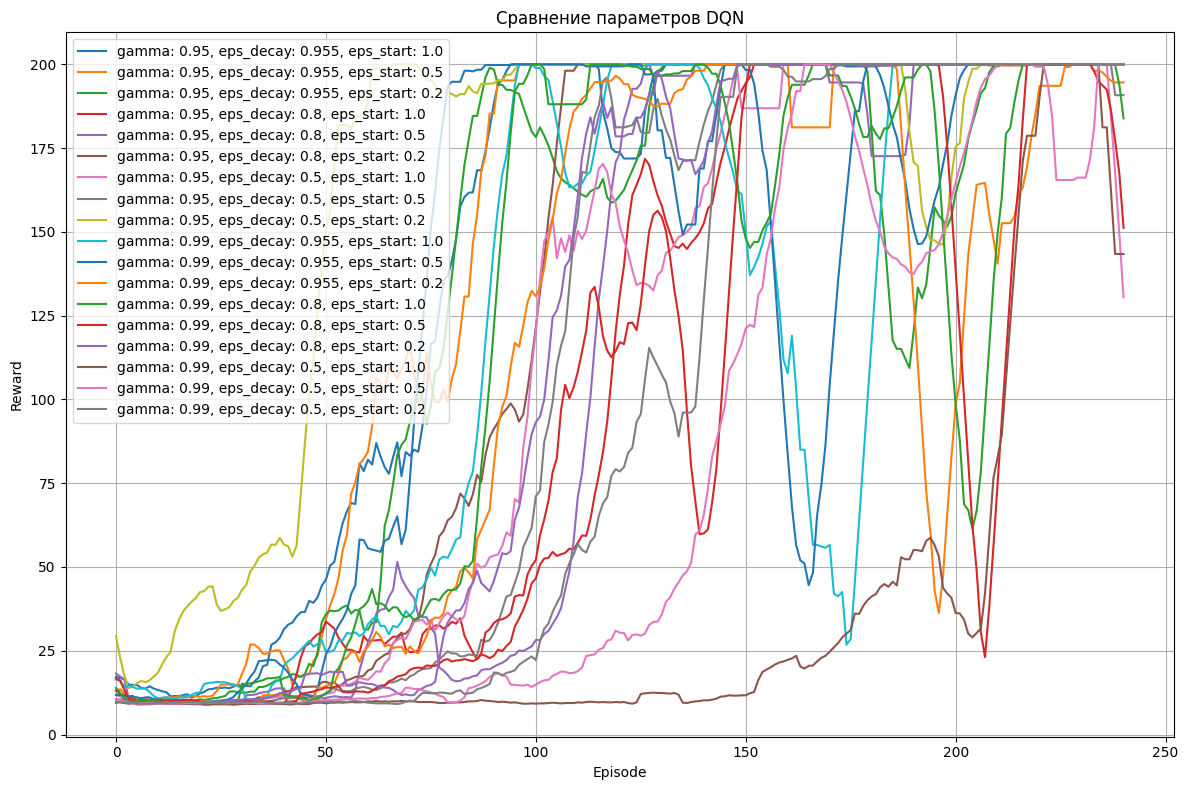

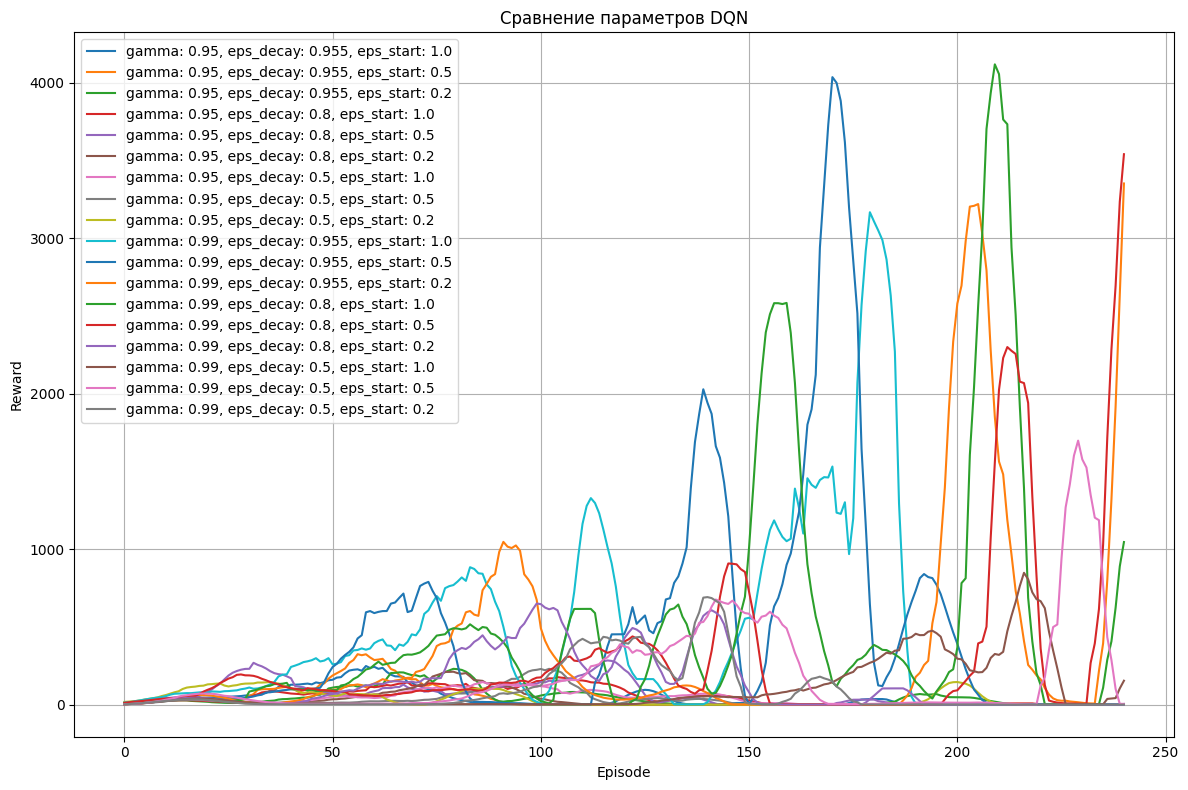

In [30]:
reward, loss = run_experiment(0, gamma_values, epsilon_decay_values, initial_epsilons)
plot_results(reward, 'reward')
plot_results(loss, 'loss')

In [32]:
reward, loss = run_experiment(1, gamma_values, epsilon_decay_values, initial_epsilons)


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:   0%|          | 0/250 [00:00<?, ?it/s]<ipython-input-14-c5929f1a6a00>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.tensor(state, dtype=torch.float32, device=self.device)
<ipython-input-14-c5929f1a6a00>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actions = torch.tensor(action, dtype=torch.long, device=self.device)
<ipython-input-14-c5929f1a6a00>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reward = torch.tensor(reward, dtype=torch.float32, device=self.device)
<i

Episode: 0, Reward: 17.0, Loss: 0.0


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:   5%|▌         | 13/250 [00:01<00:21, 11.20it/s]

Episode: 10, Reward: 26.0, Loss: 20.746871575713158


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:   8%|▊         | 21/250 [00:02<00:43,  5.26it/s]

Episode: 20, Reward: 53.0, Loss: 71.94753581285477


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  13%|█▎        | 32/250 [00:08<01:44,  2.10it/s]

Episode: 30, Reward: 139.0, Loss: 28.227529246360064


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  16%|█▋        | 41/250 [00:16<02:58,  1.17it/s]

Episode: 40, Reward: 45.0, Loss: 9.555575498379767


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  20%|██        | 51/250 [00:24<03:07,  1.06it/s]

Episode: 50, Reward: 200.0, Loss: 20.783797058276832


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  24%|██▍       | 61/250 [00:34<03:16,  1.04s/it]

Episode: 60, Reward: 200.0, Loss: 12.12062918394804


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  28%|██▊       | 71/250 [00:44<03:11,  1.07s/it]

Episode: 70, Reward: 200.0, Loss: 1.2637915903469548


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  33%|███▎      | 82/250 [00:54<01:35,  1.75it/s]

Episode: 80, Reward: 20.0, Loss: 3.4191324207931757


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  36%|███▋      | 91/250 [01:00<02:15,  1.17it/s]

Episode: 90, Reward: 188.0, Loss: 37.000191054306924


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  40%|████      | 101/250 [01:10<02:28,  1.00it/s]

Episode: 100, Reward: 197.0, Loss: 6.281461530830711


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  44%|████▍     | 111/250 [01:19<02:24,  1.04s/it]

Episode: 110, Reward: 200.0, Loss: 4.482931646518409


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  48%|████▊     | 121/250 [01:29<02:19,  1.08s/it]

Episode: 120, Reward: 161.0, Loss: 0.9665135340183042


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  52%|█████▏    | 131/250 [01:40<02:01,  1.02s/it]

Episode: 130, Reward: 200.0, Loss: 1.8959063247020822


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  56%|█████▋    | 141/250 [01:51<01:46,  1.02it/s]

Episode: 140, Reward: 167.0, Loss: 1.7098137954017147


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  60%|██████    | 151/250 [02:00<01:07,  1.47it/s]

Episode: 150, Reward: 31.0, Loss: 16.80180704034865


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  64%|██████▍   | 161/250 [02:08<01:45,  1.18s/it]

Episode: 160, Reward: 200.0, Loss: 12.07426950824447


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  68%|██████▊   | 171/250 [02:18<01:23,  1.06s/it]

Episode: 170, Reward: 191.0, Loss: 6.204246794455685


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  72%|███████▏  | 181/250 [02:29<01:09,  1.01s/it]

Episode: 180, Reward: 181.0, Loss: 4.717038293019868


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  76%|███████▋  | 191/250 [02:41<01:02,  1.07s/it]

Episode: 190, Reward: 200.0, Loss: 0.2977932127614622


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  80%|████████  | 201/250 [02:52<00:52,  1.08s/it]

Episode: 200, Reward: 200.0, Loss: 3.046545240395062


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  84%|████████▍ | 211/250 [02:58<00:26,  1.48it/s]

Episode: 210, Reward: 127.0, Loss: 54.276982836425304


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  88%|████████▊ | 221/250 [03:05<00:18,  1.58it/s]

Episode: 220, Reward: 134.0, Loss: 6.510324566159397


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  92%|█████████▏| 231/250 [03:13<00:17,  1.07it/s]

Episode: 230, Reward: 200.0, Loss: 7.840779688209295


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  96%|█████████▋| 241/250 [03:21<00:08,  1.09it/s]

Episode: 240, Reward: 200.0, Loss: 53.15421733260155


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:   2%|▏         | 6/250 [00:00<00:05, 48.54it/s]

Episode: 0, Reward: 10.0, Loss: 0.0


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:   4%|▍         | 11/250 [00:00<00:13, 17.11it/s]

Episode: 10, Reward: 10.0, Loss: 11.17031615972519


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:   8%|▊         | 21/250 [00:01<00:20, 11.23it/s]

Episode: 20, Reward: 10.0, Loss: 14.359384894371033


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  12%|█▏        | 31/250 [00:06<02:22,  1.54it/s]

Episode: 30, Reward: 200.0, Loss: 215.4276796579361


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  16%|█▋        | 41/250 [00:15<03:18,  1.05it/s]

Episode: 40, Reward: 170.0, Loss: 16.413009111303836


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  20%|██        | 51/250 [00:26<03:05,  1.07it/s]

Episode: 50, Reward: 172.0, Loss: 0.7754245082323905


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  24%|██▍       | 61/250 [00:36<03:05,  1.02it/s]

Episode: 60, Reward: 200.0, Loss: 2.401171993871685


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  28%|██▊       | 71/250 [00:47<03:14,  1.08s/it]

Episode: 70, Reward: 200.0, Loss: 0.4626386304589687


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  32%|███▏      | 81/250 [00:59<02:59,  1.06s/it]

Episode: 80, Reward: 200.0, Loss: 11.812622366473079


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  36%|███▋      | 91/250 [01:05<02:24,  1.10it/s]

Episode: 90, Reward: 200.0, Loss: 59.292774403467774


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  40%|████      | 101/250 [01:16<02:41,  1.09s/it]

Episode: 100, Reward: 200.0, Loss: 0.004184067925962154


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  44%|████▍     | 111/250 [01:28<02:40,  1.16s/it]

Episode: 110, Reward: 200.0, Loss: 0.0036089220448047854


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  48%|████▊     | 121/250 [01:38<01:30,  1.43it/s]

Episode: 120, Reward: 83.0, Loss: 35.49829163681716


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  52%|█████▏    | 131/250 [01:47<01:57,  1.01it/s]

Episode: 130, Reward: 159.0, Loss: 46.43435112666339


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  56%|█████▋    | 141/250 [01:57<02:22,  1.30s/it]

Episode: 140, Reward: 200.0, Loss: 0.0941797278373997


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  60%|██████    | 151/250 [02:08<01:23,  1.18it/s]

Episode: 150, Reward: 52.0, Loss: 17.195347445318475


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  64%|██████▍   | 161/250 [02:19<01:29,  1.00s/it]

Episode: 160, Reward: 178.0, Loss: 6.959172180038877


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  68%|██████▊   | 171/250 [02:28<01:06,  1.18it/s]

Episode: 170, Reward: 142.0, Loss: 5.591504258336499


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  72%|███████▏  | 181/250 [02:38<01:06,  1.03it/s]

Episode: 180, Reward: 151.0, Loss: 2.1395466923131607


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  76%|███████▋  | 191/250 [02:49<01:08,  1.16s/it]

Episode: 190, Reward: 195.0, Loss: 0.7979584151762538


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  80%|████████  | 201/250 [03:00<01:01,  1.25s/it]

Episode: 200, Reward: 200.0, Loss: 0.38283489644527435


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  84%|████████▍ | 211/250 [03:11<00:49,  1.27s/it]

Episode: 210, Reward: 177.0, Loss: 0.7279388999741059


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  88%|████████▊ | 221/250 [03:23<00:36,  1.24s/it]

Episode: 220, Reward: 200.0, Loss: 0.009131890832577483


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  92%|█████████▏| 231/250 [03:36<00:22,  1.20s/it]

Episode: 230, Reward: 200.0, Loss: 0.11439186382995103


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  96%|█████████▋| 241/250 [03:46<00:09,  1.06s/it]

Episode: 240, Reward: 195.0, Loss: 22.383051552809775


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:   3%|▎         | 8/250 [00:00<00:03, 65.73it/s]

Episode: 0, Reward: 12.0, Loss: 0.0
Episode: 10, Reward: 23.0, Loss: 25.90280055999756


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:   9%|▉         | 22/250 [00:01<00:12, 18.26it/s]

Episode: 20, Reward: 10.0, Loss: 10.538894593715668


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  12%|█▏        | 31/250 [00:02<00:22,  9.81it/s]

Episode: 30, Reward: 34.0, Loss: 45.791604578495026


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  17%|█▋        | 42/250 [00:06<01:05,  3.17it/s]

Episode: 40, Reward: 47.0, Loss: 50.68549397587776


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  20%|██        | 51/250 [00:13<02:58,  1.11it/s]

Episode: 50, Reward: 173.0, Loss: 3.316710547776893


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  24%|██▍       | 61/250 [00:25<03:34,  1.14s/it]

Episode: 60, Reward: 200.0, Loss: 0.1573706349299755


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  28%|██▊       | 71/250 [00:36<03:19,  1.11s/it]

Episode: 70, Reward: 188.0, Loss: 0.16893586415972095


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  33%|███▎      | 82/250 [00:46<01:53,  1.48it/s]

Episode: 80, Reward: 200.0, Loss: 165.77315231738612


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  36%|███▋      | 91/250 [00:56<03:06,  1.17s/it]

Episode: 90, Reward: 115.0, Loss: 35.27730067924131


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  40%|████      | 101/250 [01:05<02:35,  1.04s/it]

Episode: 100, Reward: 200.0, Loss: 0.09788186463629245


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  44%|████▍     | 111/250 [01:16<02:31,  1.09s/it]

Episode: 110, Reward: 200.0, Loss: 0.006836577100557406


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  48%|████▊     | 121/250 [01:28<02:24,  1.12s/it]

Episode: 120, Reward: 200.0, Loss: 0.7956334308701116


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  52%|█████▏    | 131/250 [01:39<01:45,  1.13it/s]

Episode: 130, Reward: 200.0, Loss: 42.7090467143571


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  56%|█████▋    | 141/250 [01:42<00:19,  5.73it/s]

Episode: 140, Reward: 11.0, Loss: 33.00010225921869


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  60%|██████    | 151/250 [01:46<00:41,  2.36it/s]

Episode: 150, Reward: 35.0, Loss: 80.18964721262455


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  64%|██████▍   | 161/250 [01:55<01:20,  1.10it/s]

Episode: 160, Reward: 200.0, Loss: 2.175390809716191


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  68%|██████▊   | 171/250 [02:07<01:25,  1.08s/it]

Episode: 170, Reward: 158.0, Loss: 0.6948238664772362


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  72%|███████▏  | 181/250 [02:17<01:09,  1.00s/it]

Episode: 180, Reward: 200.0, Loss: 0.39073475428449456


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  76%|███████▋  | 191/250 [02:29<01:06,  1.13s/it]

Episode: 190, Reward: 200.0, Loss: 0.2268887974023528


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  80%|████████  | 201/250 [02:40<00:48,  1.01it/s]

Episode: 200, Reward: 137.0, Loss: 19.634946736041456


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  84%|████████▍ | 211/250 [02:50<00:33,  1.15it/s]

Episode: 210, Reward: 115.0, Loss: 50.781204412691295


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  88%|████████▊ | 221/250 [02:57<00:23,  1.22it/s]

Episode: 220, Reward: 172.0, Loss: 17.545965187251568


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  92%|█████████▏| 231/250 [03:06<00:17,  1.10it/s]

Episode: 230, Reward: 200.0, Loss: 13.900088123511523


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  96%|█████████▋| 241/250 [03:12<00:03,  2.34it/s]

Episode: 240, Reward: 23.0, Loss: 24.150944866240025


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:   0%|          | 0/250 [00:00<?, ?it/s]

Episode: 0, Reward: 19.0, Loss: 0.0


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:   5%|▍         | 12/250 [00:00<00:12, 18.36it/s]

Episode: 10, Reward: 8.0, Loss: 21.28739881515503


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:   8%|▊         | 21/250 [00:01<00:33,  6.92it/s]

Episode: 20, Reward: 24.0, Loss: 39.215723022818565


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  12%|█▏        | 31/250 [00:07<02:55,  1.25it/s]

Episode: 30, Reward: 151.0, Loss: 40.262773759663105


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  16%|█▋        | 41/250 [00:16<03:10,  1.10it/s]

Episode: 40, Reward: 169.0, Loss: 15.541122546885163


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  20%|██        | 51/250 [00:27<03:27,  1.04s/it]

Episode: 50, Reward: 200.0, Loss: 8.670108095975593


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  24%|██▍       | 61/250 [00:39<03:25,  1.09s/it]

Episode: 60, Reward: 200.0, Loss: 15.930969792185351


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  28%|██▊       | 71/250 [00:50<03:25,  1.15s/it]

Episode: 70, Reward: 194.0, Loss: 0.5834649350726977


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  32%|███▏      | 81/250 [00:56<01:02,  2.72it/s]

Episode: 80, Reward: 52.0, Loss: 92.86318224295974


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  36%|███▋      | 91/250 [01:07<02:59,  1.13s/it]

Episode: 90, Reward: 200.0, Loss: 0.016143841695566152


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  40%|████      | 101/250 [01:17<01:40,  1.48it/s]

Episode: 100, Reward: 95.0, Loss: 170.98660988919437


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  44%|████▍     | 111/250 [01:26<02:26,  1.05s/it]

Episode: 110, Reward: 177.0, Loss: 57.19606255949475


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  48%|████▊     | 121/250 [01:33<01:23,  1.55it/s]

Episode: 120, Reward: 119.0, Loss: 87.57209944725037


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  52%|█████▏    | 130/250 [01:38<00:45,  2.65it/s]

Episode: 130, Reward: 16.0, Loss: 32.845447551459074


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  56%|█████▋    | 141/250 [01:47<01:57,  1.08s/it]

Episode: 140, Reward: 200.0, Loss: 7.0693274713121355


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  60%|██████    | 151/250 [01:57<01:34,  1.05it/s]

Episode: 150, Reward: 156.0, Loss: 13.423222392331809


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  64%|██████▍   | 161/250 [02:08<01:35,  1.07s/it]

Episode: 160, Reward: 198.0, Loss: 1.0375982000987278


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  68%|██████▊   | 171/250 [02:19<01:31,  1.15s/it]

Episode: 170, Reward: 200.0, Loss: 0.8693776491854805


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  72%|███████▏  | 181/250 [02:30<01:07,  1.02it/s]

Episode: 180, Reward: 153.0, Loss: 1.5576549627585337


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  76%|███████▋  | 191/250 [02:40<01:02,  1.05s/it]

Episode: 190, Reward: 172.0, Loss: 0.6677685445465613


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  80%|████████  | 201/250 [02:52<01:03,  1.30s/it]

Episode: 200, Reward: 200.0, Loss: 0.10941478201857535


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  84%|████████▍ | 211/250 [03:04<00:48,  1.24s/it]

Episode: 210, Reward: 200.0, Loss: 40.56047051935457


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  88%|████████▊ | 221/250 [03:15<00:35,  1.21s/it]

Episode: 220, Reward: 172.0, Loss: 0.618853682797635


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  92%|█████████▏| 231/250 [03:26<00:21,  1.15s/it]

Episode: 230, Reward: 177.0, Loss: 0.6888890161935706


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  96%|█████████▋| 241/250 [03:38<00:09,  1.10s/it]

Episode: 240, Reward: 200.0, Loss: 0.07645986582065234


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:   3%|▎         | 7/250 [00:00<00:03, 65.20it/s]

Episode: 0, Reward: 17.0, Loss: 0.0


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:   6%|▌         | 14/250 [00:00<00:08, 27.70it/s]

Episode: 10, Reward: 9.0, Loss: 15.349966406822205


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:   8%|▊         | 21/250 [00:00<00:11, 19.67it/s]

Episode: 20, Reward: 13.0, Loss: 27.415983736515045


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  13%|█▎        | 32/250 [00:02<00:23,  9.35it/s]

Episode: 30, Reward: 18.0, Loss: 59.7452978938818


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  16%|█▌        | 40/250 [00:02<00:20, 10.19it/s]

Episode: 40, Reward: 23.0, Loss: 38.934897661209106


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  20%|██        | 51/250 [00:05<00:30,  6.49it/s]

Episode: 50, Reward: 37.0, Loss: 93.32164829969406


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  24%|██▍       | 61/250 [00:10<01:32,  2.05it/s]

Episode: 60, Reward: 90.0, Loss: 66.74629831314087


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  28%|██▊       | 71/250 [00:18<02:53,  1.03it/s]

Episode: 70, Reward: 153.0, Loss: 20.473050380125642


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  32%|███▏      | 81/250 [00:26<02:35,  1.09it/s]

Episode: 80, Reward: 193.0, Loss: 23.56624215701595


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  36%|███▋      | 91/250 [00:38<02:55,  1.11s/it]

Episode: 90, Reward: 200.0, Loss: 0.9312489476287737


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  40%|████      | 101/250 [00:50<02:45,  1.11s/it]

Episode: 100, Reward: 200.0, Loss: 0.1458526691130828


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  44%|████▍     | 111/250 [01:02<02:35,  1.12s/it]

Episode: 110, Reward: 200.0, Loss: 0.06295397072972264


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  48%|████▊     | 120/250 [01:11<01:29,  1.45it/s]

Episode: 120, Reward: 14.0, Loss: 16.29372868128121


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  52%|█████▏    | 131/250 [01:13<00:39,  3.03it/s]

Episode: 130, Reward: 95.0, Loss: 33.3213930092752


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  56%|█████▋    | 141/250 [01:21<01:21,  1.34it/s]

Episode: 140, Reward: 120.0, Loss: 11.63354440080002


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  60%|██████    | 151/250 [01:29<01:20,  1.23it/s]

Episode: 150, Reward: 132.0, Loss: 1.097793631721288


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  64%|██████▍   | 161/250 [01:37<01:09,  1.29it/s]

Episode: 160, Reward: 136.0, Loss: 0.7094546402804554


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  68%|██████▊   | 171/250 [01:47<01:14,  1.06it/s]

Episode: 170, Reward: 159.0, Loss: 1.1958848230424337


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  72%|███████▏  | 181/250 [01:56<01:12,  1.05s/it]

Episode: 180, Reward: 138.0, Loss: 0.7877012707758695


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  76%|███████▋  | 191/250 [02:05<00:50,  1.16it/s]

Episode: 190, Reward: 159.0, Loss: 1.1096977253910154


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  80%|████████  | 201/250 [02:15<00:50,  1.02s/it]

Episode: 200, Reward: 200.0, Loss: 3.656231727945851


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  84%|████████▍ | 211/250 [02:23<00:34,  1.14it/s]

Episode: 210, Reward: 200.0, Loss: 59.91189028322697


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  88%|████████▊ | 221/250 [02:34<00:39,  1.36s/it]

Episode: 220, Reward: 177.0, Loss: 0.44688049727119505


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  92%|█████████▏| 231/250 [02:44<00:21,  1.12s/it]

Episode: 230, Reward: 200.0, Loss: 2.6884049645159394


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  96%|█████████▋| 241/250 [02:54<00:07,  1.27it/s]

Episode: 240, Reward: 144.0, Loss: 121.05771308764815


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:   3%|▎         | 8/250 [00:00<00:03, 69.04it/s]

Episode: 0, Reward: 10.0, Loss: 0.0
Episode: 10, Reward: 10.0, Loss: 15.641791939735413


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:   9%|▉         | 22/250 [00:01<00:13, 16.39it/s]

Episode: 20, Reward: 10.0, Loss: 17.74289733171463


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  13%|█▎        | 32/250 [00:01<00:12, 17.27it/s]

Episode: 30, Reward: 9.0, Loss: 9.262523174285889


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  17%|█▋        | 42/250 [00:02<00:16, 12.35it/s]

Episode: 40, Reward: 16.0, Loss: 40.555368304252625


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  21%|██        | 52/250 [00:03<00:16, 12.32it/s]

Episode: 50, Reward: 14.0, Loss: 28.385991275310516


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  25%|██▍       | 62/250 [00:04<00:30,  6.09it/s]

Episode: 60, Reward: 32.0, Loss: 13.300763055682182


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  29%|██▉       | 72/250 [00:06<00:27,  6.39it/s]

Episode: 70, Reward: 25.0, Loss: 14.296368688344955


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  32%|███▏      | 81/250 [00:09<00:50,  3.37it/s]

Episode: 80, Reward: 40.0, Loss: 20.207577042281628


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  36%|███▋      | 91/250 [00:11<00:44,  3.61it/s]

Episode: 90, Reward: 56.0, Loss: 10.93040594831109


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  40%|████      | 101/250 [00:18<01:43,  1.45it/s]

Episode: 100, Reward: 150.0, Loss: 52.0802297051996


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  44%|████▍     | 111/250 [00:26<01:42,  1.35it/s]

Episode: 110, Reward: 123.0, Loss: 21.60632621217519


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  48%|████▊     | 121/250 [00:34<02:04,  1.04it/s]

Episode: 120, Reward: 166.0, Loss: 1.4597195821115747


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  52%|█████▏    | 131/250 [00:44<01:47,  1.10it/s]

Episode: 130, Reward: 139.0, Loss: 1.3870029118843377


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  56%|█████▌    | 140/250 [00:50<00:46,  2.36it/s]

Episode: 140, Reward: 10.0, Loss: 4.211675703525543


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  60%|██████    | 151/250 [00:55<00:45,  2.17it/s]

Episode: 150, Reward: 167.0, Loss: 214.81429234147072


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  64%|██████▍   | 161/250 [01:04<01:22,  1.08it/s]

Episode: 160, Reward: 169.0, Loss: 2.670523110544309


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  68%|██████▊   | 171/250 [01:15<01:30,  1.15s/it]

Episode: 170, Reward: 200.0, Loss: 0.7195507820579223


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  72%|███████▏  | 181/250 [01:25<01:08,  1.01it/s]

Episode: 180, Reward: 145.0, Loss: 1.6918262175749987


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  76%|███████▋  | 191/250 [01:36<01:06,  1.13s/it]

Episode: 190, Reward: 200.0, Loss: 8.723177346400917


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  80%|████████  | 201/250 [01:45<00:48,  1.01it/s]

Episode: 200, Reward: 185.0, Loss: 1.1958564578962978


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  84%|████████▍ | 211/250 [01:55<00:36,  1.06it/s]

Episode: 210, Reward: 198.0, Loss: 0.8942541785072535


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  88%|████████▊ | 221/250 [02:03<00:21,  1.37it/s]

Episode: 220, Reward: 126.0, Loss: 0.7566848692949861


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  92%|█████████▏| 231/250 [02:11<00:15,  1.19it/s]

Episode: 230, Reward: 141.0, Loss: 1.5382737528998405


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  96%|█████████▋| 241/250 [02:21<00:07,  1.18it/s]

Episode: 240, Reward: 138.0, Loss: 0.08899801630468573


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:   3%|▎         | 7/250 [00:00<00:04, 52.49it/s]

Episode: 0, Reward: 20.0, Loss: 0.0


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:   5%|▌         | 13/250 [00:00<00:09, 23.78it/s]

Episode: 10, Reward: 12.0, Loss: 12.231740862131119


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:   9%|▉         | 23/250 [00:01<00:13, 16.79it/s]

Episode: 20, Reward: 15.0, Loss: 36.50984400510788


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  13%|█▎        | 33/250 [00:01<00:12, 17.26it/s]

Episode: 30, Reward: 9.0, Loss: 14.580930352210999


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  16%|█▋        | 41/250 [00:02<00:18, 11.35it/s]

Episode: 40, Reward: 51.0, Loss: 61.95905166864395


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  21%|██        | 53/250 [00:03<00:22,  8.59it/s]

Episode: 50, Reward: 34.0, Loss: 72.02299010753632


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  24%|██▍       | 61/250 [00:07<01:44,  1.81it/s]

Episode: 60, Reward: 121.0, Loss: 184.30394938588142


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  28%|██▊       | 71/250 [00:14<02:23,  1.25it/s]

Episode: 70, Reward: 192.0, Loss: 14.019062327221036


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  32%|███▏      | 81/250 [00:24<02:42,  1.04it/s]

Episode: 80, Reward: 165.0, Loss: 23.62881879415363


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  36%|███▋      | 91/250 [00:35<02:51,  1.08s/it]

Episode: 90, Reward: 194.0, Loss: 7.374902659328654


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  40%|████      | 101/250 [00:46<02:52,  1.16s/it]

Episode: 100, Reward: 200.0, Loss: 0.3613936114415992


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  44%|████▍     | 111/250 [00:56<02:33,  1.11s/it]

Episode: 110, Reward: 181.0, Loss: 5.9805350373499095


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  48%|████▊     | 121/250 [01:06<02:11,  1.02s/it]

Episode: 120, Reward: 195.0, Loss: 4.850958063616417


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  52%|█████▏    | 131/250 [01:17<02:05,  1.06s/it]

Episode: 130, Reward: 200.0, Loss: 0.19317980333289597


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  56%|█████▋    | 141/250 [01:28<02:01,  1.11s/it]

Episode: 140, Reward: 200.0, Loss: 0.07721799782302696


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  60%|██████    | 151/250 [01:35<01:26,  1.14it/s]

Episode: 150, Reward: 180.0, Loss: 89.99747603014112


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  64%|██████▍   | 161/250 [01:43<01:13,  1.21it/s]

Episode: 160, Reward: 158.0, Loss: 1.3589915750781074


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  68%|██████▊   | 171/250 [01:53<01:21,  1.03s/it]

Episode: 170, Reward: 183.0, Loss: 0.43984139896929264


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  72%|███████▏  | 181/250 [02:04<01:11,  1.04s/it]

Episode: 180, Reward: 181.0, Loss: 1.393727197078988


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  76%|███████▋  | 191/250 [02:15<01:06,  1.12s/it]

Episode: 190, Reward: 200.0, Loss: 0.147236949953367


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  80%|████████  | 201/250 [02:25<00:46,  1.06it/s]

Episode: 200, Reward: 158.0, Loss: 9.100622106809169


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  84%|████████▍ | 211/250 [02:34<00:38,  1.00it/s]

Episode: 210, Reward: 148.0, Loss: 0.7215501301980112


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  88%|████████▊ | 221/250 [02:44<00:27,  1.07it/s]

Episode: 220, Reward: 200.0, Loss: 0.9910191091767047


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  92%|█████████▏| 231/250 [02:54<00:18,  1.02it/s]

Episode: 230, Reward: 198.0, Loss: 1.9324150998145342


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  96%|█████████▋| 241/250 [03:05<00:09,  1.02s/it]

Episode: 240, Reward: 200.0, Loss: 0.10009676527261036


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:   3%|▎         | 8/250 [00:00<00:03, 67.01it/s]

Episode: 0, Reward: 16.0, Loss: 0.0
Episode: 10, Reward: 9.0, Loss: 12.965961813926697


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:   9%|▉         | 23/250 [00:01<00:11, 19.19it/s]

Episode: 20, Reward: 10.0, Loss: 7.010615020990372


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  13%|█▎        | 33/250 [00:01<00:12, 18.04it/s]

Episode: 30, Reward: 10.0, Loss: 18.129619121551514


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  18%|█▊        | 44/250 [00:02<00:14, 14.14it/s]

Episode: 40, Reward: 23.0, Loss: 50.38128623366356


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  21%|██        | 52/250 [00:03<00:15, 12.56it/s]

Episode: 50, Reward: 12.0, Loss: 26.264752745628357


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  24%|██▍       | 61/250 [00:05<00:52,  3.63it/s]

Episode: 60, Reward: 167.0, Loss: 169.2262510806322


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  28%|██▊       | 71/250 [00:14<02:53,  1.03it/s]

Episode: 70, Reward: 200.0, Loss: 3.149642110161949


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  32%|███▏      | 81/250 [00:25<02:50,  1.01s/it]

Episode: 80, Reward: 200.0, Loss: 75.68112069088966


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  36%|███▋      | 91/250 [00:33<01:47,  1.47it/s]

Episode: 90, Reward: 89.0, Loss: 46.50181012880057


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  40%|████      | 101/250 [00:40<01:33,  1.59it/s]

Episode: 100, Reward: 117.0, Loss: 95.14474487677217


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  44%|████▍     | 111/250 [00:47<02:14,  1.03it/s]

Episode: 110, Reward: 200.0, Loss: 163.88308288902044


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  48%|████▊     | 121/250 [00:57<02:13,  1.03s/it]

Episode: 120, Reward: 200.0, Loss: 91.21252032357734


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  52%|█████▏    | 131/250 [01:06<01:42,  1.16it/s]

Episode: 130, Reward: 158.0, Loss: 4.444496980402619


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  56%|█████▋    | 141/250 [01:12<01:15,  1.45it/s]

Episode: 140, Reward: 200.0, Loss: 153.40061529166996


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  60%|██████    | 151/250 [01:21<01:18,  1.25it/s]

Episode: 150, Reward: 140.0, Loss: 1.5650636458885856


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  64%|██████▍   | 161/250 [01:29<01:11,  1.24it/s]

Episode: 160, Reward: 141.0, Loss: 0.6627075168071315


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  68%|██████▊   | 171/250 [01:38<01:02,  1.25it/s]

Episode: 170, Reward: 129.0, Loss: 0.3460458750196267


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  72%|███████▏  | 181/250 [01:45<00:58,  1.19it/s]

Episode: 180, Reward: 127.0, Loss: 10.571599961491302


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  76%|███████▋  | 191/250 [01:54<00:44,  1.34it/s]

Episode: 190, Reward: 128.0, Loss: 0.6184702880564146


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  80%|████████  | 201/250 [02:02<00:41,  1.17it/s]

Episode: 200, Reward: 142.0, Loss: 3.6840183107415214


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  84%|████████▍ | 211/250 [02:12<00:38,  1.02it/s]

Episode: 210, Reward: 126.0, Loss: 20.64020114392042


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  88%|████████▊ | 221/250 [02:19<00:20,  1.40it/s]

Episode: 220, Reward: 120.0, Loss: 6.294781149365008


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  92%|█████████▏| 231/250 [02:27<00:16,  1.18it/s]

Episode: 230, Reward: 146.0, Loss: 0.6338269039115403


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  96%|█████████▋| 241/250 [02:37<00:08,  1.05it/s]

Episode: 240, Reward: 142.0, Loss: 0.2651635365036782


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:   3%|▎         | 8/250 [00:00<00:03, 68.01it/s]

Episode: 0, Reward: 11.0, Loss: 0.0
Episode: 10, Reward: 9.0, Loss: 13.566218078136444


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:   9%|▉         | 23/250 [00:00<00:10, 21.74it/s]

Episode: 20, Reward: 9.0, Loss: 6.237333059310913


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  13%|█▎        | 33/250 [00:01<00:12, 17.46it/s]

Episode: 30, Reward: 14.0, Loss: 28.56186068058014


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  16%|█▋        | 41/250 [00:02<00:23,  9.08it/s]

Episode: 40, Reward: 21.0, Loss: 41.3063448369503


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  20%|██        | 51/250 [00:05<00:58,  3.39it/s]

Episode: 50, Reward: 62.0, Loss: 44.55094841122627


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  24%|██▍       | 61/250 [00:07<00:54,  3.47it/s]

Episode: 60, Reward: 61.0, Loss: 44.42312519997358


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  28%|██▊       | 71/250 [00:12<01:31,  1.96it/s]

Episode: 70, Reward: 102.0, Loss: 8.15252374485135


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  32%|███▏      | 81/250 [00:19<01:42,  1.65it/s]

Episode: 80, Reward: 116.0, Loss: 22.729874335229397


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  36%|███▋      | 91/250 [00:25<01:40,  1.59it/s]

Episode: 90, Reward: 115.0, Loss: 8.681178331375122


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  40%|████      | 101/250 [00:32<01:42,  1.46it/s]

Episode: 100, Reward: 133.0, Loss: 0.7735329007264227


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  44%|████▍     | 111/250 [00:39<01:41,  1.36it/s]

Episode: 110, Reward: 137.0, Loss: 11.062404027674347


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  48%|████▊     | 121/250 [00:46<01:41,  1.27it/s]

Episode: 120, Reward: 195.0, Loss: 27.749944313429296


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  52%|█████▏    | 131/250 [00:55<01:53,  1.05it/s]

Episode: 130, Reward: 200.0, Loss: 1.0423567229299806


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  56%|█████▋    | 141/250 [01:02<01:25,  1.28it/s]

Episode: 140, Reward: 161.0, Loss: 1.8998134606517851


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  60%|██████    | 151/250 [01:10<01:10,  1.40it/s]

Episode: 150, Reward: 115.0, Loss: 3.204222023487091


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  64%|██████▍   | 161/250 [01:18<01:14,  1.19it/s]

Episode: 160, Reward: 129.0, Loss: 1.8250666699605063


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  68%|██████▊   | 171/250 [01:26<01:02,  1.27it/s]

Episode: 170, Reward: 200.0, Loss: 2.68918967875652


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  72%|███████▏  | 181/250 [01:34<00:58,  1.18it/s]

Episode: 180, Reward: 127.0, Loss: 1.7784581768792123


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  76%|███████▋  | 191/250 [01:42<00:55,  1.06it/s]

Episode: 190, Reward: 146.0, Loss: 4.480949534568936


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  80%|████████  | 201/250 [01:51<00:45,  1.08it/s]

Episode: 200, Reward: 147.0, Loss: 3.572177301859483


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  84%|████████▍ | 211/250 [02:02<00:40,  1.05s/it]

Episode: 210, Reward: 194.0, Loss: 8.835766850505024


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  88%|████████▊ | 221/250 [02:13<00:31,  1.09s/it]

Episode: 220, Reward: 200.0, Loss: 1.5304558909265324


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  92%|█████████▏| 231/250 [02:25<00:21,  1.15s/it]

Episode: 230, Reward: 200.0, Loss: 0.05452745584989316


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  96%|█████████▋| 241/250 [02:34<00:05,  1.53it/s]

Episode: 240, Reward: 45.0, Loss: 5.103892392478883


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:   2%|▏         | 4/250 [00:00<00:08, 30.11it/s]

Episode: 0, Reward: 14.0, Loss: 0.0


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:   5%|▍         | 12/250 [00:00<00:21, 11.07it/s]

Episode: 10, Reward: 38.0, Loss: 83.28123105317354


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:   9%|▉         | 22/250 [00:01<00:22, 10.33it/s]

Episode: 20, Reward: 21.0, Loss: 100.8575050830841


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  12%|█▏        | 31/250 [00:05<01:25,  2.56it/s]

Episode: 30, Reward: 93.0, Loss: 125.62552869319916


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  16%|█▋        | 41/250 [00:11<02:35,  1.34it/s]

Episode: 40, Reward: 163.0, Loss: 53.401310566812754


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  20%|██        | 51/250 [00:17<02:07,  1.56it/s]

Episode: 50, Reward: 120.0, Loss: 22.10606473311782


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  24%|██▍       | 61/250 [00:27<03:06,  1.01it/s]

Episode: 60, Reward: 122.0, Loss: 13.069617806002498


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  28%|██▊       | 71/250 [00:36<02:45,  1.08it/s]

Episode: 70, Reward: 146.0, Loss: 22.64168256893754


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  32%|███▏      | 81/250 [00:45<02:29,  1.13it/s]

Episode: 80, Reward: 159.0, Loss: 3.0354847395792603


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  36%|███▋      | 91/250 [00:54<01:50,  1.44it/s]

Episode: 90, Reward: 68.0, Loss: 438.911917373538


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  40%|████      | 101/250 [01:03<02:25,  1.02it/s]

Episode: 100, Reward: 200.0, Loss: 25.43640665151179


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  44%|████▍     | 111/250 [01:11<01:52,  1.24it/s]

Episode: 110, Reward: 144.0, Loss: 56.89693292975426


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  48%|████▊     | 121/250 [01:20<01:52,  1.14it/s]

Episode: 120, Reward: 172.0, Loss: 105.21202479675412


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  52%|█████▏    | 131/250 [01:32<02:10,  1.10s/it]

Episode: 130, Reward: 200.0, Loss: 29.79638392198831


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  56%|█████▋    | 141/250 [01:38<01:00,  1.81it/s]

Episode: 140, Reward: 156.0, Loss: 2505.8381132483482


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  60%|██████    | 151/250 [01:47<01:32,  1.07it/s]

Episode: 150, Reward: 171.0, Loss: 54.86482723429799


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  64%|██████▍   | 161/250 [01:58<01:30,  1.02s/it]

Episode: 160, Reward: 189.0, Loss: 5.2805757210589945


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  68%|██████▊   | 171/250 [02:09<01:24,  1.07s/it]

Episode: 170, Reward: 191.0, Loss: 17.19707027077675


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  72%|███████▏  | 181/250 [02:20<01:15,  1.10s/it]

Episode: 180, Reward: 200.0, Loss: 4.974718878045678


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  76%|███████▋  | 191/250 [02:32<01:06,  1.13s/it]

Episode: 190, Reward: 200.0, Loss: 1.7599425571970642


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  80%|████████  | 201/250 [02:44<00:57,  1.18s/it]

Episode: 200, Reward: 200.0, Loss: 1.8926382338395342


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  84%|████████▍ | 211/250 [02:56<00:45,  1.17s/it]

Episode: 210, Reward: 200.0, Loss: 0.3884113380627241


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  88%|████████▊ | 221/250 [03:08<00:34,  1.18s/it]

Episode: 220, Reward: 200.0, Loss: 0.9389048571465537


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  92%|█████████▏| 231/250 [03:19<00:22,  1.20s/it]

Episode: 230, Reward: 200.0, Loss: 0.3882124034425942


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  96%|█████████▋| 241/250 [03:31<00:10,  1.19s/it]

Episode: 240, Reward: 200.0, Loss: 0.40933821650833124


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:   3%|▎         | 7/250 [00:00<00:04, 51.01it/s]

Episode: 0, Reward: 13.0, Loss: 0.0


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:   5%|▌         | 13/250 [00:00<00:12, 18.58it/s]

Episode: 10, Reward: 12.0, Loss: 18.71282058954239


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:   9%|▉         | 22/250 [00:01<00:13, 17.52it/s]

Episode: 20, Reward: 10.0, Loss: 99.0553469657898


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  14%|█▎        | 34/250 [00:01<00:12, 17.63it/s]

Episode: 30, Reward: 10.0, Loss: 126.62680339813232


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  17%|█▋        | 43/250 [00:02<00:12, 16.93it/s]

Episode: 40, Reward: 9.0, Loss: 79.18570923805237


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  20%|██        | 51/250 [00:06<01:35,  2.09it/s]

Episode: 50, Reward: 143.0, Loss: 247.4979561343789


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  24%|██▍       | 61/250 [00:14<02:26,  1.29it/s]

Episode: 60, Reward: 149.0, Loss: 13.836732423398644


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  28%|██▊       | 71/250 [00:24<02:49,  1.06it/s]

Episode: 70, Reward: 168.0, Loss: 23.17383776465431


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  32%|███▏      | 81/250 [00:33<03:02,  1.08s/it]

Episode: 80, Reward: 200.0, Loss: 44.8136025024578


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  36%|███▋      | 91/250 [00:41<02:05,  1.27it/s]

Episode: 90, Reward: 200.0, Loss: 461.3100880160928


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  40%|████      | 101/250 [00:52<02:36,  1.05s/it]

Episode: 100, Reward: 200.0, Loss: 158.10091205127537


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  44%|████▍     | 111/250 [01:03<02:37,  1.13s/it]

Episode: 110, Reward: 200.0, Loss: 1.4234161539934576


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  48%|████▊     | 121/250 [01:15<02:28,  1.15s/it]

Episode: 120, Reward: 200.0, Loss: 1.0707785972335842


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  52%|█████▏    | 131/250 [01:27<02:21,  1.19s/it]

Episode: 130, Reward: 200.0, Loss: 0.8715680530949612


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  56%|█████▋    | 141/250 [01:39<02:16,  1.25s/it]

Episode: 140, Reward: 200.0, Loss: 0.8123040662903804


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  60%|██████    | 151/250 [01:51<01:57,  1.19s/it]

Episode: 150, Reward: 200.0, Loss: 0.7195014335557062


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  65%|██████▍   | 162/250 [01:58<00:28,  3.12it/s]

Episode: 160, Reward: 21.0, Loss: 446.5238529294729


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  68%|██████▊   | 171/250 [02:06<01:12,  1.09it/s]

Episode: 170, Reward: 167.0, Loss: 10.00106674991548


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  72%|███████▏  | 181/250 [02:16<01:13,  1.06s/it]

Episode: 180, Reward: 200.0, Loss: 14.233046106994152


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  76%|███████▋  | 191/250 [02:28<01:11,  1.22s/it]

Episode: 190, Reward: 199.0, Loss: 2.980498872231692


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  80%|████████  | 201/250 [02:40<00:59,  1.22s/it]

Episode: 200, Reward: 200.0, Loss: 2.80588610493578


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  84%|████████▍ | 211/250 [02:52<00:48,  1.25s/it]

Episode: 210, Reward: 200.0, Loss: 0.5463893948763143


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  88%|████████▊ | 221/250 [03:04<00:36,  1.25s/it]

Episode: 220, Reward: 200.0, Loss: 0.5676289722614456


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  92%|█████████▏| 231/250 [03:14<00:15,  1.26it/s]

Episode: 230, Reward: 95.0, Loss: 544.5175958853215


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  96%|█████████▋| 241/250 [03:22<00:09,  1.02s/it]

Episode: 240, Reward: 200.0, Loss: 197.0000064894557


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:   3%|▎         | 8/250 [00:00<00:04, 60.41it/s]

Episode: 0, Reward: 10.0, Loss: 0.0
Episode: 10, Reward: 9.0, Loss: 15.748922109603882


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:   9%|▉         | 22/250 [00:01<00:14, 15.88it/s]

Episode: 20, Reward: 10.0, Loss: 19.206794381141663


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  13%|█▎        | 32/250 [00:01<00:14, 15.18it/s]

Episode: 30, Reward: 10.0, Loss: 38.36308479309082


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  16%|█▋        | 41/250 [00:03<00:33,  6.31it/s]

Episode: 40, Reward: 44.0, Loss: 82.54002052545547


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  20%|██        | 51/250 [00:12<03:13,  1.03it/s]

Episode: 50, Reward: 171.0, Loss: 130.72972639463842


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  24%|██▍       | 61/250 [00:23<02:52,  1.10it/s]

Episode: 60, Reward: 132.0, Loss: 60.53626266727224


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  28%|██▊       | 71/250 [00:33<02:51,  1.04it/s]

Episode: 70, Reward: 119.0, Loss: 4.112923777662218


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  32%|███▏      | 81/250 [00:41<02:36,  1.08it/s]

Episode: 80, Reward: 200.0, Loss: 25.500619994476438


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  36%|███▋      | 91/250 [00:48<02:23,  1.10it/s]

Episode: 90, Reward: 156.0, Loss: 236.46418464928865


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  40%|████      | 101/250 [00:59<02:26,  1.02it/s]

Episode: 100, Reward: 155.0, Loss: 70.1104330252856


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  44%|████▍     | 111/250 [01:10<02:30,  1.08s/it]

Episode: 110, Reward: 200.0, Loss: 54.85398758016527


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  48%|████▊     | 121/250 [01:21<02:37,  1.22s/it]

Episode: 120, Reward: 200.0, Loss: 0.9074529679783154


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  52%|█████▏    | 131/250 [01:33<02:23,  1.21s/it]

Episode: 130, Reward: 200.0, Loss: 38.6328371562995


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  56%|█████▋    | 141/250 [01:45<02:16,  1.25s/it]

Episode: 140, Reward: 200.0, Loss: 1.1468293580401223


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  60%|██████    | 151/250 [01:57<02:04,  1.26s/it]

Episode: 150, Reward: 200.0, Loss: 0.7956408122117864


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  64%|██████▍   | 161/250 [02:08<01:31,  1.02s/it]

Episode: 160, Reward: 46.0, Loss: 1.0441929414519109


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  68%|██████▊   | 171/250 [02:13<00:57,  1.37it/s]

Episode: 170, Reward: 200.0, Loss: 620.8911193907261


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  72%|███████▏  | 181/250 [02:25<01:17,  1.12s/it]

Episode: 180, Reward: 200.0, Loss: 6.385213975794613


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  76%|███████▋  | 191/250 [02:35<00:56,  1.04it/s]

Episode: 190, Reward: 146.0, Loss: 61.31370847672224


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  80%|████████  | 201/250 [02:42<00:31,  1.54it/s]

Episode: 200, Reward: 63.0, Loss: 423.7403466105461


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  84%|████████▍ | 211/250 [02:54<00:43,  1.11s/it]

Episode: 210, Reward: 200.0, Loss: 3.5858243964612484


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  88%|████████▊ | 221/250 [03:06<00:33,  1.15s/it]

Episode: 220, Reward: 200.0, Loss: 3.0162729606963694


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  92%|█████████▏| 231/250 [03:18<00:22,  1.17s/it]

Episode: 230, Reward: 200.0, Loss: 2.0816277470439672


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  96%|█████████▋| 241/250 [03:30<00:10,  1.17s/it]

Episode: 240, Reward: 200.0, Loss: 0.5103031532489695


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:   2%|▏         | 6/250 [00:00<00:04, 49.73it/s]

Episode: 0, Reward: 13.0, Loss: 0.0


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:   4%|▍         | 11/250 [00:00<00:09, 25.31it/s]

Episode: 10, Reward: 10.0, Loss: 20.85397058725357


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:   8%|▊         | 21/250 [00:00<00:10, 20.98it/s]

Episode: 20, Reward: 9.0, Loss: 27.500351428985596


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  13%|█▎        | 33/250 [00:01<00:14, 15.16it/s]

Episode: 30, Reward: 26.0, Loss: 77.73071026802063


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  16%|█▋        | 41/250 [00:02<00:27,  7.62it/s]

Episode: 40, Reward: 18.0, Loss: 35.839619636535645


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  20%|██        | 51/250 [00:05<00:59,  3.34it/s]

Episode: 50, Reward: 67.0, Loss: 57.81742173433304


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  24%|██▍       | 61/250 [00:10<01:49,  1.72it/s]

Episode: 60, Reward: 110.0, Loss: 21.048118133097887


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  28%|██▊       | 71/250 [00:18<02:27,  1.22it/s]

Episode: 70, Reward: 138.0, Loss: 38.586192946881056


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  32%|███▏      | 81/250 [00:26<02:20,  1.21it/s]

Episode: 80, Reward: 173.0, Loss: 15.92978133354336


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  36%|███▋      | 91/250 [00:36<02:28,  1.07it/s]

Episode: 90, Reward: 200.0, Loss: 18.251746638678014


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  40%|████      | 101/250 [00:43<02:03,  1.20it/s]

Episode: 100, Reward: 155.0, Loss: 1095.0977131575346


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  44%|████▍     | 111/250 [00:53<02:15,  1.03it/s]

Episode: 110, Reward: 143.0, Loss: 447.803683295846


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  48%|████▊     | 121/250 [01:00<01:04,  2.01it/s]

Episode: 120, Reward: 26.0, Loss: 359.10948015749454


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  52%|█████▏    | 131/250 [01:12<02:07,  1.08s/it]

Episode: 130, Reward: 200.0, Loss: 1.688484383164905


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  56%|█████▋    | 141/250 [01:24<02:12,  1.21s/it]

Episode: 140, Reward: 200.0, Loss: 0.8467088390607387


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  60%|██████    | 151/250 [01:36<01:49,  1.11s/it]

Episode: 150, Reward: 148.0, Loss: 2.583272713352926


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  64%|██████▍   | 161/250 [01:40<00:23,  3.74it/s]

Episode: 160, Reward: 27.0, Loss: 431.4952402114868


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  68%|██████▊   | 171/250 [01:50<01:21,  1.04s/it]

Episode: 170, Reward: 200.0, Loss: 6.176217895874288


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  72%|███████▏  | 181/250 [02:02<01:18,  1.13s/it]

Episode: 180, Reward: 200.0, Loss: 0.1793128947265359


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  76%|███████▋  | 191/250 [02:13<01:05,  1.12s/it]

Episode: 190, Reward: 200.0, Loss: 0.487690151332572


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  80%|████████  | 201/250 [02:25<00:54,  1.11s/it]

Episode: 200, Reward: 200.0, Loss: 0.9610098572229617


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  84%|████████▍ | 211/250 [02:37<00:43,  1.12s/it]

Episode: 210, Reward: 200.0, Loss: 0.26973889394139405


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  88%|████████▊ | 221/250 [02:48<00:31,  1.09s/it]

Episode: 220, Reward: 200.0, Loss: 36.22102871770039


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  92%|█████████▏| 231/250 [03:00<00:20,  1.07s/it]

Episode: 230, Reward: 155.0, Loss: 22.868287558027077


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  96%|█████████▋| 241/250 [03:12<00:10,  1.15s/it]

Episode: 240, Reward: 200.0, Loss: 0.1127952898023068


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:   4%|▎         | 9/250 [00:00<00:03, 63.20it/s]

Episode: 0, Reward: 13.0, Loss: 0.0
Episode: 10, Reward: 12.0, Loss: 23.74068397283554


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:   9%|▉         | 23/250 [00:00<00:09, 23.84it/s]

Episode: 20, Reward: 10.0, Loss: 22.66429352760315


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  13%|█▎        | 32/250 [00:01<00:12, 17.93it/s]

Episode: 30, Reward: 13.0, Loss: 33.308385610580444


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  17%|█▋        | 42/250 [00:02<00:23,  8.90it/s]

Episode: 40, Reward: 31.0, Loss: 77.75241076946259


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  20%|██        | 51/250 [00:04<00:49,  4.04it/s]

Episode: 50, Reward: 45.0, Loss: 50.62931898236275


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  24%|██▍       | 61/250 [00:08<01:30,  2.08it/s]

Episode: 60, Reward: 88.0, Loss: 90.16111272573471


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  28%|██▊       | 71/250 [00:15<01:53,  1.58it/s]

Episode: 70, Reward: 108.0, Loss: 35.17946155555546


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  32%|███▏      | 81/250 [00:22<02:10,  1.30it/s]

Episode: 80, Reward: 121.0, Loss: 4.622663215268403


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  36%|███▋      | 91/250 [00:30<01:50,  1.43it/s]

Episode: 90, Reward: 127.0, Loss: 239.11358277499676


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  40%|████      | 101/250 [00:38<01:54,  1.30it/s]

Episode: 100, Reward: 137.0, Loss: 5.346545237116516


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  44%|████▍     | 111/250 [00:45<01:41,  1.36it/s]

Episode: 110, Reward: 123.0, Loss: 3.827502957545221


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  48%|████▊     | 121/250 [00:55<01:56,  1.10it/s]

Episode: 120, Reward: 117.0, Loss: 2.498241617809981


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  52%|█████▏    | 131/250 [01:04<01:48,  1.09it/s]

Episode: 130, Reward: 173.0, Loss: 13.38997911196202


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  56%|█████▋    | 141/250 [01:14<01:59,  1.10s/it]

Episode: 140, Reward: 173.0, Loss: 4.150741868186742


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  60%|██████    | 151/250 [01:26<02:02,  1.24s/it]

Episode: 150, Reward: 200.0, Loss: 2.989262202056125


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  64%|██████▍   | 161/250 [01:38<01:53,  1.27s/it]

Episode: 160, Reward: 200.0, Loss: 11.904375723563135


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  68%|██████▊   | 171/250 [01:50<01:43,  1.31s/it]

Episode: 170, Reward: 200.0, Loss: 3.2203345024609007


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  72%|███████▏  | 181/250 [02:02<01:32,  1.34s/it]

Episode: 180, Reward: 200.0, Loss: 1.3938854387379251


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  76%|███████▋  | 191/250 [02:13<01:16,  1.29s/it]

Episode: 190, Reward: 200.0, Loss: 0.6929788218403701


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  80%|████████  | 201/250 [02:25<01:00,  1.24s/it]

Episode: 200, Reward: 200.0, Loss: 0.8235742670076434


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  84%|████████▍ | 211/250 [02:37<00:48,  1.23s/it]

Episode: 210, Reward: 200.0, Loss: 0.44649573336937465


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  88%|████████▊ | 221/250 [02:49<00:34,  1.19s/it]

Episode: 220, Reward: 200.0, Loss: 0.5447792493359884


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  92%|█████████▏| 231/250 [03:01<00:22,  1.16s/it]

Episode: 230, Reward: 200.0, Loss: 0.34443476880915114


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  96%|█████████▋| 241/250 [03:13<00:10,  1.21s/it]

Episode: 240, Reward: 200.0, Loss: 0.30236416591651505


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:   4%|▎         | 9/250 [00:00<00:04, 59.46it/s]

Episode: 0, Reward: 11.0, Loss: 0.0
Episode: 10, Reward: 9.0, Loss: 16.420891523361206


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:   9%|▉         | 22/250 [00:01<00:11, 19.18it/s]

Episode: 20, Reward: 10.0, Loss: 22.65497636795044


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  12%|█▏        | 31/250 [00:01<00:17, 12.52it/s]

Episode: 30, Reward: 10.0, Loss: 21.623347282409668


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  16%|█▋        | 41/250 [00:03<00:35,  5.93it/s]

Episode: 40, Reward: 19.0, Loss: 43.51469224691391


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  20%|██        | 51/250 [00:06<01:14,  2.68it/s]

Episode: 50, Reward: 87.0, Loss: 138.58845803141594


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  24%|██▍       | 61/250 [00:13<02:09,  1.46it/s]

Episode: 60, Reward: 116.0, Loss: 23.383375803008676


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  28%|██▊       | 71/250 [00:19<01:57,  1.53it/s]

Episode: 70, Reward: 140.0, Loss: 4.295455398969352


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  32%|███▏      | 81/250 [00:28<02:50,  1.01s/it]

Episode: 80, Reward: 155.0, Loss: 55.33596927020699


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  36%|███▋      | 91/250 [00:39<03:12,  1.21s/it]

Episode: 90, Reward: 200.0, Loss: 31.51511355675757


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  40%|████      | 101/250 [00:51<03:04,  1.24s/it]

Episode: 100, Reward: 200.0, Loss: 2.6613847161643207


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  44%|████▍     | 111/250 [01:01<02:01,  1.14it/s]

Episode: 110, Reward: 146.0, Loss: 472.68823459744453


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  48%|████▊     | 121/250 [01:13<02:22,  1.10s/it]

Episode: 120, Reward: 200.0, Loss: 5.616418710909784


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  52%|█████▏    | 131/250 [01:24<02:13,  1.12s/it]

Episode: 130, Reward: 200.0, Loss: 2.269465366611257


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  56%|█████▋    | 141/250 [01:36<02:03,  1.13s/it]

Episode: 140, Reward: 200.0, Loss: 6.713578638853505


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  60%|██████    | 151/250 [01:48<01:48,  1.10s/it]

Episode: 150, Reward: 200.0, Loss: 1.587183888652362


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  64%|██████▍   | 161/250 [01:59<01:39,  1.12s/it]

Episode: 160, Reward: 200.0, Loss: 0.9006700409809127


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  69%|██████▉   | 173/250 [02:10<00:32,  2.38it/s]

Episode: 170, Reward: 33.0, Loss: 62.237500581890345


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  72%|███████▏  | 181/250 [02:11<00:16,  4.12it/s]

Episode: 180, Reward: 11.0, Loss: 172.5622901916504


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  76%|███████▋  | 191/250 [02:22<01:01,  1.04s/it]

Episode: 190, Reward: 200.0, Loss: 17.13799594528973


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  80%|████████  | 201/250 [02:33<00:52,  1.07s/it]

Episode: 200, Reward: 200.0, Loss: 18.148969281464815


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  84%|████████▍ | 211/250 [02:44<00:45,  1.17s/it]

Episode: 210, Reward: 200.0, Loss: 20.233349346090108


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  88%|████████▊ | 221/250 [02:56<00:35,  1.22s/it]

Episode: 220, Reward: 200.0, Loss: 10.59785423707217


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  92%|█████████▏| 231/250 [03:07<00:24,  1.26s/it]

Episode: 230, Reward: 200.0, Loss: 2.408555341302417


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  96%|█████████▋| 241/250 [03:20<00:11,  1.31s/it]

Episode: 240, Reward: 200.0, Loss: 5.729689017403871


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:   2%|▏         | 5/250 [00:00<00:06, 40.25it/s]

Episode: 0, Reward: 33.0, Loss: 0.0


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:   4%|▍         | 10/250 [00:00<00:18, 12.83it/s]

Episode: 10, Reward: 15.0, Loss: 36.82998442649841


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  10%|▉         | 24/250 [00:02<00:17, 12.88it/s]

Episode: 20, Reward: 18.0, Loss: 51.05554723739624


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  13%|█▎        | 32/250 [00:02<00:21, 10.28it/s]

Episode: 30, Reward: 30.0, Loss: 112.55007195472717


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  16%|█▋        | 41/250 [00:05<00:44,  4.74it/s]

Episode: 40, Reward: 28.0, Loss: 45.545662343502045


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  20%|██        | 51/250 [00:12<03:10,  1.04it/s]

Episode: 50, Reward: 200.0, Loss: 78.56268502958119


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  24%|██▍       | 61/250 [00:21<02:37,  1.20it/s]

Episode: 60, Reward: 141.0, Loss: 23.30709788016975


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  28%|██▊       | 71/250 [00:31<02:22,  1.26it/s]

Episode: 70, Reward: 108.0, Loss: 3.563867117278278


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  32%|███▏      | 81/250 [00:40<02:46,  1.01it/s]

Episode: 80, Reward: 184.0, Loss: 22.372080638073385


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  36%|███▋      | 91/250 [00:51<03:14,  1.22s/it]

Episode: 90, Reward: 200.0, Loss: 24.610214468091726


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  40%|████      | 101/250 [01:03<03:14,  1.31s/it]

Episode: 100, Reward: 200.0, Loss: 2.3419348334427923


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  44%|████▍     | 111/250 [01:15<03:04,  1.33s/it]

Episode: 110, Reward: 200.0, Loss: 1.598188355565071


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  48%|████▊     | 121/250 [01:27<02:49,  1.31s/it]

Episode: 120, Reward: 200.0, Loss: 1.2961840267962543


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  52%|█████▏    | 131/250 [01:39<02:40,  1.35s/it]

Episode: 130, Reward: 200.0, Loss: 0.8745362441695761


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  56%|█████▋    | 141/250 [01:52<02:27,  1.35s/it]

Episode: 140, Reward: 200.0, Loss: 0.7512771651890944


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  60%|██████    | 151/250 [01:56<00:36,  2.74it/s]

Episode: 150, Reward: 113.0, Loss: 1391.962520956993


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  64%|██████▍   | 161/250 [02:07<01:37,  1.10s/it]

Episode: 160, Reward: 200.0, Loss: 39.868719851598144


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  68%|██████▊   | 171/250 [02:19<01:32,  1.17s/it]

Episode: 170, Reward: 200.0, Loss: 11.0410431381315


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  72%|███████▏  | 181/250 [02:30<01:24,  1.22s/it]

Episode: 180, Reward: 200.0, Loss: 5.274680987000465


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  76%|███████▋  | 191/250 [02:42<01:11,  1.21s/it]

Episode: 190, Reward: 200.0, Loss: 2.2400043189991266


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  80%|████████  | 201/250 [02:54<01:00,  1.24s/it]

Episode: 200, Reward: 200.0, Loss: 3.1519534322433174


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  84%|████████▍ | 211/250 [03:06<00:49,  1.26s/it]

Episode: 210, Reward: 200.0, Loss: 0.5794529466656968


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  88%|████████▊ | 221/250 [03:18<00:37,  1.28s/it]

Episode: 220, Reward: 200.0, Loss: 9.50707043102011


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  92%|█████████▏| 231/250 [03:30<00:24,  1.30s/it]

Episode: 230, Reward: 200.0, Loss: 0.7441046528983861


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  96%|█████████▋| 241/250 [03:42<00:12,  1.34s/it]

Episode: 240, Reward: 200.0, Loss: 0.19592050126811955


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:   3%|▎         | 8/250 [00:00<00:04, 58.26it/s]

Episode: 0, Reward: 11.0, Loss: 0.0


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:   6%|▌         | 14/250 [00:00<00:08, 27.89it/s]

Episode: 10, Reward: 10.0, Loss: 17.68828558921814


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  10%|▉         | 24/250 [00:01<00:12, 18.02it/s]

Episode: 20, Reward: 10.0, Loss: 24.564011573791504


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  12%|█▏        | 31/250 [00:01<00:16, 13.47it/s]

Episode: 30, Reward: 13.0, Loss: 55.51719868183136


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  16%|█▋        | 41/250 [00:03<00:47,  4.43it/s]

Episode: 40, Reward: 57.0, Loss: 81.54666694998741


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  20%|██        | 51/250 [00:08<01:50,  1.80it/s]

Episode: 50, Reward: 101.0, Loss: 40.030362352728844


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  24%|██▍       | 61/250 [00:17<02:57,  1.06it/s]

Episode: 60, Reward: 200.0, Loss: 6.0063424007967114


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  29%|██▉       | 72/250 [00:25<01:16,  2.33it/s]

Episode: 70, Reward: 65.0, Loss: 613.7838693484664


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  32%|███▏      | 81/250 [00:27<00:47,  3.52it/s]

Episode: 80, Reward: 91.0, Loss: 1077.368047952652


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  36%|███▋      | 91/250 [00:36<02:47,  1.06s/it]

Episode: 90, Reward: 157.0, Loss: 171.69162171334028


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  40%|████      | 101/250 [00:47<02:56,  1.19s/it]

Episode: 100, Reward: 200.0, Loss: 7.2903948412276804


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  44%|████▍     | 111/250 [00:58<02:18,  1.00it/s]

Episode: 110, Reward: 172.0, Loss: 39.22006743308157


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  48%|████▊     | 121/250 [01:07<01:41,  1.28it/s]

Episode: 120, Reward: 121.0, Loss: 24.871816501021385


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  52%|█████▏    | 131/250 [01:17<01:56,  1.02it/s]

Episode: 130, Reward: 198.0, Loss: 89.41059629246593


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  56%|█████▋    | 141/250 [01:29<02:09,  1.19s/it]

Episode: 140, Reward: 200.0, Loss: 2.759207049617544


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  60%|██████    | 151/250 [01:41<02:00,  1.22s/it]

Episode: 150, Reward: 200.0, Loss: 2.0080667696893215


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  64%|██████▍   | 161/250 [01:52<01:46,  1.19s/it]

Episode: 160, Reward: 200.0, Loss: 4.636237570084631


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  68%|██████▊   | 171/250 [02:04<01:36,  1.22s/it]

Episode: 170, Reward: 200.0, Loss: 2.1828605215996504


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  72%|███████▏  | 181/250 [02:17<01:28,  1.28s/it]

Episode: 180, Reward: 200.0, Loss: 0.7747796632174868


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  76%|███████▋  | 191/250 [02:29<01:14,  1.26s/it]

Episode: 190, Reward: 200.0, Loss: 1.560837009397801


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  80%|████████  | 201/250 [02:41<01:01,  1.25s/it]

Episode: 200, Reward: 200.0, Loss: 3.4662022406701


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  84%|████████▍ | 211/250 [02:53<00:49,  1.28s/it]

Episode: 210, Reward: 200.0, Loss: 0.8018375994288363


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  88%|████████▊ | 221/250 [03:05<00:37,  1.30s/it]

Episode: 220, Reward: 200.0, Loss: 0.35564785650058184


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  93%|█████████▎| 233/250 [03:18<00:12,  1.40it/s]

Episode: 230, Reward: 182.0, Loss: 1.3028920600372658


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  96%|█████████▋| 241/250 [03:24<00:08,  1.04it/s]

Episode: 240, Reward: 200.0, Loss: 120.56943585723639


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:   4%|▎         | 9/250 [00:00<00:04, 60.16it/s]

Episode: 0, Reward: 10.0, Loss: 0.0
Episode: 10, Reward: 22.0, Loss: 33.57226413488388


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:   9%|▉         | 23/250 [00:01<00:11, 20.41it/s]

Episode: 20, Reward: 11.0, Loss: 28.522823572158813


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  13%|█▎        | 32/250 [00:01<00:15, 13.69it/s]

Episode: 30, Reward: 9.0, Loss: 16.44259738922119


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  16%|█▋        | 41/250 [00:03<00:36,  5.70it/s]

Episode: 40, Reward: 47.0, Loss: 83.28108811378479


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  20%|██        | 51/250 [00:09<02:01,  1.63it/s]

Episode: 50, Reward: 129.0, Loss: 205.74862357974052


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  24%|██▍       | 61/250 [00:15<01:44,  1.80it/s]

Episode: 60, Reward: 92.0, Loss: 93.34817523509264


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  28%|██▊       | 71/250 [00:21<01:34,  1.89it/s]

Episode: 70, Reward: 117.0, Loss: 17.3782446263358


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  32%|███▏      | 81/250 [00:29<02:27,  1.15it/s]

Episode: 80, Reward: 166.0, Loss: 97.63701554760337


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  36%|███▋      | 91/250 [00:38<02:35,  1.02it/s]

Episode: 90, Reward: 200.0, Loss: 94.94371992349625


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  40%|████      | 101/250 [00:50<02:51,  1.15s/it]

Episode: 100, Reward: 200.0, Loss: 1.678816965664737


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  44%|████▍     | 111/250 [01:02<02:39,  1.15s/it]

Episode: 110, Reward: 200.0, Loss: 1.466048212707392


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  48%|████▊     | 121/250 [01:14<02:26,  1.14s/it]

Episode: 120, Reward: 200.0, Loss: 1.1908217747331946


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  52%|█████▏    | 131/250 [01:24<01:35,  1.25it/s]

Episode: 130, Reward: 30.0, Loss: 237.47719045286067


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  56%|█████▋    | 141/250 [01:34<02:01,  1.11s/it]

Episode: 140, Reward: 200.0, Loss: 6.367121466901153


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  60%|██████    | 151/250 [01:46<01:58,  1.19s/it]

Episode: 150, Reward: 200.0, Loss: 4.159971141838469


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  64%|██████▍   | 161/250 [01:58<01:49,  1.23s/it]

Episode: 160, Reward: 200.0, Loss: 1.1149593837035354


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  68%|██████▊   | 171/250 [02:09<01:38,  1.24s/it]

Episode: 170, Reward: 200.0, Loss: 1.1237491301144473


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  72%|███████▏  | 181/250 [02:21<01:26,  1.25s/it]

Episode: 180, Reward: 200.0, Loss: 0.4689075990609126


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  76%|███████▋  | 191/250 [02:33<01:15,  1.28s/it]

Episode: 190, Reward: 200.0, Loss: 0.48415524910524255


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  80%|████████  | 201/250 [02:43<00:41,  1.19it/s]

Episode: 200, Reward: 72.0, Loss: 25.822740018367767


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  84%|████████▍ | 211/250 [02:49<00:31,  1.22it/s]

Episode: 210, Reward: 200.0, Loss: 289.3786677867174


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  88%|████████▊ | 221/250 [03:00<00:33,  1.14s/it]

Episode: 220, Reward: 200.0, Loss: 4.73739447403932


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  92%|█████████▏| 231/250 [03:12<00:22,  1.16s/it]

Episode: 230, Reward: 200.0, Loss: 9.529097147053108


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  96%|█████████▋| 241/250 [03:23<00:10,  1.20s/it]

Episode: 240, Reward: 200.0, Loss: 8.08435454685241


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2: 100%|██████████| 250/250 [03:34<00:00,  1.17it/s]


TypeError: 'str' object cannot be interpreted as an integer

<Figure size 1200x800 with 0 Axes>

In [33]:
def plot_results(results, name, smooth_window=10):
    plt.figure(figsize=(12, 8))
    for label, rewards in results.items():
        smoothed = np.convolve(rewards, np.ones(smooth_window)/smooth_window, mode='valid')
        plt.plot(smoothed, label=label)

    plt.xlabel('Episode')
    plt.ylabel(name)
    plt.title('Сравнение параметров DQN')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


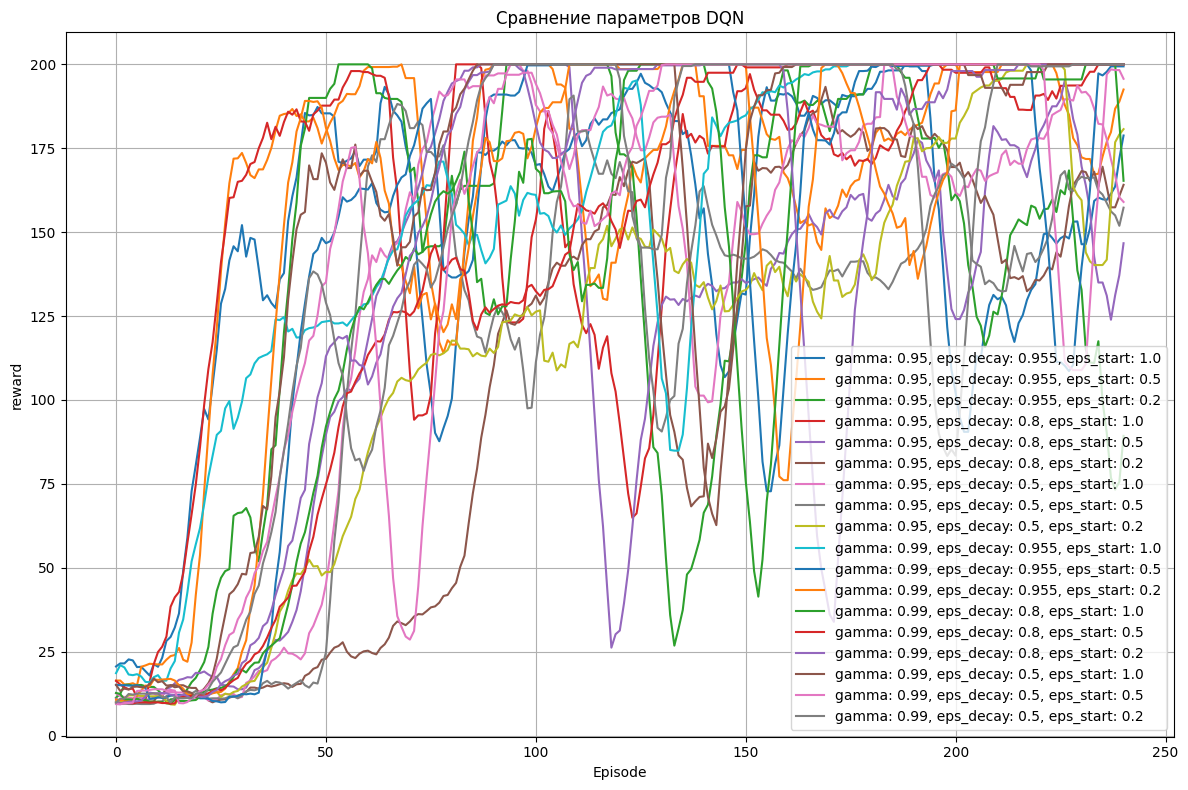

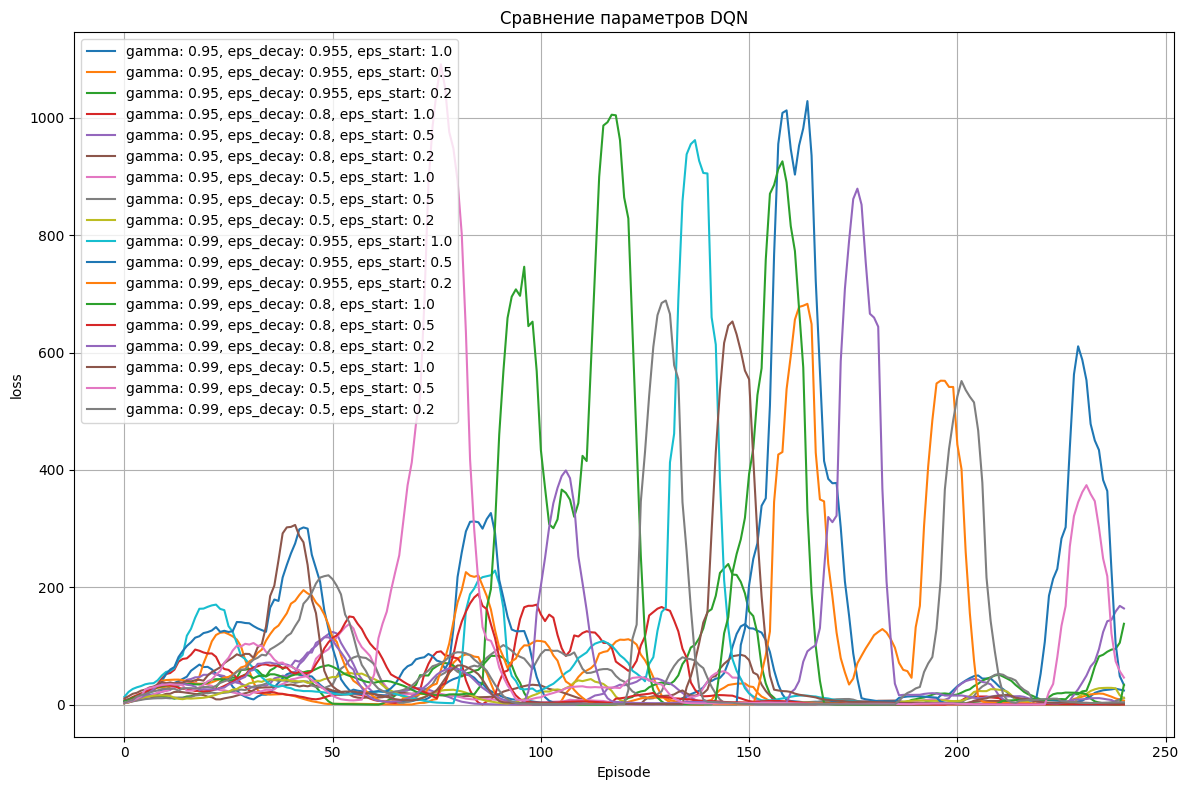

In [34]:
plot_results(reward, 'reward')
plot_results(loss, 'loss')

gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:   0%|          | 0/250 [00:00<?, ?it/s]<ipython-input-14-c5929f1a6a00>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.tensor(state, dtype=torch.float32, device=self.device)
<ipython-input-14-c5929f1a6a00>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actions = torch.tensor(action, dtype=torch.long, device=self.device)
<ipython-input-14-c5929f1a6a00>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reward = torch.tensor(reward, dtype=torch.float32, device=self.device)
<i

Episode: 0, Reward: 12.0, Loss: 0.0
Episode: 10, Reward: 10.0, Loss: 10.386353492736816


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  12%|█▏        | 29/250 [00:00<00:04, 48.87it/s]

Episode: 20, Reward: 13.0, Loss: 29.74177360534668


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  16%|█▌        | 40/250 [00:00<00:04, 50.51it/s]

Episode: 30, Reward: 10.0, Loss: 48.72089886665344
Episode: 40, Reward: 8.0, Loss: 41.68464541435242


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  23%|██▎       | 58/250 [00:01<00:03, 50.03it/s]

Episode: 50, Reward: 10.0, Loss: 35.97412300109863
Episode: 60, Reward: 13.0, Loss: 33.05265438556671


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  30%|██▉       | 74/250 [00:01<00:03, 45.74it/s]

Episode: 70, Reward: 12.0, Loss: 35.16360503435135


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  34%|███▍      | 85/250 [00:01<00:03, 44.83it/s]

Episode: 80, Reward: 9.0, Loss: 32.31703233718872


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  38%|███▊      | 95/250 [00:01<00:03, 42.32it/s]

Episode: 90, Reward: 10.0, Loss: 31.844312727451324


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  42%|████▏     | 105/250 [00:02<00:03, 43.19it/s]

Episode: 100, Reward: 12.0, Loss: 24.984324514865875


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  46%|████▌     | 115/250 [00:02<00:03, 38.39it/s]

Episode: 110, Reward: 11.0, Loss: 26.466195821762085


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  48%|████▊     | 119/250 [00:02<00:04, 32.41it/s]

Episode: 120, Reward: 26.0, Loss: 66.5000701546669


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  53%|█████▎    | 133/250 [00:04<00:09, 12.43it/s]

Episode: 130, Reward: 82.0, Loss: 227.35067968070507


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  56%|█████▋    | 141/250 [00:04<00:10, 10.59it/s]

Episode: 140, Reward: 65.0, Loss: 215.26950347423553


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  62%|██████▏   | 154/250 [00:06<00:06, 14.28it/s]

Episode: 150, Reward: 31.0, Loss: 113.07871207594872


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  66%|██████▋   | 166/250 [00:06<00:03, 24.23it/s]

Episode: 160, Reward: 19.0, Loss: 89.01086950302124


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  69%|██████▉   | 172/250 [00:06<00:04, 18.46it/s]

Episode: 170, Reward: 36.0, Loss: 161.5646330192685


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  74%|███████▎  | 184/250 [00:07<00:03, 18.96it/s]

Episode: 180, Reward: 12.0, Loss: 44.4236496090889


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  77%|███████▋  | 192/250 [00:08<00:04, 13.41it/s]

Episode: 190, Reward: 34.0, Loss: 187.9237613081932


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  81%|████████  | 202/250 [00:09<00:05,  9.34it/s]

Episode: 200, Reward: 64.0, Loss: 275.5278722643852


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  84%|████████▍ | 211/250 [00:10<00:06,  5.59it/s]

Episode: 210, Reward: 83.0, Loss: 140.62676670402288


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  89%|████████▉ | 222/250 [00:13<00:06,  4.42it/s]

Episode: 220, Reward: 147.0, Loss: 163.1787717975676


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  92%|█████████▏| 231/250 [00:17<00:07,  2.71it/s]

Episode: 230, Reward: 200.0, Loss: 122.97206202708185


gamma: 0.95, eps_decay: 0.955, eps_start: 1.0:  96%|█████████▋| 241/250 [00:20<00:03,  2.58it/s]

Episode: 240, Reward: 200.0, Loss: 1.2415046186652035


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:   4%|▍         | 11/250 [00:00<00:02, 98.45it/s]

Episode: 0, Reward: 9.0, Loss: 0.0
Episode: 10, Reward: 9.0, Loss: 8.754914820194244


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  11%|█         | 28/250 [00:00<00:04, 55.29it/s]

Episode: 20, Reward: 9.0, Loss: 25.55683660507202
Episode: 30, Reward: 9.0, Loss: 38.745869636535645


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  18%|█▊        | 46/250 [00:00<00:03, 51.89it/s]

Episode: 40, Reward: 8.0, Loss: 28.635831832885742


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  23%|██▎       | 58/250 [00:01<00:04, 47.46it/s]

Episode: 50, Reward: 11.0, Loss: 20.60648250579834


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  27%|██▋       | 68/250 [00:01<00:04, 44.31it/s]

Episode: 60, Reward: 11.0, Loss: 18.785267412662506


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  31%|███       | 78/250 [00:01<00:04, 41.38it/s]

Episode: 70, Reward: 9.0, Loss: 39.78489601612091


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  35%|███▌      | 88/250 [00:01<00:03, 40.67it/s]

Episode: 80, Reward: 10.0, Loss: 27.98197066783905


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  39%|███▉      | 97/250 [00:02<00:03, 38.97it/s]

Episode: 90, Reward: 13.0, Loss: 30.448570489883423


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  42%|████▏     | 105/250 [00:02<00:03, 38.13it/s]

Episode: 100, Reward: 14.0, Loss: 29.341791331768036


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  47%|████▋     | 117/250 [00:02<00:03, 34.21it/s]

Episode: 110, Reward: 17.0, Loss: 51.424602925777435


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  50%|█████     | 125/250 [00:02<00:03, 33.99it/s]

Episode: 120, Reward: 18.0, Loss: 45.67944633960724


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  55%|█████▍    | 137/250 [00:03<00:03, 32.17it/s]

Episode: 130, Reward: 15.0, Loss: 36.16136962175369


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  58%|█████▊    | 145/250 [00:03<00:03, 30.26it/s]

Episode: 140, Reward: 19.0, Loss: 32.576798141002655


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  62%|██████▏   | 155/250 [00:03<00:03, 26.79it/s]

Episode: 150, Reward: 16.0, Loss: 10.302690982818604


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  66%|██████▌   | 164/250 [00:04<00:03, 26.85it/s]

Episode: 160, Reward: 17.0, Loss: 6.568408042192459


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  70%|██████▉   | 174/250 [00:04<00:03, 24.38it/s]

Episode: 170, Reward: 31.0, Loss: 12.750126779079437


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  73%|███████▎  | 183/250 [00:05<00:03, 22.17it/s]

Episode: 180, Reward: 26.0, Loss: 6.588557317852974


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  78%|███████▊  | 194/250 [00:05<00:03, 16.71it/s]

Episode: 190, Reward: 71.0, Loss: 15.10163551941514


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  82%|████████▏ | 205/250 [00:06<00:02, 21.16it/s]

Episode: 200, Reward: 19.0, Loss: 64.61076946556568


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  86%|████████▌ | 214/250 [00:06<00:01, 22.80it/s]

Episode: 210, Reward: 30.0, Loss: 109.8333690315485


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  89%|████████▉ | 223/250 [00:07<00:01, 17.81it/s]

Episode: 220, Reward: 55.0, Loss: 145.7690021842718


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  93%|█████████▎| 233/250 [00:07<00:01, 16.83it/s]

Episode: 230, Reward: 21.0, Loss: 43.38674768805504


gamma: 0.95, eps_decay: 0.955, eps_start: 0.5:  97%|█████████▋| 243/250 [00:08<00:00, 10.31it/s]

Episode: 240, Reward: 68.0, Loss: 43.22370122373104


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:   4%|▎         | 9/250 [00:00<00:03, 76.85it/s]

Episode: 0, Reward: 14.0, Loss: 0.0
Episode: 10, Reward: 13.0, Loss: 11.462900936603546


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  11%|█         | 27/250 [00:00<00:05, 38.88it/s]

Episode: 20, Reward: 10.0, Loss: 19.34065079689026


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  15%|█▍        | 37/250 [00:00<00:05, 38.68it/s]

Episode: 30, Reward: 9.0, Loss: 28.797473669052124


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  18%|█▊        | 45/250 [00:01<00:05, 36.06it/s]

Episode: 40, Reward: 10.0, Loss: 25.4878591299057


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  23%|██▎       | 58/250 [00:01<00:05, 37.66it/s]

Episode: 50, Reward: 10.0, Loss: 13.600180506706238


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  26%|██▋       | 66/250 [00:01<00:05, 35.37it/s]

Episode: 60, Reward: 9.0, Loss: 4.490468144416809


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  30%|██▉       | 74/250 [00:02<00:05, 30.82it/s]

Episode: 70, Reward: 9.0, Loss: 2.7226605266332626


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  34%|███▍      | 85/250 [00:02<00:05, 30.81it/s]

Episode: 80, Reward: 14.0, Loss: 6.829790025949478


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  40%|███▉      | 99/250 [00:02<00:04, 36.66it/s]

Episode: 90, Reward: 9.0, Loss: 12.888414919376373


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  41%|████      | 103/250 [00:02<00:04, 34.56it/s]

Episode: 100, Reward: 15.0, Loss: 35.30484348535538


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  46%|████▋     | 116/250 [00:03<00:05, 25.46it/s]

Episode: 110, Reward: 19.0, Loss: 90.1478590965271


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  50%|█████     | 126/250 [00:03<00:04, 28.72it/s]

Episode: 120, Reward: 14.0, Loss: 65.41815614700317


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  54%|█████▍    | 136/250 [00:04<00:04, 28.25it/s]

Episode: 130, Reward: 17.0, Loss: 88.12263643741608


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  57%|█████▋    | 143/250 [00:04<00:03, 27.82it/s]

Episode: 140, Reward: 19.0, Loss: 97.78140950202942


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  61%|██████    | 152/250 [00:04<00:04, 21.18it/s]

Episode: 150, Reward: 27.0, Loss: 108.5508237183094


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  66%|██████▌   | 164/250 [00:05<00:04, 17.53it/s]

Episode: 160, Reward: 57.0, Loss: 197.29407995939255


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  69%|██████▉   | 173/250 [00:06<00:04, 17.17it/s]

Episode: 170, Reward: 16.0, Loss: 36.08284029364586


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  73%|███████▎  | 183/250 [00:06<00:04, 13.47it/s]

Episode: 180, Reward: 28.0, Loss: 66.71496543288231


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  77%|███████▋  | 192/250 [00:08<00:07,  8.25it/s]

Episode: 190, Reward: 46.0, Loss: 89.55764091014862


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  82%|████████▏ | 205/250 [00:09<00:02, 16.53it/s]

Episode: 200, Reward: 19.0, Loss: 47.555502116680145


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  86%|████████▌ | 215/250 [00:09<00:01, 19.07it/s]

Episode: 210, Reward: 24.0, Loss: 72.36942188441753


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  88%|████████▊ | 221/250 [00:10<00:02, 14.38it/s]

Episode: 220, Reward: 45.0, Loss: 111.26425318419933


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  92%|█████████▏| 231/250 [00:14<00:09,  2.09it/s]

Episode: 230, Reward: 200.0, Loss: 1.6370397512800992


gamma: 0.95, eps_decay: 0.955, eps_start: 0.2:  96%|█████████▋| 241/250 [00:18<00:03,  2.43it/s]

Episode: 240, Reward: 200.0, Loss: 271.1111899744719


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:   3%|▎         | 8/250 [00:00<00:03, 76.24it/s]

Episode: 0, Reward: 18.0, Loss: 0.0
Episode: 10, Reward: 9.0, Loss: 9.376972138881683


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  12%|█▏        | 29/250 [00:00<00:04, 54.24it/s]

Episode: 20, Reward: 10.0, Loss: 23.6234347820282
Episode: 30, Reward: 9.0, Loss: 31.935864686965942


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  19%|█▉        | 47/250 [00:00<00:03, 52.33it/s]

Episode: 40, Reward: 9.0, Loss: 21.01918113231659
Episode: 50, Reward: 10.0, Loss: 11.70541226863861


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  26%|██▌       | 65/250 [00:01<00:03, 48.92it/s]

Episode: 60, Reward: 9.0, Loss: 7.872444748878479


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  30%|███       | 75/250 [00:01<00:04, 40.62it/s]

Episode: 70, Reward: 12.0, Loss: 8.150363981723785


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  34%|███▎      | 84/250 [00:01<00:06, 27.65it/s]

Episode: 80, Reward: 53.0, Loss: 127.64456948637962


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  36%|███▋      | 91/250 [00:02<00:07, 21.85it/s]

Episode: 90, Reward: 26.0, Loss: 77.05590784549713


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  41%|████      | 103/250 [00:03<00:09, 15.30it/s]

Episode: 100, Reward: 26.0, Loss: 98.091193318367


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  45%|████▌     | 113/250 [00:04<00:12, 11.32it/s]

Episode: 110, Reward: 31.0, Loss: 172.19208252429962


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  49%|████▉     | 122/250 [00:05<00:16,  7.79it/s]

Episode: 120, Reward: 49.0, Loss: 168.60391683131456


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  53%|█████▎    | 132/250 [00:06<00:15,  7.72it/s]

Episode: 130, Reward: 79.0, Loss: 218.5844540670514


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  57%|█████▋    | 142/250 [00:07<00:10,  9.87it/s]

Episode: 140, Reward: 32.0, Loss: 111.89766239374876


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  61%|██████    | 152/250 [00:08<00:07, 12.59it/s]

Episode: 150, Reward: 53.0, Loss: 156.0220560580492


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  64%|██████▍   | 161/250 [00:09<00:06, 12.79it/s]

Episode: 160, Reward: 52.0, Loss: 105.8081235140562


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  69%|██████▉   | 173/250 [00:10<00:06, 11.82it/s]

Episode: 170, Reward: 38.0, Loss: 51.743085980415344


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  73%|███████▎  | 183/250 [00:11<00:04, 15.14it/s]

Episode: 180, Reward: 28.0, Loss: 22.710857391357422


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  77%|███████▋  | 193/250 [00:11<00:04, 13.61it/s]

Episode: 190, Reward: 36.0, Loss: 29.07040388137102


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  80%|████████  | 201/250 [00:12<00:04, 11.93it/s]

Episode: 200, Reward: 38.0, Loss: 14.378311712294817


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  84%|████████▍ | 211/250 [00:16<00:17,  2.24it/s]

Episode: 210, Reward: 200.0, Loss: 6.904600817710161


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  88%|████████▊ | 221/250 [00:20<00:09,  3.08it/s]

Episode: 220, Reward: 140.0, Loss: 195.86431623250246


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  92%|█████████▏| 231/250 [00:24<00:07,  2.70it/s]

Episode: 230, Reward: 162.0, Loss: 16.83806692576036


gamma: 0.95, eps_decay: 0.8, eps_start: 1.0:  96%|█████████▋| 241/250 [00:27<00:03,  2.93it/s]

Episode: 240, Reward: 120.0, Loss: 108.56583755649626


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:   4%|▍         | 11/250 [00:00<00:02, 98.33it/s]

Episode: 0, Reward: 9.0, Loss: 0.0
Episode: 10, Reward: 10.0, Loss: 10.28008246421814


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  12%|█▏        | 29/250 [00:00<00:03, 61.46it/s]

Episode: 20, Reward: 10.0, Loss: 21.169694423675537
Episode: 30, Reward: 8.0, Loss: 30.66840434074402


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  19%|█▉        | 48/250 [00:00<00:03, 51.53it/s]

Episode: 40, Reward: 10.0, Loss: 29.736843943595886


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  24%|██▍       | 60/250 [00:01<00:03, 51.62it/s]

Episode: 50, Reward: 10.0, Loss: 18.63515293598175
Episode: 60, Reward: 10.0, Loss: 7.22034215927124


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  31%|███       | 77/250 [00:01<00:03, 49.12it/s]

Episode: 70, Reward: 10.0, Loss: 3.236607775092125


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  35%|███▍      | 87/250 [00:01<00:03, 42.87it/s]

Episode: 80, Reward: 11.0, Loss: 2.6513241678476334


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  39%|███▉      | 97/250 [00:01<00:03, 40.56it/s]

Episode: 90, Reward: 13.0, Loss: 3.8001819401979446


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  42%|████▏     | 106/250 [00:02<00:03, 39.67it/s]

Episode: 100, Reward: 14.0, Loss: 24.067200034856796


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  44%|████▍     | 110/250 [00:02<00:04, 32.11it/s]

Episode: 110, Reward: 16.0, Loss: 21.11264818906784


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  52%|█████▏    | 129/250 [00:03<00:03, 33.78it/s]

Episode: 120, Reward: 10.0, Loss: 23.757741808891296


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  56%|█████▌    | 139/250 [00:03<00:02, 39.40it/s]

Episode: 130, Reward: 9.0, Loss: 33.431388676166534


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  58%|█████▊    | 144/250 [00:03<00:02, 41.09it/s]

Episode: 140, Reward: 11.0, Loss: 43.78194439411163


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  62%|██████▏   | 154/250 [00:03<00:02, 39.23it/s]

Episode: 150, Reward: 10.0, Loss: 30.3779296875


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  65%|██████▌   | 163/250 [00:04<00:04, 18.65it/s]

Episode: 160, Reward: 21.0, Loss: 60.085225224494934


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  69%|██████▉   | 172/250 [00:04<00:04, 17.99it/s]

Episode: 170, Reward: 19.0, Loss: 59.51214897632599


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  73%|███████▎  | 183/250 [00:05<00:03, 17.95it/s]

Episode: 180, Reward: 26.0, Loss: 94.21716380119324


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  78%|███████▊  | 194/250 [00:06<00:03, 16.28it/s]

Episode: 190, Reward: 37.0, Loss: 132.9995944350958


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  82%|████████▏ | 204/250 [00:07<00:02, 16.14it/s]

Episode: 200, Reward: 44.0, Loss: 216.31843516230583


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  85%|████████▍ | 212/250 [00:07<00:02, 13.73it/s]

Episode: 210, Reward: 41.0, Loss: 179.71157151460648


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  89%|████████▉ | 222/250 [00:08<00:02, 12.27it/s]

Episode: 220, Reward: 48.0, Loss: 239.12694764137268


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  92%|█████████▏| 231/250 [00:10<00:03,  6.04it/s]

Episode: 230, Reward: 44.0, Loss: 78.3186528980732


gamma: 0.95, eps_decay: 0.8, eps_start: 0.5:  97%|█████████▋| 242/250 [00:11<00:01,  7.99it/s]

Episode: 240, Reward: 60.0, Loss: 94.58954343944788


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:   4%|▍         | 10/250 [00:00<00:02, 88.71it/s]

Episode: 0, Reward: 10.0, Loss: 0.0
Episode: 10, Reward: 10.0, Loss: 9.392690598964691


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  10%|█         | 26/250 [00:00<00:03, 59.21it/s]

Episode: 20, Reward: 10.0, Loss: 21.49188983440399
Episode: 30, Reward: 9.0, Loss: 31.123866319656372


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  20%|██        | 51/250 [00:00<00:03, 52.49it/s]

Episode: 40, Reward: 10.0, Loss: 37.00773894786835
Episode: 50, Reward: 8.0, Loss: 19.535053372383118


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  28%|██▊       | 69/250 [00:01<00:03, 51.88it/s]

Episode: 60, Reward: 10.0, Loss: 18.16001808643341
Episode: 70, Reward: 9.0, Loss: 8.296714723110199


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  35%|███▍      | 87/250 [00:01<00:03, 50.84it/s]

Episode: 80, Reward: 10.0, Loss: 6.906392157077789


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  39%|███▉      | 98/250 [00:01<00:03, 46.77it/s]

Episode: 90, Reward: 10.0, Loss: 5.065788835287094


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  43%|████▎     | 108/250 [00:02<00:03, 45.48it/s]

Episode: 100, Reward: 9.0, Loss: 4.590617626905441


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  48%|████▊     | 119/250 [00:02<00:02, 46.93it/s]

Episode: 110, Reward: 8.0, Loss: 2.3762694373726845


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  52%|█████▏    | 129/250 [00:02<00:02, 47.38it/s]

Episode: 120, Reward: 10.0, Loss: 2.042711079120636


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  56%|█████▌    | 139/250 [00:02<00:02, 45.54it/s]

Episode: 130, Reward: 9.0, Loss: 2.15215452760458


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  60%|█████▉    | 149/250 [00:02<00:02, 45.46it/s]

Episode: 140, Reward: 11.0, Loss: 3.662418156862259


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  64%|██████▎   | 159/250 [00:03<00:02, 45.00it/s]

Episode: 150, Reward: 11.0, Loss: 4.173850044608116


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  68%|██████▊   | 169/250 [00:03<00:01, 42.42it/s]

Episode: 160, Reward: 13.0, Loss: 5.588485315442085


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  70%|██████▉   | 174/250 [00:03<00:01, 39.05it/s]

Episode: 170, Reward: 14.0, Loss: 11.73682752251625


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  75%|███████▍  | 187/250 [00:04<00:01, 34.17it/s]

Episode: 180, Reward: 10.0, Loss: 10.448428511619568


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  78%|███████▊  | 195/250 [00:04<00:01, 32.14it/s]

Episode: 190, Reward: 27.0, Loss: 58.65065485239029


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  81%|████████  | 202/250 [00:04<00:02, 23.80it/s]

Episode: 200, Reward: 35.0, Loss: 98.4141675233841


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  86%|████████▌ | 214/250 [00:05<00:01, 23.09it/s]

Episode: 210, Reward: 18.0, Loss: 119.45180583000183


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  89%|████████▉ | 223/250 [00:05<00:01, 21.64it/s]

Episode: 220, Reward: 24.0, Loss: 143.93562746047974


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  93%|█████████▎| 233/250 [00:06<00:00, 18.56it/s]

Episode: 230, Reward: 29.0, Loss: 184.95037060976028


gamma: 0.95, eps_decay: 0.8, eps_start: 0.2:  97%|█████████▋| 243/250 [00:07<00:00, 13.13it/s]

Episode: 240, Reward: 45.0, Loss: 186.69906817376614


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:   4%|▍         | 11/250 [00:00<00:02, 91.84it/s]

Episode: 0, Reward: 14.0, Loss: 0.0
Episode: 10, Reward: 9.0, Loss: 8.853229999542236


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  11%|█         | 28/250 [00:00<00:03, 58.08it/s]

Episode: 20, Reward: 10.0, Loss: 20.318177342414856
Episode: 30, Reward: 10.0, Loss: 29.843910217285156


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  18%|█▊        | 45/250 [00:00<00:04, 42.05it/s]

Episode: 40, Reward: 9.0, Loss: 28.692028522491455


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  22%|██▏       | 54/250 [00:01<00:05, 37.99it/s]

Episode: 50, Reward: 10.0, Loss: 18.620364665985107


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  26%|██▋       | 66/250 [00:01<00:05, 35.41it/s]

Episode: 60, Reward: 9.0, Loss: 13.046005487442017


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  31%|███       | 78/250 [00:01<00:04, 35.64it/s]

Episode: 70, Reward: 10.0, Loss: 6.1612862050533295


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  34%|███▍      | 86/250 [00:02<00:04, 35.47it/s]

Episode: 80, Reward: 11.0, Loss: 7.413608610630035


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  38%|███▊      | 94/250 [00:02<00:04, 33.17it/s]

Episode: 90, Reward: 8.0, Loss: 5.119053453207016


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  42%|████▏     | 106/250 [00:02<00:04, 30.94it/s]

Episode: 100, Reward: 10.0, Loss: 2.6090760082006454


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  46%|████▋     | 116/250 [00:02<00:03, 37.69it/s]

Episode: 110, Reward: 9.0, Loss: 1.9444148689508438


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  50%|█████     | 126/250 [00:03<00:03, 40.76it/s]

Episode: 120, Reward: 10.0, Loss: 3.0064438581466675


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  54%|█████▍    | 136/250 [00:03<00:02, 40.96it/s]

Episode: 130, Reward: 10.0, Loss: 10.34047195315361


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  59%|█████▉    | 147/250 [00:03<00:02, 45.58it/s]

Episode: 140, Reward: 9.0, Loss: 7.687214523553848
Episode: 150, Reward: 11.0, Loss: 7.2687989473342896


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  67%|██████▋   | 167/250 [00:04<00:01, 45.87it/s]

Episode: 160, Reward: 9.0, Loss: 7.154877096414566


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  71%|███████   | 177/250 [00:04<00:01, 41.80it/s]

Episode: 170, Reward: 12.0, Loss: 8.6718071103096


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  73%|███████▎  | 182/250 [00:04<00:01, 41.24it/s]

Episode: 180, Reward: 10.0, Loss: 4.419581964612007


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  79%|███████▉  | 197/250 [00:04<00:01, 39.28it/s]

Episode: 190, Reward: 11.0, Loss: 17.591931641101837


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  83%|████████▎ | 207/250 [00:05<00:01, 38.08it/s]

Episode: 200, Reward: 10.0, Loss: 33.773900896310806


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  87%|████████▋ | 217/250 [00:05<00:00, 38.95it/s]

Episode: 210, Reward: 11.0, Loss: 34.71824371814728


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  91%|█████████ | 227/250 [00:05<00:00, 38.70it/s]

Episode: 220, Reward: 9.0, Loss: 30.91937780380249


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  95%|█████████▍| 237/250 [00:05<00:00, 42.32it/s]

Episode: 230, Reward: 11.0, Loss: 29.43040668964386


gamma: 0.95, eps_decay: 0.5, eps_start: 1.0:  97%|█████████▋| 242/250 [00:06<00:00, 31.45it/s]

Episode: 240, Reward: 44.0, Loss: 127.45764952898026


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:   5%|▍         | 12/250 [00:00<00:02, 107.93it/s]

Episode: 0, Reward: 10.0, Loss: 0.0
Episode: 10, Reward: 9.0, Loss: 7.802928566932678


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  12%|█▏        | 31/250 [00:00<00:03, 59.56it/s]

Episode: 20, Reward: 10.0, Loss: 15.0376296043396
Episode: 30, Reward: 9.0, Loss: 33.6040985584259


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  20%|██        | 50/250 [00:00<00:03, 52.04it/s]

Episode: 40, Reward: 11.0, Loss: 37.742392778396606
Episode: 50, Reward: 8.0, Loss: 16.239657521247864


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  27%|██▋       | 68/250 [00:01<00:03, 50.37it/s]

Episode: 60, Reward: 9.0, Loss: 8.593956410884857


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  32%|███▏      | 80/250 [00:01<00:03, 50.07it/s]

Episode: 70, Reward: 9.0, Loss: 2.212131641805172
Episode: 80, Reward: 9.0, Loss: 1.35847058147192


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  39%|███▉      | 97/250 [00:01<00:03, 48.95it/s]

Episode: 90, Reward: 10.0, Loss: 1.8835535198450089
Episode: 100, Reward: 9.0, Loss: 1.2427787482738495


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  48%|████▊     | 119/250 [00:02<00:02, 49.25it/s]

Episode: 110, Reward: 10.0, Loss: 1.452022671699524


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  52%|█████▏    | 130/250 [00:02<00:02, 50.12it/s]

Episode: 120, Reward: 10.0, Loss: 2.0009048879146576
Episode: 130, Reward: 10.0, Loss: 1.7294902056455612


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  58%|█████▊    | 146/250 [00:02<00:02, 45.66it/s]

Episode: 140, Reward: 10.0, Loss: 1.762258067727089


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  63%|██████▎   | 157/250 [00:03<00:01, 47.59it/s]

Episode: 150, Reward: 11.0, Loss: 2.7196495085954666


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  67%|██████▋   | 167/250 [00:03<00:01, 44.17it/s]

Episode: 160, Reward: 9.0, Loss: 2.122696503996849


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  71%|███████   | 177/250 [00:03<00:01, 41.35it/s]

Episode: 170, Reward: 10.0, Loss: 7.123486950993538


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  74%|███████▍  | 186/250 [00:03<00:01, 35.01it/s]

Episode: 180, Reward: 19.0, Loss: 20.465472728013992


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  79%|███████▉  | 198/250 [00:04<00:01, 31.93it/s]

Episode: 190, Reward: 16.0, Loss: 44.32338261604309


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  83%|████████▎ | 207/250 [00:04<00:01, 35.13it/s]

Episode: 200, Reward: 12.0, Loss: 59.63965314626694


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  86%|████████▌ | 215/250 [00:04<00:01, 31.87it/s]

Episode: 210, Reward: 15.0, Loss: 67.74915599822998


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  89%|████████▉ | 223/250 [00:05<00:00, 27.86it/s]

Episode: 220, Reward: 18.0, Loss: 97.7005844116211


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  93%|█████████▎| 232/250 [00:05<00:00, 21.42it/s]

Episode: 230, Reward: 32.0, Loss: 165.18319427967072


gamma: 0.95, eps_decay: 0.5, eps_start: 0.5:  96%|█████████▋| 241/250 [00:06<00:00, 14.41it/s]

Episode: 240, Reward: 25.0, Loss: 126.5774230659008


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:   4%|▎         | 9/250 [00:00<00:02, 86.49it/s]

Episode: 0, Reward: 12.0, Loss: 0.0
Episode: 10, Reward: 10.0, Loss: 8.992686808109283


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  12%|█▏        | 30/250 [00:00<00:04, 51.78it/s]

Episode: 20, Reward: 10.0, Loss: 15.389718174934387
Episode: 30, Reward: 9.0, Loss: 30.323089838027954


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  19%|█▉        | 48/250 [00:00<00:04, 50.30it/s]

Episode: 40, Reward: 9.0, Loss: 27.636215448379517


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  24%|██▍       | 60/250 [00:01<00:03, 50.67it/s]

Episode: 50, Reward: 9.0, Loss: 18.521051168441772
Episode: 60, Reward: 9.0, Loss: 9.585907697677612


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  31%|███       | 78/250 [00:01<00:03, 52.05it/s]

Episode: 70, Reward: 9.0, Loss: 5.184965759515762
Episode: 80, Reward: 10.0, Loss: 2.819345638155937


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  38%|███▊      | 96/250 [00:01<00:02, 52.02it/s]

Episode: 90, Reward: 9.0, Loss: 2.1508180648088455


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  43%|████▎     | 108/250 [00:02<00:02, 49.78it/s]

Episode: 100, Reward: 9.0, Loss: 2.8835193812847137


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  48%|████▊     | 119/250 [00:02<00:02, 48.05it/s]

Episode: 110, Reward: 10.0, Loss: 2.2954198718070984


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  52%|█████▏    | 129/250 [00:02<00:02, 47.18it/s]

Episode: 120, Reward: 11.0, Loss: 2.999364912509918


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  56%|█████▌    | 139/250 [00:02<00:02, 46.43it/s]

Episode: 130, Reward: 10.0, Loss: 2.8746422231197357


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  60%|█████▉    | 149/250 [00:02<00:02, 45.55it/s]

Episode: 140, Reward: 9.0, Loss: 3.164183869957924


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  62%|██████▏   | 154/250 [00:03<00:02, 41.10it/s]

Episode: 150, Reward: 12.0, Loss: 5.263166040182114


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  68%|██████▊   | 169/250 [00:03<00:01, 42.15it/s]

Episode: 160, Reward: 8.0, Loss: 3.647447496652603


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  70%|██████▉   | 174/250 [00:03<00:02, 31.90it/s]

Episode: 170, Reward: 11.0, Loss: 22.41887304186821


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  74%|███████▍  | 186/250 [00:04<00:02, 29.62it/s]

Episode: 180, Reward: 17.0, Loss: 36.3589568734169


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  78%|███████▊  | 194/250 [00:04<00:02, 25.12it/s]

Episode: 190, Reward: 21.0, Loss: 71.0928692817688


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  80%|████████  | 200/250 [00:04<00:02, 18.63it/s]

Episode: 200, Reward: 49.0, Loss: 205.70488238334656


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  84%|████████▍ | 211/250 [00:06<00:04,  9.67it/s]

Episode: 210, Reward: 51.0, Loss: 146.8770348727703


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  88%|████████▊ | 221/250 [00:07<00:04,  7.22it/s]

Episode: 220, Reward: 106.0, Loss: 200.37937964498997


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  92%|█████████▏| 231/250 [00:09<00:03,  5.54it/s]

Episode: 230, Reward: 200.0, Loss: 246.38002583011985


gamma: 0.95, eps_decay: 0.5, eps_start: 0.2:  96%|█████████▋| 241/250 [00:11<00:02,  3.57it/s]

Episode: 240, Reward: 95.0, Loss: 30.00459624826908


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:   3%|▎         | 8/250 [00:00<00:03, 67.26it/s]

Episode: 0, Reward: 19.0, Loss: 0.0


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:   6%|▌         | 15/250 [00:00<00:05, 42.32it/s]

Episode: 10, Reward: 18.0, Loss: 17.968194901943207


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  10%|█         | 25/250 [00:00<00:05, 42.75it/s]

Episode: 20, Reward: 10.0, Loss: 39.023879528045654


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  16%|█▌        | 40/250 [00:00<00:04, 42.49it/s]

Episode: 30, Reward: 17.0, Loss: 142.3323802947998


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  18%|█▊        | 45/250 [00:01<00:04, 43.11it/s]

Episode: 40, Reward: 9.0, Loss: 59.019925117492676


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  22%|██▏       | 55/250 [00:01<00:05, 38.12it/s]

Episode: 50, Reward: 10.0, Loss: 61.94866466522217


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  25%|██▌       | 63/250 [00:01<00:06, 26.88it/s]

Episode: 60, Reward: 49.0, Loss: 306.2152359485626


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  31%|███       | 77/250 [00:02<00:05, 29.74it/s]

Episode: 70, Reward: 19.0, Loss: 158.35922574996948


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  35%|███▍      | 87/250 [00:02<00:04, 35.32it/s]

Episode: 80, Reward: 8.0, Loss: 79.0633819103241


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  36%|███▋      | 91/250 [00:02<00:04, 35.08it/s]

Episode: 90, Reward: 15.0, Loss: 288.73050832748413


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  41%|████      | 102/250 [00:03<00:10, 13.88it/s]

Episode: 100, Reward: 67.0, Loss: 756.8584218025208


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  46%|████▌     | 115/250 [00:04<00:06, 19.82it/s]

Episode: 110, Reward: 18.0, Loss: 273.9887766838074


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  48%|████▊     | 121/250 [00:04<00:06, 18.96it/s]

Episode: 120, Reward: 24.0, Loss: 402.32176756858826


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  53%|█████▎    | 132/250 [00:05<00:09, 12.76it/s]

Episode: 130, Reward: 57.0, Loss: 879.0548473596573


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  58%|█████▊    | 144/250 [00:06<00:07, 14.19it/s]

Episode: 140, Reward: 38.0, Loss: 586.678931593895


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  61%|██████    | 152/250 [00:06<00:09, 10.49it/s]

Episode: 150, Reward: 48.0, Loss: 478.0784811973572


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  64%|██████▍   | 161/250 [00:08<00:16,  5.55it/s]

Episode: 160, Reward: 42.0, Loss: 509.7083678841591


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  69%|██████▉   | 172/250 [00:11<00:12,  6.13it/s]

Episode: 170, Reward: 85.0, Loss: 276.4187040030956


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  73%|███████▎  | 182/250 [00:12<00:11,  5.73it/s]

Episode: 180, Reward: 94.0, Loss: 13.363399893045425


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  77%|███████▋  | 192/250 [00:14<00:10,  5.51it/s]

Episode: 190, Reward: 92.0, Loss: 8.757572244852781


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  80%|████████  | 201/250 [00:16<00:10,  4.78it/s]

Episode: 200, Reward: 112.0, Loss: 9.845862701535225


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  84%|████████▍ | 211/250 [00:20<00:18,  2.06it/s]

Episode: 210, Reward: 200.0, Loss: 4.296484003774822


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  88%|████████▊ | 221/250 [00:24<00:10,  2.76it/s]

Episode: 220, Reward: 200.0, Loss: 223.26717767491937


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  92%|█████████▏| 231/250 [00:28<00:07,  2.44it/s]

Episode: 230, Reward: 200.0, Loss: 12.825436381623149


gamma: 0.99, eps_decay: 0.955, eps_start: 1.0:  96%|█████████▋| 241/250 [00:32<00:04,  2.21it/s]

Episode: 240, Reward: 160.0, Loss: 2150.336161136627


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:   3%|▎         | 8/250 [00:00<00:03, 78.29it/s]

Episode: 0, Reward: 24.0, Loss: 0.0
Episode: 10, Reward: 10.0, Loss: 10.986666679382324


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  12%|█▏        | 29/250 [00:00<00:04, 52.63it/s]

Episode: 20, Reward: 9.0, Loss: 25.784409523010254


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  14%|█▍        | 35/250 [00:00<00:04, 49.54it/s]

Episode: 30, Reward: 10.0, Loss: 58.38565635681152


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  18%|█▊        | 46/250 [00:00<00:04, 48.58it/s]

Episode: 40, Reward: 10.0, Loss: 65.69020462036133


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  22%|██▏       | 56/250 [00:01<00:04, 47.47it/s]

Episode: 50, Reward: 9.0, Loss: 48.178142070770264


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  27%|██▋       | 67/250 [00:01<00:03, 47.96it/s]

Episode: 60, Reward: 9.0, Loss: 46.666441202163696
Episode: 70, Reward: 10.0, Loss: 37.098114013671875


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  35%|███▍      | 87/250 [00:01<00:03, 44.03it/s]

Episode: 80, Reward: 9.0, Loss: 15.732899904251099


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  39%|███▉      | 98/250 [00:02<00:03, 46.01it/s]

Episode: 90, Reward: 10.0, Loss: 22.580880165100098


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  41%|████      | 103/250 [00:02<00:03, 39.09it/s]

Episode: 100, Reward: 17.0, Loss: 65.81784236431122


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  48%|████▊     | 119/250 [00:02<00:03, 41.40it/s]

Episode: 110, Reward: 8.0, Loss: 44.82039147615433


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  52%|█████▏    | 129/250 [00:02<00:03, 39.84it/s]

Episode: 120, Reward: 17.0, Loss: 73.267498254776


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  56%|█████▌    | 139/250 [00:03<00:02, 41.05it/s]

Episode: 130, Reward: 10.0, Loss: 46.95908069610596


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  60%|█████▉    | 149/250 [00:03<00:02, 40.47it/s]

Episode: 140, Reward: 9.0, Loss: 38.00785422325134


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  63%|██████▎   | 158/250 [00:03<00:02, 38.30it/s]

Episode: 150, Reward: 13.0, Loss: 58.973986864089966


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  65%|██████▍   | 162/250 [00:03<00:02, 35.48it/s]

Episode: 160, Reward: 13.0, Loss: 45.31925880908966


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  70%|██████▉   | 174/250 [00:04<00:02, 30.03it/s]

Episode: 170, Reward: 10.0, Loss: 39.29106402397156


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  74%|███████▍  | 185/250 [00:04<00:02, 26.11it/s]

Episode: 180, Reward: 19.0, Loss: 74.05112743377686


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  78%|███████▊  | 195/250 [00:05<00:02, 25.47it/s]

Episode: 190, Reward: 34.0, Loss: 119.30965512990952


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  80%|████████  | 200/250 [00:05<00:01, 30.49it/s]

Episode: 200, Reward: 17.0, Loss: 77.1806411743164


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  85%|████████▍ | 212/250 [00:06<00:02, 14.37it/s]

Episode: 210, Reward: 34.0, Loss: 168.18023002147675


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  89%|████████▉ | 222/250 [00:07<00:02, 10.91it/s]

Episode: 220, Reward: 45.0, Loss: 360.68759685754776


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  93%|█████████▎| 232/250 [00:07<00:01, 12.26it/s]

Episode: 230, Reward: 43.0, Loss: 351.7015902400017


gamma: 0.99, eps_decay: 0.955, eps_start: 0.5:  97%|█████████▋| 242/250 [00:09<00:01,  7.94it/s]

Episode: 240, Reward: 52.0, Loss: 306.8128280490637


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:   4%|▍         | 11/250 [00:00<00:02, 97.78it/s]

Episode: 0, Reward: 9.0, Loss: 0.0
Episode: 10, Reward: 10.0, Loss: 8.987812042236328


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  11%|█         | 28/250 [00:00<00:03, 56.30it/s]

Episode: 20, Reward: 9.0, Loss: 21.147990822792053


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  16%|█▌        | 40/250 [00:00<00:04, 52.43it/s]

Episode: 30, Reward: 9.0, Loss: 61.56006622314453
Episode: 40, Reward: 10.0, Loss: 57.94082760810852


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  23%|██▎       | 57/250 [00:01<00:03, 48.65it/s]

Episode: 50, Reward: 11.0, Loss: 60.46344804763794


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  27%|██▋       | 68/250 [00:01<00:03, 48.77it/s]

Episode: 60, Reward: 9.0, Loss: 25.359334707260132


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  31%|███       | 78/250 [00:01<00:03, 46.64it/s]

Episode: 70, Reward: 9.0, Loss: 11.453791290521622


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  35%|███▌      | 88/250 [00:01<00:03, 46.76it/s]

Episode: 80, Reward: 10.0, Loss: 13.510197699069977


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  39%|███▉      | 98/250 [00:01<00:03, 44.49it/s]

Episode: 90, Reward: 10.0, Loss: 9.983354210853577


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  43%|████▎     | 108/250 [00:02<00:03, 44.04it/s]

Episode: 100, Reward: 10.0, Loss: 11.328392565250397


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  47%|████▋     | 118/250 [00:02<00:03, 42.04it/s]

Episode: 110, Reward: 10.0, Loss: 7.695172905921936


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  51%|█████     | 128/250 [00:02<00:02, 41.45it/s]

Episode: 120, Reward: 11.0, Loss: 9.912365883588791


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  55%|█████▌    | 138/250 [00:02<00:02, 39.01it/s]

Episode: 130, Reward: 15.0, Loss: 10.716309636831284


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  58%|█████▊    | 146/250 [00:03<00:03, 32.22it/s]

Episode: 140, Reward: 15.0, Loss: 13.344547808170319


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  62%|██████▏   | 155/250 [00:03<00:02, 34.81it/s]

Episode: 150, Reward: 9.0, Loss: 22.101488769054413


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  65%|██████▌   | 163/250 [00:03<00:02, 31.46it/s]

Episode: 160, Reward: 17.0, Loss: 83.55492150783539


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  69%|██████▉   | 173/250 [00:04<00:03, 21.98it/s]

Episode: 170, Reward: 26.0, Loss: 189.54271614551544


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  74%|███████▍  | 185/250 [00:04<00:02, 22.56it/s]

Episode: 180, Reward: 28.0, Loss: 287.6109153032303


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  76%|███████▋  | 191/250 [00:05<00:02, 19.76it/s]

Episode: 190, Reward: 26.0, Loss: 444.3834037780762


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  81%|████████  | 203/250 [00:06<00:03, 15.63it/s]

Episode: 200, Reward: 57.0, Loss: 782.4545230269432


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  84%|████████▍ | 211/250 [00:06<00:03, 12.69it/s]

Episode: 210, Reward: 32.0, Loss: 769.9401922225952


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  89%|████████▉ | 222/250 [00:08<00:04,  6.56it/s]

Episode: 220, Reward: 64.0, Loss: 598.6608875393867


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  92%|█████████▏| 231/250 [00:09<00:03,  6.11it/s]

Episode: 230, Reward: 69.0, Loss: 509.0113705545664


gamma: 0.99, eps_decay: 0.955, eps_start: 0.2:  97%|█████████▋| 242/250 [00:11<00:01,  7.41it/s]

Episode: 240, Reward: 51.0, Loss: 483.79265804588795


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:   2%|▏         | 5/250 [00:00<00:05, 43.32it/s]

Episode: 0, Reward: 60.0, Loss: 0.0


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:   8%|▊         | 21/250 [00:00<00:04, 46.91it/s]

Episode: 10, Reward: 10.0, Loss: 14.689106583595276
Episode: 20, Reward: 9.0, Loss: 40.37758660316467


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  15%|█▌        | 38/250 [00:00<00:04, 49.34it/s]

Episode: 30, Reward: 10.0, Loss: 62.32556486129761
Episode: 40, Reward: 10.0, Loss: 60.85797190666199


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  23%|██▎       | 58/250 [00:01<00:04, 46.92it/s]

Episode: 50, Reward: 10.0, Loss: 37.18518090248108


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  27%|██▋       | 68/250 [00:01<00:03, 47.90it/s]

Episode: 60, Reward: 9.0, Loss: 24.36037278175354
Episode: 70, Reward: 9.0, Loss: 67.01792359352112


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  36%|███▌      | 90/250 [00:01<00:03, 48.32it/s]

Episode: 80, Reward: 10.0, Loss: 156.31595182418823


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  38%|███▊      | 95/250 [00:02<00:03, 46.11it/s]

Episode: 90, Reward: 11.0, Loss: 112.07428073883057


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  42%|████▏     | 105/250 [00:02<00:03, 41.53it/s]

Episode: 100, Reward: 12.0, Loss: 81.30098295211792


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  46%|████▌     | 115/250 [00:02<00:03, 39.54it/s]

Episode: 110, Reward: 11.0, Loss: 63.38494837284088


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  49%|████▉     | 123/250 [00:02<00:04, 28.09it/s]

Episode: 120, Reward: 22.0, Loss: 113.63094413280487


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  53%|█████▎    | 133/250 [00:03<00:05, 19.84it/s]

Episode: 130, Reward: 25.0, Loss: 183.89348912239075


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  58%|█████▊    | 144/250 [00:04<00:05, 19.00it/s]

Episode: 140, Reward: 17.0, Loss: 200.0291850566864


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  61%|██████    | 153/250 [00:04<00:06, 15.96it/s]

Episode: 150, Reward: 29.0, Loss: 385.8395863175392


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  65%|██████▌   | 163/250 [00:05<00:06, 14.25it/s]

Episode: 160, Reward: 27.0, Loss: 346.46484446525574


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  68%|██████▊   | 171/250 [00:06<00:06, 11.61it/s]

Episode: 170, Reward: 28.0, Loss: 377.0501757264137


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  73%|███████▎  | 182/250 [00:07<00:07,  9.55it/s]

Episode: 180, Reward: 47.0, Loss: 502.47181701660156


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  77%|███████▋  | 192/250 [00:08<00:05, 10.08it/s]

Episode: 190, Reward: 38.0, Loss: 633.106340944767


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  81%|████████  | 202/250 [00:09<00:03, 12.70it/s]

Episode: 200, Reward: 38.0, Loss: 813.6487158536911


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  85%|████████▍ | 212/250 [00:10<00:03, 11.59it/s]

Episode: 210, Reward: 34.0, Loss: 651.2711396217346


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  89%|████████▉ | 222/250 [00:11<00:02, 11.21it/s]

Episode: 220, Reward: 34.0, Loss: 520.2319459915161


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  93%|█████████▎| 232/250 [00:12<00:01,  9.11it/s]

Episode: 230, Reward: 55.0, Loss: 364.91675183176994


gamma: 0.99, eps_decay: 0.8, eps_start: 1.0:  97%|█████████▋| 242/250 [00:12<00:00, 12.69it/s]

Episode: 240, Reward: 57.0, Loss: 157.5557801425457


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:   4%|▍         | 11/250 [00:00<00:02, 99.47it/s]

Episode: 0, Reward: 11.0, Loss: 0.0
Episode: 10, Reward: 10.0, Loss: 10.92374300956726


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  12%|█▏        | 29/250 [00:00<00:03, 59.16it/s]

Episode: 20, Reward: 10.0, Loss: 24.54770064353943
Episode: 30, Reward: 8.0, Loss: 37.03337550163269


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  19%|█▉        | 48/250 [00:00<00:03, 54.00it/s]

Episode: 40, Reward: 9.0, Loss: 45.91535019874573
Episode: 50, Reward: 9.0, Loss: 39.517056703567505


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  26%|██▋       | 66/250 [00:01<00:03, 50.49it/s]

Episode: 60, Reward: 8.0, Loss: 26.912676095962524
Episode: 70, Reward: 9.0, Loss: 12.342987537384033


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  36%|███▌      | 90/250 [00:01<00:03, 50.82it/s]

Episode: 80, Reward: 8.0, Loss: 5.012401700019836


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  38%|███▊      | 96/250 [00:01<00:03, 49.15it/s]

Episode: 90, Reward: 10.0, Loss: 4.386123463511467


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  43%|████▎     | 107/250 [00:02<00:02, 51.02it/s]

Episode: 100, Reward: 9.0, Loss: 3.6276168674230576


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  47%|████▋     | 118/250 [00:02<00:02, 47.98it/s]

Episode: 110, Reward: 9.0, Loss: 2.8289929181337357


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  51%|█████     | 128/250 [00:02<00:02, 47.26it/s]

Episode: 120, Reward: 11.0, Loss: 3.8921563178300858


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  55%|█████▌    | 138/250 [00:02<00:02, 47.24it/s]

Episode: 130, Reward: 8.0, Loss: 2.869965046644211


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  60%|█████▉    | 149/250 [00:02<00:02, 49.18it/s]

Episode: 140, Reward: 10.0, Loss: 2.3762486279010773
Episode: 150, Reward: 9.0, Loss: 2.1265157908201218


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  68%|██████▊   | 170/250 [00:03<00:01, 49.19it/s]

Episode: 160, Reward: 10.0, Loss: 2.7851356267929077
Episode: 170, Reward: 9.0, Loss: 3.6006070524454117


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  74%|███████▍  | 186/250 [00:03<00:01, 48.24it/s]

Episode: 180, Reward: 10.0, Loss: 3.585519462823868


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  79%|███████▉  | 197/250 [00:03<00:01, 48.61it/s]

Episode: 190, Reward: 10.0, Loss: 2.835864245891571


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  83%|████████▎ | 207/250 [00:04<00:00, 47.62it/s]

Episode: 200, Reward: 11.0, Loss: 2.382495328783989


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  87%|████████▋ | 217/250 [00:04<00:00, 46.77it/s]

Episode: 210, Reward: 8.0, Loss: 1.549957662820816


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  91%|█████████ | 227/250 [00:04<00:00, 46.92it/s]

Episode: 220, Reward: 11.0, Loss: 1.812002182006836


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5:  95%|█████████▍| 237/250 [00:04<00:00, 46.97it/s]

Episode: 230, Reward: 10.0, Loss: 1.2866347059607506


gamma: 0.99, eps_decay: 0.8, eps_start: 0.5: 100%|██████████| 250/250 [00:05<00:00, 49.65it/s]


Episode: 240, Reward: 9.0, Loss: 0.8353013209998608


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:   0%|          | 0/250 [00:00<?, ?it/s]

Episode: 0, Reward: 11.0, Loss: 0.0


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:   4%|▍         | 11/250 [00:00<00:02, 101.91it/s]

Episode: 10, Reward: 10.0, Loss: 9.707072019577026
Episode: 20, Reward: 9.0, Loss: 16.389366030693054


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  15%|█▍        | 37/250 [00:00<00:03, 54.85it/s]

Episode: 30, Reward: 9.0, Loss: 38.62784242630005
Episode: 40, Reward: 8.0, Loss: 30.540831804275513


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  24%|██▍       | 61/250 [00:01<00:03, 52.18it/s]

Episode: 50, Reward: 9.0, Loss: 18.428837060928345
Episode: 60, Reward: 11.0, Loss: 8.457733541727066


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  32%|███▏      | 79/250 [00:01<00:03, 49.62it/s]

Episode: 70, Reward: 9.0, Loss: 2.564300984144211


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  36%|███▌      | 89/250 [00:01<00:03, 46.74it/s]

Episode: 80, Reward: 11.0, Loss: 4.179188534617424


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  40%|███▉      | 99/250 [00:01<00:03, 43.75it/s]

Episode: 90, Reward: 11.0, Loss: 5.044472694396973


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  42%|████▏     | 104/250 [00:02<00:03, 40.11it/s]

Episode: 100, Reward: 11.0, Loss: 6.657627135515213


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  47%|████▋     | 118/250 [00:02<00:03, 38.20it/s]

Episode: 110, Reward: 11.0, Loss: 33.94231700897217


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  49%|████▉     | 122/250 [00:02<00:03, 35.71it/s]

Episode: 120, Reward: 13.0, Loss: 25.92021334171295


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  53%|█████▎    | 133/250 [00:03<00:04, 24.86it/s]

Episode: 130, Reward: 23.0, Loss: 96.64267718791962


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  57%|█████▋    | 143/250 [00:03<00:04, 25.68it/s]

Episode: 140, Reward: 16.0, Loss: 109.29115441441536


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  62%|██████▏   | 155/250 [00:03<00:03, 26.42it/s]

Episode: 150, Reward: 10.0, Loss: 203.9625803232193


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  64%|██████▍   | 161/250 [00:04<00:03, 24.05it/s]

Episode: 160, Reward: 21.0, Loss: 360.8733468055725


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  68%|██████▊   | 171/250 [00:05<00:05, 13.69it/s]

Episode: 170, Reward: 37.0, Loss: 491.3322310447693


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  73%|███████▎  | 183/250 [00:06<00:05, 11.90it/s]

Episode: 180, Reward: 32.0, Loss: 388.8336952328682


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  77%|███████▋  | 192/250 [00:06<00:03, 17.94it/s]

Episode: 190, Reward: 28.0, Loss: 322.04603439569473


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  81%|████████  | 202/250 [00:07<00:04, 11.58it/s]

Episode: 200, Reward: 66.0, Loss: 900.1995741724968


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  85%|████████▍ | 212/250 [00:08<00:03, 10.93it/s]

Episode: 210, Reward: 51.0, Loss: 524.8974391222


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  90%|████████▉ | 224/250 [00:09<00:02, 11.70it/s]

Episode: 220, Reward: 51.0, Loss: 638.7643400877714


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  95%|█████████▍| 237/250 [00:09<00:00, 27.16it/s]

Episode: 230, Reward: 10.0, Loss: 245.73121452331543


gamma: 0.99, eps_decay: 0.8, eps_start: 0.2:  96%|█████████▋| 241/250 [00:10<00:00, 29.38it/s]

Episode: 240, Reward: 13.0, Loss: 399.78814017772675


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:   4%|▍         | 11/250 [00:00<00:02, 96.29it/s]

Episode: 0, Reward: 13.0, Loss: 0.0
Episode: 10, Reward: 10.0, Loss: 10.29606181383133


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  12%|█▏        | 29/250 [00:00<00:03, 59.71it/s]

Episode: 20, Reward: 9.0, Loss: 24.969218492507935


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  14%|█▍        | 36/250 [00:00<00:03, 54.88it/s]

Episode: 30, Reward: 10.0, Loss: 50.49674153327942
Episode: 40, Reward: 9.0, Loss: 46.44796013832092


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  24%|██▍       | 60/250 [00:01<00:03, 50.59it/s]

Episode: 50, Reward: 9.0, Loss: 31.87481141090393


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  26%|██▋       | 66/250 [00:01<00:03, 51.21it/s]

Episode: 60, Reward: 9.0, Loss: 15.878861665725708
Episode: 70, Reward: 10.0, Loss: 7.866769045591354


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  35%|███▌      | 88/250 [00:01<00:03, 43.31it/s]

Episode: 80, Reward: 12.0, Loss: 14.012578666210175


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  37%|███▋      | 93/250 [00:01<00:04, 38.31it/s]

Episode: 90, Reward: 15.0, Loss: 19.63104173541069


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  40%|████      | 101/250 [00:02<00:06, 22.57it/s]

Episode: 100, Reward: 69.0, Loss: 246.5364481806755


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  47%|████▋     | 118/250 [00:03<00:05, 26.30it/s]

Episode: 110, Reward: 10.0, Loss: 109.47208046913147
Episode: 120, Reward: 9.0, Loss: 160.53690242767334


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  54%|█████▎    | 134/250 [00:03<00:03, 37.21it/s]

Episode: 130, Reward: 10.0, Loss: 210.13391399383545


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  60%|██████    | 150/250 [00:03<00:02, 41.37it/s]

Episode: 140, Reward: 10.0, Loss: 189.77006721496582


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  62%|██████▏   | 155/250 [00:04<00:02, 42.08it/s]

Episode: 150, Reward: 12.0, Loss: 219.47710800170898


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  66%|██████▌   | 165/250 [00:04<00:02, 39.00it/s]

Episode: 160, Reward: 12.0, Loss: 238.67139434814453


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  69%|██████▉   | 173/250 [00:04<00:02, 34.03it/s]

Episode: 170, Reward: 15.0, Loss: 243.06493425369263


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  73%|███████▎  | 183/250 [00:05<00:03, 18.24it/s]

Episode: 180, Reward: 18.0, Loss: 181.79668712615967


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  78%|███████▊  | 194/250 [00:06<00:04, 13.76it/s]

Episode: 190, Reward: 20.0, Loss: 103.26551109552383


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  81%|████████  | 202/250 [00:06<00:04, 11.75it/s]

Episode: 200, Reward: 51.0, Loss: 597.4396289587021


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  84%|████████▍ | 211/250 [00:08<00:05,  6.85it/s]

Episode: 210, Reward: 74.0, Loss: 1097.7177219986916


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  89%|████████▉ | 222/250 [00:10<00:04,  6.29it/s]

Episode: 220, Reward: 87.0, Loss: 616.3035041689873


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  93%|█████████▎| 232/250 [00:12<00:02,  6.12it/s]

Episode: 230, Reward: 73.0, Loss: 346.01120878756046


gamma: 0.99, eps_decay: 0.5, eps_start: 1.0:  97%|█████████▋| 242/250 [00:13<00:01,  6.71it/s]

Episode: 240, Reward: 69.0, Loss: 122.62483570724726


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:   4%|▍         | 11/250 [00:00<00:02, 101.25it/s]

Episode: 0, Reward: 16.0, Loss: 0.0
Episode: 10, Reward: 9.0, Loss: 8.180590093135834


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  12%|█▏        | 30/250 [00:00<00:03, 62.76it/s]

Episode: 20, Reward: 8.0, Loss: 13.25977337360382
Episode: 30, Reward: 9.0, Loss: 36.82522106170654


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  20%|█▉        | 49/250 [00:00<00:03, 52.06it/s]

Episode: 40, Reward: 10.0, Loss: 50.03703689575195


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  24%|██▍       | 61/250 [00:01<00:03, 50.76it/s]

Episode: 50, Reward: 8.0, Loss: 31.0339412689209
Episode: 60, Reward: 8.0, Loss: 16.734899044036865


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  32%|███▏      | 79/250 [00:01<00:03, 50.57it/s]

Episode: 70, Reward: 10.0, Loss: 7.319473683834076
Episode: 80, Reward: 9.0, Loss: 3.054687611758709


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  38%|███▊      | 96/250 [00:01<00:03, 47.99it/s]

Episode: 90, Reward: 10.0, Loss: 1.9839442297816277


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  42%|████▏     | 106/250 [00:02<00:03, 46.88it/s]

Episode: 100, Reward: 11.0, Loss: 1.4460612013936043


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  46%|████▋     | 116/250 [00:02<00:02, 45.43it/s]

Episode: 110, Reward: 10.0, Loss: 2.1105271130800247


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  50%|█████     | 126/250 [00:02<00:02, 44.07it/s]

Episode: 120, Reward: 10.0, Loss: 3.2542810887098312


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  54%|█████▍    | 135/250 [00:02<00:03, 33.37it/s]

Episode: 130, Reward: 10.0, Loss: 11.642291188240051


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  57%|█████▋    | 143/250 [00:03<00:03, 29.65it/s]

Episode: 140, Reward: 18.0, Loss: 50.370272278785706


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  61%|██████    | 153/250 [00:03<00:05, 18.83it/s]

Episode: 150, Reward: 26.0, Loss: 84.62660324573517


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  66%|██████▌   | 165/250 [00:04<00:03, 21.81it/s]

Episode: 160, Reward: 12.0, Loss: 102.15053009986877


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  70%|██████▉   | 174/250 [00:04<00:03, 23.82it/s]

Episode: 170, Reward: 12.0, Loss: 167.01445412635803


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  74%|███████▎  | 184/250 [00:05<00:02, 25.71it/s]

Episode: 180, Reward: 12.0, Loss: 213.9772276878357


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  77%|███████▋  | 193/250 [00:05<00:02, 21.52it/s]

Episode: 190, Reward: 36.0, Loss: 562.3524971008301


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  80%|████████  | 201/250 [00:06<00:03, 13.78it/s]

Episode: 200, Reward: 49.0, Loss: 740.2914893627167


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  84%|████████▍ | 211/250 [00:07<00:04,  8.66it/s]

Episode: 210, Reward: 45.0, Loss: 500.2817836999893


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  89%|████████▉ | 222/250 [00:09<00:05,  5.56it/s]

Episode: 220, Reward: 93.0, Loss: 491.0998263657093


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  93%|█████████▎| 232/250 [00:10<00:02,  8.00it/s]

Episode: 230, Reward: 53.0, Loss: 174.0300053358078


gamma: 0.99, eps_decay: 0.5, eps_start: 0.5:  97%|█████████▋| 243/250 [00:11<00:00, 16.92it/s]

Episode: 240, Reward: 21.0, Loss: 187.97471070289612


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:   5%|▍         | 12/250 [00:00<00:02, 111.68it/s]

Episode: 0, Reward: 10.0, Loss: 0.0
Episode: 10, Reward: 9.0, Loss: 8.03795576095581


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  10%|▉         | 24/250 [00:00<00:03, 64.79it/s] 

Episode: 20, Reward: 9.0, Loss: 12.542670726776123
Episode: 30, Reward: 9.0, Loss: 31.523898601531982


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  21%|██        | 52/250 [00:00<00:03, 55.92it/s]

Episode: 40, Reward: 10.0, Loss: 42.506101846694946
Episode: 50, Reward: 9.0, Loss: 25.897042274475098


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  28%|██▊       | 70/250 [00:01<00:03, 52.26it/s]

Episode: 60, Reward: 10.0, Loss: 10.668342173099518


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  30%|███       | 76/250 [00:01<00:03, 50.26it/s]

Episode: 70, Reward: 9.0, Loss: 5.353668659925461
Episode: 80, Reward: 9.0, Loss: 2.0783783942461014


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  40%|████      | 100/250 [00:01<00:02, 52.28it/s]

Episode: 90, Reward: 9.0, Loss: 1.778100773692131
Episode: 100, Reward: 10.0, Loss: 1.9002591967582703


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  47%|████▋     | 118/250 [00:02<00:02, 51.75it/s]

Episode: 110, Reward: 9.0, Loss: 0.9600870981812477
Episode: 120, Reward: 8.0, Loss: 0.9884392321109772


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  56%|█████▋    | 141/250 [00:02<00:02, 50.26it/s]

Episode: 130, Reward: 9.0, Loss: 2.326749322935939
Episode: 140, Reward: 10.0, Loss: 0.8282960057258606


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  64%|██████▎   | 159/250 [00:03<00:01, 48.74it/s]

Episode: 150, Reward: 9.0, Loss: 0.7706551216542721


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  66%|██████▌   | 164/250 [00:03<00:02, 41.65it/s]

Episode: 160, Reward: 9.0, Loss: 1.789975456893444


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  71%|███████   | 177/250 [00:03<00:01, 36.75it/s]

Episode: 170, Reward: 9.0, Loss: 1.7292423136532307


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  74%|███████▍  | 185/250 [00:03<00:01, 35.03it/s]

Episode: 180, Reward: 9.0, Loss: 0.45274206809699535


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  79%|███████▉  | 197/250 [00:04<00:01, 35.88it/s]

Episode: 190, Reward: 9.0, Loss: 1.204364251345396


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  82%|████████▏ | 205/250 [00:04<00:01, 37.09it/s]

Episode: 200, Reward: 9.0, Loss: 1.1238751728087664


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  87%|████████▋ | 218/250 [00:04<00:00, 36.23it/s]

Episode: 210, Reward: 9.0, Loss: 0.6347014307975769


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  90%|█████████ | 226/250 [00:04<00:00, 34.68it/s]

Episode: 220, Reward: 8.0, Loss: 0.9606327600777149


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2:  94%|█████████▎| 234/250 [00:05<00:00, 34.14it/s]

Episode: 230, Reward: 10.0, Loss: 0.787804152816534


gamma: 0.99, eps_decay: 0.5, eps_start: 0.2: 100%|██████████| 250/250 [00:05<00:00, 44.44it/s]

Episode: 240, Reward: 11.0, Loss: 1.0350736547261477


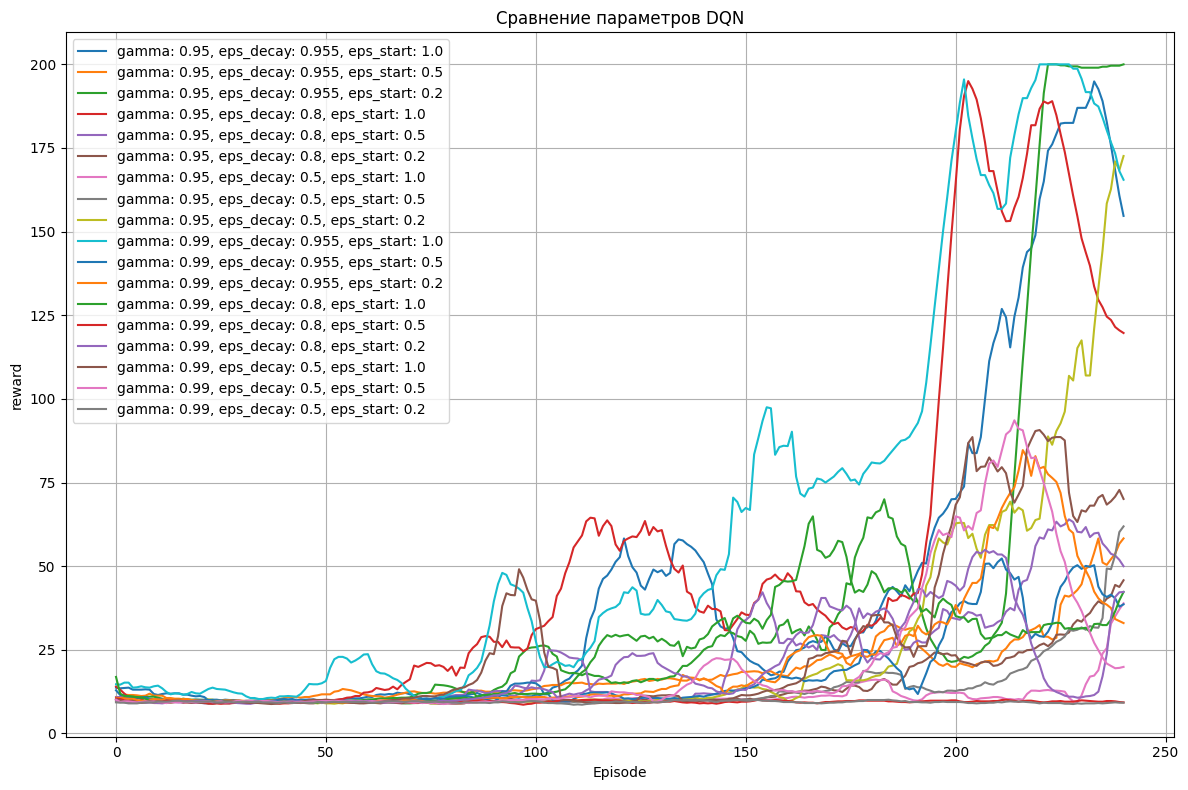

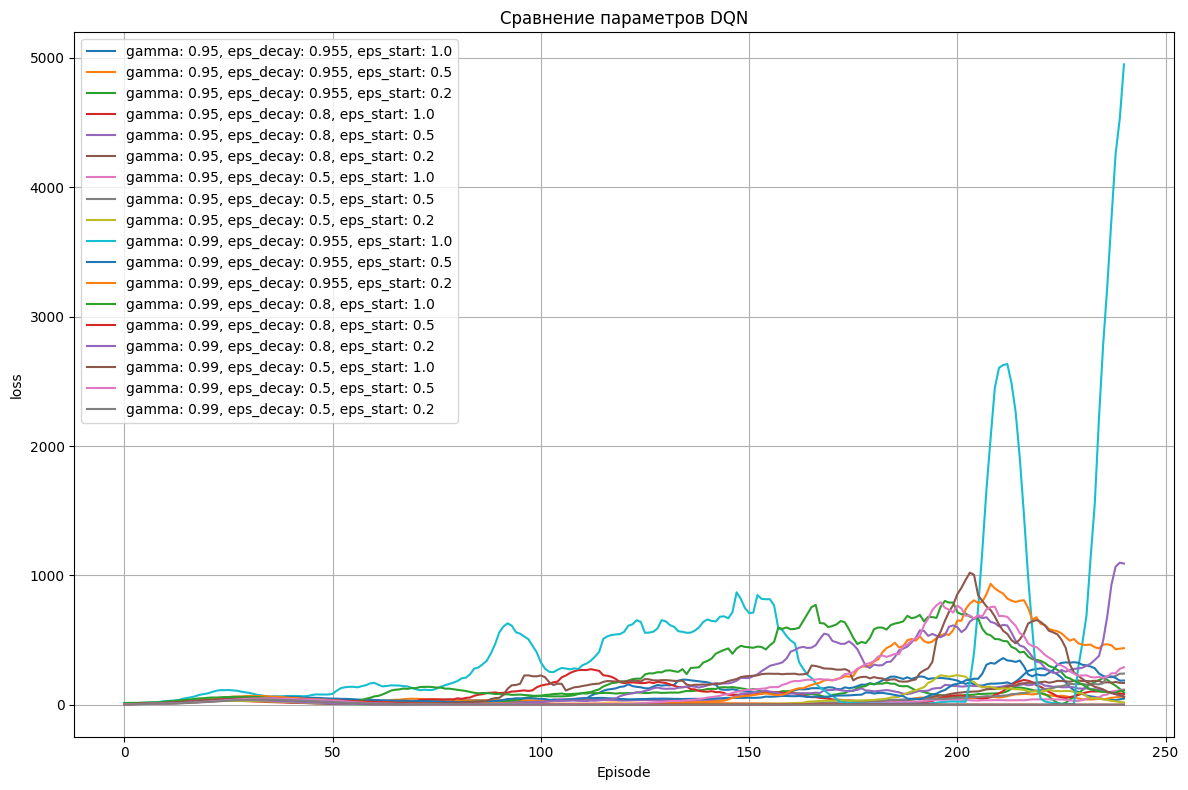

In [35]:
reward, loss = run_experiment(2, gamma_values, epsilon_decay_values, initial_epsilons)
plot_results(reward, 'reward')
plot_results(loss, 'loss')